In [0]:
!pip install torchvision
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
import gym
from gym import wrappers
import random
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import cv2
import math

## Environment - Breakout
## Algorithm - DQN

1. Replay memory size - 10000 (For faster training)
2. Batch size - Number of random samples taken for each training
3. Gamma - discount factor
4. USE_CUDA - using GPU when available
5. episodes - numer of training episodes 
6. Transition - Tuple definition of how it will be stored in the replay memory

In [0]:
num_frames=4
TOTAL_STEPS = 0
BATCH_SIZE = 32
GAMMA = 0.99
MIN_REPLAY_MEMORY = 3000
MAX_REPLAY_MEMORY = 10000
TARGET_UPDATE_FREQUENCY = 1000
TRAIN_EVERY = 4
USE_CUDA = torch.cuda.is_available()
path = '/drive/My Drive/Breakout-DQN.model'
episodes = 3501
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

## Replay Memory

Experience Reply, where the transitions are stored and randomly retrieved in batches

In [0]:
class ReplayMemory(object):
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.memory = []
        self.pos = 0

    def add(self, *args):
        if len(self.memory) < self.maxlen:
            self.memory.append(None)
        self.memory[self.pos] = Transition(*args)
        self.pos = (self.pos + 1) % self.maxlen

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)


## DQN Network
The main neural network used for training. This one is implemented in PyTorch with 3 convolutions and 2 fully connected layers

In [0]:
class DQN(nn.Module):

    def __init__(self, num_frames,num_actions):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(num_frames, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(3136, 512)
        self.fc5 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))
        return self.fc5(x)
       

*** Images have to be preprocessed in order to make it easier for the network to train. Otherise, the memory requirement and time taken for training can be very demanding ***

In [0]:
resize = T.Compose([T.ToPILImage(), T.Resize(84, interpolation=Image.CUBIC), T.ToTensor()])

def get_preprocessed_state():
    state = env.render(mode='rgb_array')
    state =  cv2.cvtColor(state, cv2.COLOR_BGR2GRAY)[34:194,:]
    state = np.ascontiguousarray(state, dtype=np.float32) / 255
    state = torch.from_numpy(state).unsqueeze(0)
    return resize(state).unsqueeze(0)

*** As the number of steps here is more, normal decay would reach the minimum at a very faster rate, so epsilon should be decayed exponentially ***

In [0]:
#Helper Functions for GPU functionalities
def get_variable(x):
    if USE_CUDA:
        return x.cuda()
    return x


# Reference: hhttps://towardsdatascience.com/why-going-from-implementing-q-learning-to-deep-q-learning-can-be-difficult-36e7ea1648af
def decay_epsilon(steps):
    return MIN_EPSILON + (EPSILON - MIN_EPSILON) * math.exp(-1. * steps / DECAY)


*** Here, the agent class is declared where the models, replay memory and optimizer are declared. Training  and optimizations for the models happen in this class ***

In [0]:
class Agent:
    def __init__(self, num_frames, n_actions):
        self.model = DQN(num_frames, n_actions)
        self.target_model = DQN(num_frames, n_actions)
        self.memory = ReplayMemory(MAX_REPLAY_MEMORY)
        self.optimizer = optim.RMSprop(self.model.parameters(),lr=0.0001)
        self.target_model.load_state_dict(self.model.state_dict())
        if USE_CUDA:
          self.model = self.model.cuda()
          self.target_model = self.target_model.cuda()


    
    def train(self):
        if len(self.memory.memory) < MIN_REPLAY_MEMORY:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))


        current_states = torch.cat(batch.state)
        actions = torch.cat(batch.action)
        rewards = torch.cat(batch.reward)

        next_states = torch.cat([s for s in batch.next_state if s is not None])
        none_states = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),  dtype=torch.bool)

        current_state_action_values = self.model(current_states).gather(1, actions)
        future_q_values = get_variable(torch.zeros(BATCH_SIZE))
        future_q_values[none_states] = self.target_model(next_states).max(1)[0].detach()

        expected_state_action_values = (future_q_values * GAMMA) + rewards

        loss = nn.MSELoss()(current_state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

*** This is the main function where the environment is decalred and Training actually starts. ***

Episode:  0
Steps:  1  epsilon:  1.0


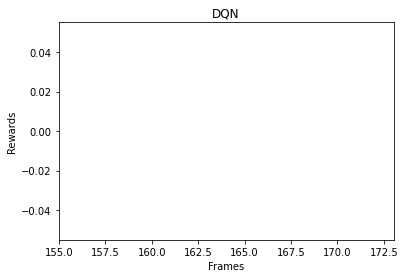

Episode:  1
Steps:  41  epsilon:  0.9980619387073131
Episode:  2
Steps:  117  epsilon:  0.9943902839025779
Episode:  3
Steps:  241  epsilon:  0.9884295614760726
Episode:  4
Steps:  308  epsilon:  0.985224194432611
Episode:  5
Steps:  349  epsilon:  0.9832679906280026
Episode:  6
Steps:  436  epsilon:  0.979130280912052
Episode:  7
Steps:  491  epsilon:  0.9765237582508551
Episode:  8
Steps:  555  epsilon:  0.9734997232609457
Episode:  9
Steps:  624  epsilon:  0.9702502577667359
Episode:  10
Steps:  694  epsilon:  0.9669651341843845


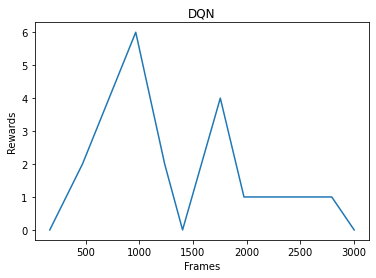

Episode:  11
Steps:  746  epsilon:  0.9645321890347585
Episode:  12
Steps:  802  epsilon:  0.9619191588548924
Episode:  13
Steps:  858  epsilon:  0.9593134349260053
Episode:  14
Steps:  945  epsilon:  0.9552797012155891
Episode:  15
Steps:  999  epsilon:  0.9527848156334857
Episode:  16
Steps:  1055  epsilon:  0.9502046320923891
Episode:  17
Steps:  1115  epsilon:  0.9474481549791394
Episode:  18
Steps:  1264  epsilon:  0.9406385634487459
Episode:  19
Steps:  1337  epsilon:  0.9373207913097291
Episode:  20
Steps:  1421  epsilon:  0.9335180353637643


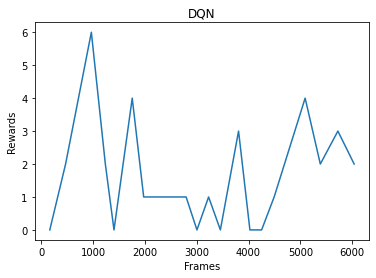

Episode:  21
Steps:  1499  epsilon:  0.9300011773565761
Episode:  22
Steps:  1558  epsilon:  0.9273500861654742
Episode:  23
Steps:  1626  epsilon:  0.9243042766827614
Episode:  24
Steps:  1671  epsilon:  0.9222943540710994
Episode:  25
Steps:  1807  epsilon:  0.9162473356272847
Episode:  26
Steps:  1856  epsilon:  0.914078687333933
Episode:  27
Steps:  1917  epsilon:  0.9113863552311392
Episode:  28
Steps:  1977  epsilon:  0.9087461584407786
Episode:  29
Steps:  2075  epsilon:  0.9044508344025366
Episode:  30
Steps:  2198  epsilon:  0.8990894648805969


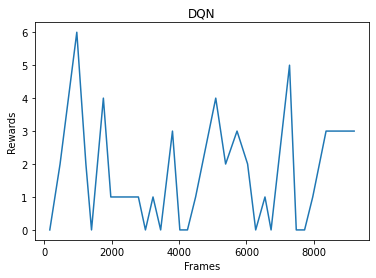

Episode:  31
Steps:  2283  epsilon:  0.8954036725115223
Episode:  32
Steps:  2341  epsilon:  0.892897637368509
Episode:  33
Steps:  2439  epsilon:  0.8886797811324056
Episode:  34
Steps:  2513  epsilon:  0.8855085363629004
Episode:  35
Steps:  2565  epsilon:  0.8832871032827682
Episode:  36
Steps:  2652  epsilon:  0.8795833658527276
Episode:  37
Steps:  2727  epsilon:  0.8764033944037748
Episode:  38
Steps:  2791  epsilon:  0.8736992325082666
Episode:  39
Steps:  2896  epsilon:  0.869281418446672
Episode:  40
Steps:  2952  epsilon:  0.8669347173896789


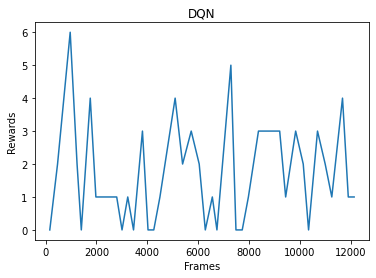

Episode:  41
Steps:  3009  epsilon:  0.8645528492194875
Episode:  42
Steps:  3067  epsilon:  0.8621361518616217
Episode:  43
Steps:  3138  epsilon:  0.859187305821137
Episode:  44
Steps:  3196  epsilon:  0.8567861459988106
Episode:  45
Steps:  3279  epsilon:  0.853362093316459
Episode:  46
Steps:  3362  epsilon:  0.8499522210081112
Episode:  47
Steps:  3419  epsilon:  0.847618684047919
Episode:  48
Steps:  3513  epsilon:  0.8437848926999298
Episode:  49
Steps:  3599  epsilon:  0.8402931303306362
Episode:  50
Steps:  3695  epsilon:  0.8364130429644929


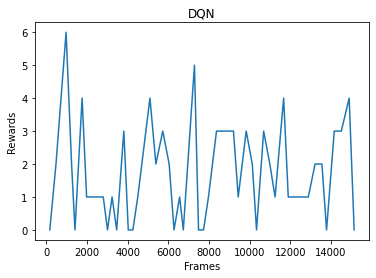

Episode:  51
Steps:  3756  epsilon:  0.8339572302016808
Episode:  52
Steps:  3821  epsilon:  0.831348610506658
Episode:  53
Steps:  3889  epsilon:  0.8286286517809954
Episode:  54
Steps:  4014  epsilon:  0.8236527884776483
Episode:  55
Steps:  4074  epsilon:  0.8212753979810029
Episode:  56
Steps:  4134  epsilon:  0.8189051289682805
Episode:  57
Steps:  4201  epsilon:  0.8162667185910815
Episode:  58
Steps:  4277  epsilon:  0.8132845747222984
Episode:  59
Steps:  4360  epsilon:  0.810040679475502
Episode:  60
Steps:  4487  epsilon:  0.8051031145207995


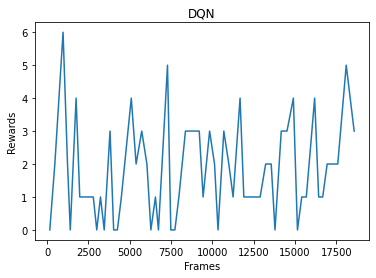

Episode:  61
Steps:  4606  epsilon:  0.8005049441119199
Episode:  62
Steps:  4660  epsilon:  0.7984273867274028
Episode:  63
Steps:  4714  epsilon:  0.796355431181938
Episode:  64
Steps:  4778  epsilon:  0.793907013359987
Episode:  65
Steps:  4865  epsilon:  0.7905912348985912
Episode:  66
Steps:  4929  epsilon:  0.788161233023517
Episode:  67
Steps:  5011  epsilon:  0.7850591356133317
Episode:  68
Steps:  5124  epsilon:  0.7808050805194235
Episode:  69
Steps:  5205  epsilon:  0.777770469179217
Episode:  70
Steps:  5261  epsilon:  0.7756796403918255


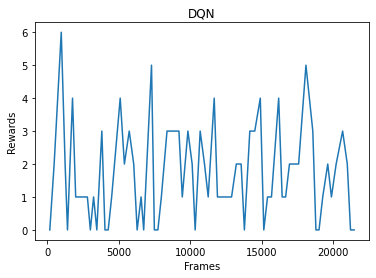

Episode:  71
Steps:  5324  epsilon:  0.773334445146286
Episode:  72
Steps:  5410  epsilon:  0.7701449693196334
Episode:  73
Steps:  5483  epsilon:  0.7674483644792429
Episode:  74
Steps:  5594  epsilon:  0.7633668627005186
Episode:  75
Steps:  5652  epsilon:  0.7612431796274907
Episode:  76
Steps:  5714  epsilon:  0.7589798357661914
Episode:  77
Steps:  5772  epsilon:  0.7568688566416444
Episode:  78
Steps:  5861  epsilon:  0.7536414764763049
Episode:  79
Steps:  5967  epsilon:  0.7498163222636881
Episode:  80
Steps:  6016  epsilon:  0.7480549308596746


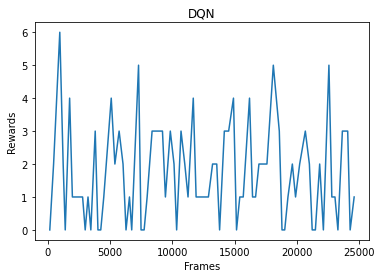

Episode:  81
Steps:  6096  epsilon:  0.7451884479240832
Episode:  82
Steps:  6197  epsilon:  0.7415858504768877
Episode:  83
Steps:  6287  epsilon:  0.7383909081614148
Episode:  84
Steps:  6400  epsilon:  0.7343997850702486
Episode:  85
Steps:  6448  epsilon:  0.7327112526354972
Episode:  86
Steps:  6541  epsilon:  0.7294512307358089
Episode:  87
Steps:  6643  epsilon:  0.7258931103781906
Episode:  88
Steps:  6714  epsilon:  0.7234270696484992
Episode:  89
Steps:  6774  epsilon:  0.7213499057432842
Episode:  90
Steps:  6836  epsilon:  0.7192100395417683


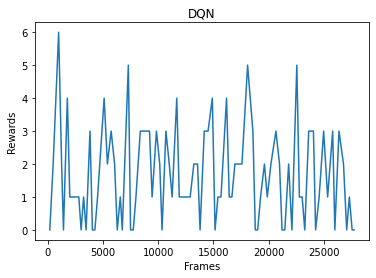

Episode:  91
Steps:  6881  epsilon:  0.7176610602080254
Episode:  92
Steps:  6933  epsilon:  0.7158754637327883
Episode:  93
Steps:  7037  epsilon:  0.7123181683052581
Episode:  94
Steps:  7101  epsilon:  0.7101382399123153
Episode:  95
Steps:  7171  epsilon:  0.7077619170634367
Episode:  96
Steps:  7249  epsilon:  0.7051237932721035
Episode:  97
Steps:  7331  epsilon:  0.7023614523880782
Episode:  98
Steps:  7399  epsilon:  0.7000793052984791
Episode:  99
Steps:  7446  epsilon:  0.6985064677389929
Episode:  100
Steps:  7510  epsilon:  0.6963706661473252


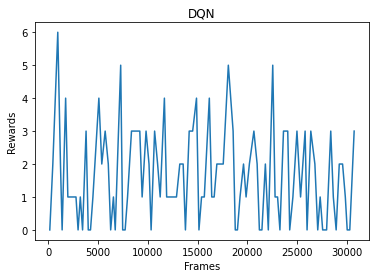

Episode:  101
Steps:  7619  epsilon:  0.6927488245001191
Episode:  102
Steps:  7709  epsilon:  0.6897731550675323
Episode:  103
Steps:  7773  epsilon:  0.6876652554095097
Episode:  104
Steps:  7889  epsilon:  0.6838618375023078
Episode:  105
Steps:  7965  epsilon:  0.6813818774281577
Episode:  106
Steps:  8036  epsilon:  0.6790735714306351
Episode:  107
Steps:  8103  epsilon:  0.6769028130167967
Episode:  108
Steps:  8291  epsilon:  0.6708504173995804
Episode:  109
Steps:  8356  epsilon:  0.6687710343707436
Episode:  110
Steps:  8460  epsilon:  0.6654580462264541


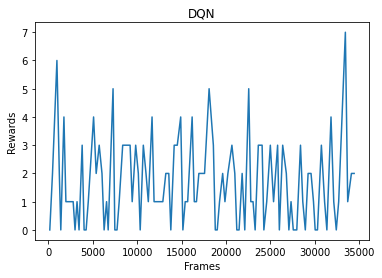

Episode:  111
Steps:  8537  epsilon:  0.6630162362488324
Episode:  112
Steps:  8600  epsilon:  0.6610253723614665
Episode:  113
Steps:  8689  epsilon:  0.6582235481369497
Episode:  114
Steps:  8808  epsilon:  0.6544967163450396
Episode:  115
Steps:  8910  epsilon:  0.6513198908823759
Episode:  116
Steps:  8991  epsilon:  0.6488086340519571
Episode:  117
Steps:  9090  epsilon:  0.6457530999991964
Episode:  118
Steps:  9146  epsilon:  0.6440314028200915
Episode:  119
Steps:  9237  epsilon:  0.6412439063008519
Episode:  120
Steps:  9299  epsilon:  0.6393519841857118


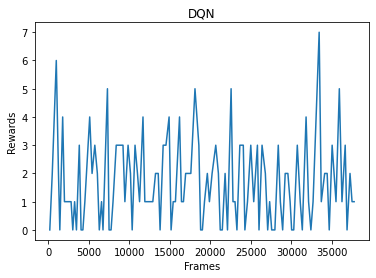

Episode:  121
Steps:  9364  epsilon:  0.6373748048937871
Episode:  122
Steps:  9491  epsilon:  0.6335301944395869
Episode:  123
Steps:  9552  epsilon:  0.6316922316645819
Episode:  124
Steps:  9602  epsilon:  0.6301898798077165
Episode:  125
Steps:  9705  epsilon:  0.6271068475489137
Episode:  126
Steps:  9756  epsilon:  0.6255861647822113
Episode:  127
Steps:  9863  epsilon:  0.6224082872030473
Episode:  128
Steps:  9923  epsilon:  0.6206337255148914
Episode:  129
Steps:  9977  epsilon:  0.6190411653796639
Episode:  130
Steps:  10029  epsilon:  0.6175116475844389


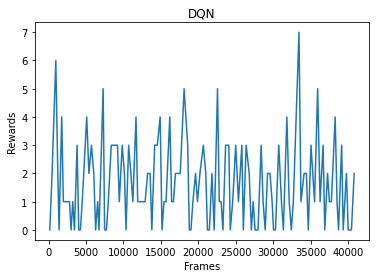

Episode:  131
Steps:  10119  epsilon:  0.6148737848129366
Episode:  132
Steps:  10186  epsilon:  0.6129177358451473
Episode:  133
Steps:  10245  epsilon:  0.6112006624528935
Episode:  134
Steps:  10304  epsilon:  0.6094886469630727
Episode:  135
Steps:  10348  epsilon:  0.6082151732744457
Episode:  136
Steps:  10431  epsilon:  0.6058205525800762
Episode:  137
Steps:  10473  epsilon:  0.6046125982156639
Episode:  138
Steps:  10517  epsilon:  0.6033498400428918
Episode:  139
Steps:  10579  epsilon:  0.6015752076401677
Episode:  140
Steps:  10634  epsilon:  0.6000055351081095


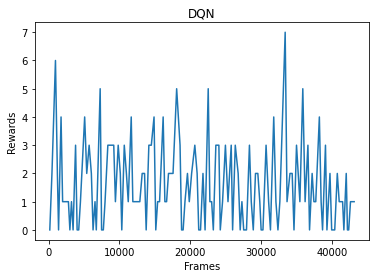

Episode:  141
Steps:  10707  epsilon:  0.597928807238926
Episode:  142
Steps:  10833  epsilon:  0.5943621026695819
Episode:  143
Steps:  10908  epsilon:  0.5922497080000383
Episode:  144
Steps:  11010  epsilon:  0.5893895341320257
Episode:  145
Steps:  11089  epsilon:  0.5871843036696257
Episode:  146
Steps:  11132  epsilon:  0.5859876442865359
Episode:  147
Steps:  11179  epsilon:  0.5846826073414619
Episode:  148
Steps:  11232  epsilon:  0.5832146443420453
Episode:  149
Steps:  11334  epsilon:  0.5804004319971829
Episode:  150
Steps:  11418  epsilon:  0.5780935979253906


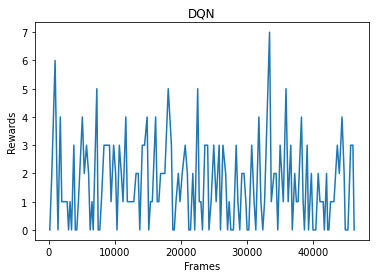

Episode:  151
Steps:  11464  epsilon:  0.576834431246925
Episode:  152
Steps:  11548  epsilon:  0.574542542970144
Episode:  153
Steps:  11617  epsilon:  0.5726671081821028
Episode:  154
Steps:  11717  epsilon:  0.5699605446885977
Episode:  155
Steps:  11799  epsilon:  0.5677512386276681
Episode:  156
Steps:  11911  epsilon:  0.5647482479131652
Episode:  157
Steps:  11982  epsilon:  0.5628532572316679
Episode:  158
Steps:  12042  epsilon:  0.561257092903588
Episode:  159
Steps:  12130  epsilon:  0.5589246967293269
Episode:  160
Steps:  12198  epsilon:  0.557129406483328


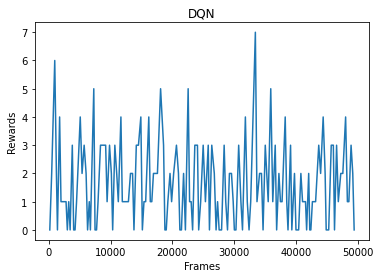

Episode:  161
Steps:  12254  epsilon:  0.5556555085652065
Episode:  162
Steps:  12334  epsilon:  0.5535570861736246
Episode:  163
Steps:  12426  epsilon:  0.5511542543274642
Episode:  164
Steps:  12512  epsilon:  0.5489181022064529
Episode:  165
Steps:  12576  epsilon:  0.5472602183083565
Episode:  166
Steps:  12628  epsilon:  0.5459170885660495
Episode:  167
Steps:  12699  epsilon:  0.544088829980681
Episode:  168
Steps:  12800  epsilon:  0.5414992256436759
Episode:  169
Steps:  12887  epsilon:  0.5392790364246371
Episode:  170
Steps:  12957  epsilon:  0.5374996754952079


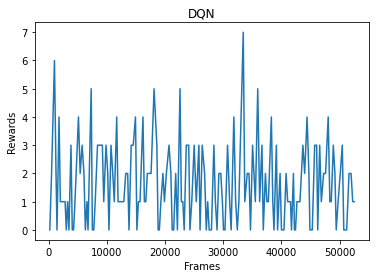

Episode:  171
Steps:  13018  epsilon:  0.5359541595947923
Episode:  172
Steps:  13102  epsilon:  0.5338336083992142
Episode:  173
Steps:  13200  epsilon:  0.5313708623733637
Episode:  174
Steps:  13245  epsilon:  0.530244046076733
Episode:  175
Steps:  13321  epsilon:  0.5283467258930984
Episode:  176
Steps:  13407  epsilon:  0.5262084355906562
Episode:  177
Steps:  13470  epsilon:  0.5246478382497762
Episode:  178
Steps:  13561  epsilon:  0.5224023030523287
Episode:  179
Steps:  13626  epsilon:  0.5208045932521512
Episode:  180
Steps:  13740  epsilon:  0.5180149650638648


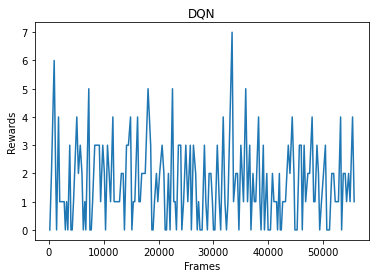

Episode:  181
Steps:  13812  epsilon:  0.516261269735217
Episode:  182
Steps:  13914  epsilon:  0.513787650350566
Episode:  183
Steps:  13977  epsilon:  0.5122661169252243
Episode:  184
Steps:  14068  epsilon:  0.5100767905876752
Episode:  185
Steps:  14133  epsilon:  0.5085190736793564
Episode:  186
Steps:  14177  epsilon:  0.5074674888846752
Episode:  187
Steps:  14236  epsilon:  0.5060610353314281
Episode:  188
Steps:  14291  epsilon:  0.5047536659410934
Episode:  189
Steps:  14365  epsilon:  0.5030003230617097
Episode:  190
Steps:  14444  epsilon:  0.5011356569256884


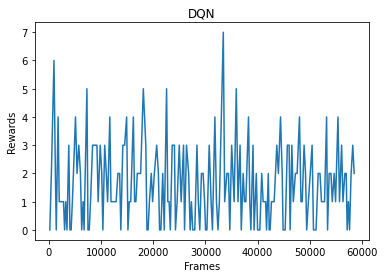

Episode:  191
Steps:  14509  epsilon:  0.49960695153252277
Episode:  192
Steps:  14600  epsilon:  0.49747509355784014
Episode:  193
Steps:  14661  epsilon:  0.4960514666571195
Episode:  194
Steps:  14729  epsilon:  0.4944695823976081
Episode:  195
Steps:  14783  epsilon:  0.4932172059940978
Episode:  196
Steps:  14836  epsilon:  0.49199130543386294
Episode:  197
Steps:  14914  epsilon:  0.4901930482235214
Episode:  198
Steps:  14987  epsilon:  0.48851640533220475
Episode:  199
Steps:  15033  epsilon:  0.48746302944657227
Episode:  200
Steps:  15131  epsilon:  0.48522694348691886


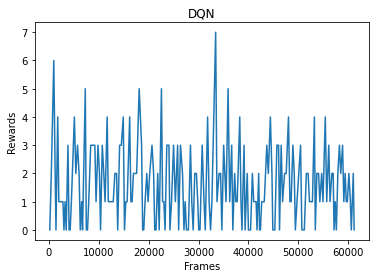

Episode:  201
Steps:  15175  epsilon:  0.4842265450530189
Episode:  202
Steps:  15235  epsilon:  0.48286590739482516
Episode:  203
Steps:  15277  epsilon:  0.4819158868599902
Episode:  204
Steps:  15356  epsilon:  0.48013433997836585
Episode:  205
Steps:  15457  epsilon:  0.4778668916872083
Episode:  206
Steps:  15528  epsilon:  0.4762797830064215
Episode:  207
Steps:  15597  epsilon:  0.4747427706259295
Episode:  208
Steps:  15673  epsilon:  0.47305595507689513
Episode:  209
Steps:  15747  epsilon:  0.47141967702422816
Episode:  210
Steps:  15845  epsilon:  0.46926201120519406


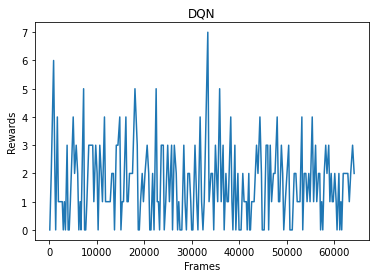

Episode:  211
Steps:  15927  epsilon:  0.467464723915895
Episode:  212
Steps:  15990  epsilon:  0.4660888781303245
Episode:  213
Steps:  16039  epsilon:  0.4650217681224422
Episode:  214
Steps:  16128  epsilon:  0.46309022213157913
Episode:  215
Steps:  16233  epsilon:  0.4608224565587886
Episode:  216
Steps:  16306  epsilon:  0.45925282092001196
Episode:  217
Steps:  16409  epsilon:  0.4570478515618108
Episode:  218
Steps:  16477  epsilon:  0.4555983544080108
Episode:  219
Steps:  16554  epsilon:  0.4539629509153269
Episode:  220
Steps:  16622  epsilon:  0.45252392461319013


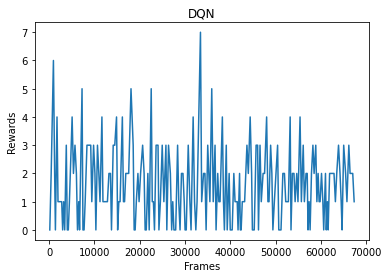

Episode:  221
Steps:  16700  epsilon:  0.4508792904284322
Episode:  222
Steps:  16744  epsilon:  0.44995437377086267
Episode:  223
Steps:  16827  epsilon:  0.44821517445440784
Episode:  224
Steps:  16923  epsilon:  0.44621255175653574
Episode:  225
Steps:  17014  epsilon:  0.44432308643936025
Episode:  226
Steps:  17101  epsilon:  0.4425246953498059
Episode:  227
Steps:  17226  epsilon:  0.43995445636734765
Episode:  228
Steps:  17304  epsilon:  0.4383587476420896
Episode:  229
Steps:  17375  epsilon:  0.4369116442163007
Episode:  230
Steps:  17459  epsilon:  0.43520619925202064


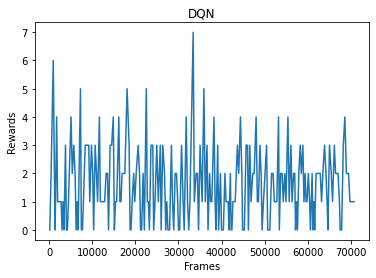

Episode:  231
Steps:  17549  epsilon:  0.4333868679210019
Episode:  232
Steps:  17624  epsilon:  0.4318769999381421
Episode:  233
Steps:  17710  epsilon:  0.4301526388716532
Episode:  234
Steps:  17798  epsilon:  0.4283958350633056
Episode:  235
Steps:  17892  epsilon:  0.42652776803482373
Episode:  236
Steps:  17938  epsilon:  0.42561680218066
Episode:  237
Steps:  18046  epsilon:  0.42348622917329426
Episode:  238
Steps:  18118  epsilon:  0.42207222548203827
Episode:  239
Steps:  18220  epsilon:  0.42007774737428405
Episode:  240
Steps:  18278  epsilon:  0.41894816059937423


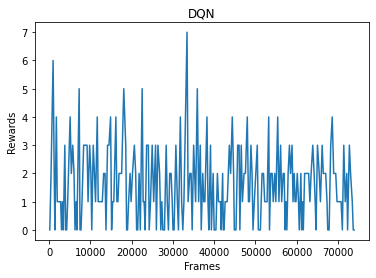

Episode:  241
Steps:  18333  epsilon:  0.41788002252073353
Episode:  242
Steps:  18399  epsilon:  0.4166021281318457
Episode:  243
Steps:  18459  epsilon:  0.4154440597186212
Episode:  244
Steps:  18536  epsilon:  0.41396295304851927
Episode:  245
Steps:  18593  epsilon:  0.4128702165215279
Episode:  246
Steps:  18650  epsilon:  0.41178058985997523
Episode:  247
Steps:  18765  epsilon:  0.4095916506993472
Episode:  248
Steps:  18888  epsilon:  0.4072643259067158
Episode:  249
Steps:  18970  epsilon:  0.40572070874802335
Episode:  250
Steps:  19054  epsilon:  0.40414599099340076


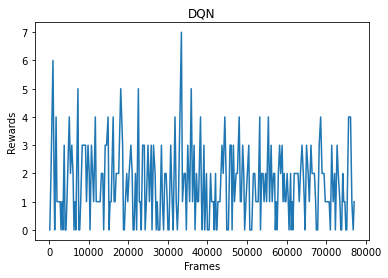

Episode:  251
Steps:  19114  epsilon:  0.4030252349949851
Episode:  252
Steps:  19206  epsilon:  0.4013132594764831
Episode:  253
Steps:  19326  epsilon:  0.3990920502110443
Episode:  254
Steps:  19445  epsilon:  0.3969024729643029
Episode:  255
Steps:  19577  epsilon:  0.39448889022707034
Episode:  256
Steps:  19657  epsilon:  0.3930338466932872
Episode:  257
Steps:  19763  epsilon:  0.3911148571202141
Episode:  258
Steps:  19831  epsilon:  0.38988915148634573
Episode:  259
Steps:  19887  epsilon:  0.3888828713118646
Episode:  260
Steps:  19953  epsilon:  0.387700509806013


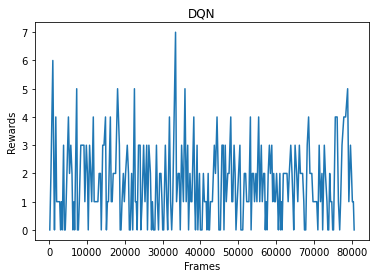

Episode:  261
Steps:  20004  epsilon:  0.3867895354918922
Episode:  262
Steps:  20097  epsilon:  0.38513431552078625
Episode:  263
Steps:  20172  epsilon:  0.38380505575736557
Episode:  264
Steps:  20300  epsilon:  0.3815479338947828
Episode:  265
Steps:  20376  epsilon:  0.3802145867100942
Episode:  266
Steps:  20446  epsilon:  0.3789909782205656
Episode:  267
Steps:  20536  epsilon:  0.37742404705788457
Episode:  268
Steps:  20627  epsilon:  0.3758468584687893
Episode:  269
Steps:  20713  epsilon:  0.37436290975362807
Episode:  270
Steps:  20808  epsilon:  0.37273106463266825


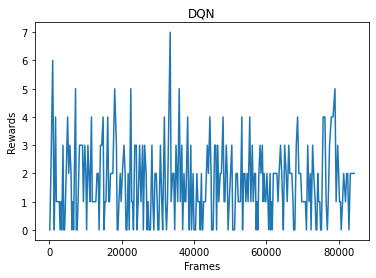

Episode:  271
Steps:  20891  epsilon:  0.37131167797886433
Episode:  272
Steps:  20975  epsilon:  0.36988117509025775
Episode:  273
Steps:  21055  epsilon:  0.3685243658175208
Episode:  274
Steps:  21125  epsilon:  0.3673416015819766
Episode:  275
Steps:  21168  epsilon:  0.366617096260881
Episode:  276
Steps:  21214  epsilon:  0.3658437666094895
Episode:  277
Steps:  21325  epsilon:  0.36398499656291394
Episode:  278
Steps:  21420  epsilon:  0.36240232963892705
Episode:  279
Steps:  21474  epsilon:  0.36150605386568324
Episode:  280
Steps:  21559  epsilon:  0.36010014281392755


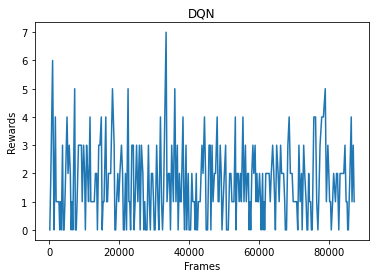

Episode:  281
Steps:  21625  epsilon:  0.3590126077624144
Episode:  282
Steps:  21701  epsilon:  0.35776473231787165
Episode:  283
Steps:  21783  epsilon:  0.3564236480168206
Episode:  284
Steps:  21861  epsilon:  0.3551530750173548
Episode:  285
Steps:  21928  epsilon:  0.35406563469556873
Episode:  286
Steps:  22021  epsilon:  0.35256222762462497
Episode:  287
Steps:  22095  epsilon:  0.35137095260025486
Episode:  288
Steps:  22178  epsilon:  0.3500400267283035
Episode:  289
Steps:  22242  epsilon:  0.3490175355012618
Episode:  290
Steps:  22311  epsilon:  0.3479188213754364


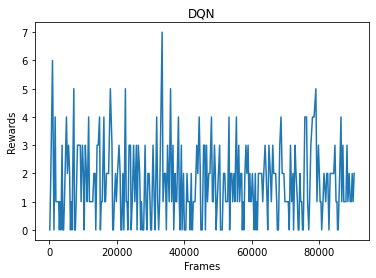

Episode:  291
Steps:  22387  epsilon:  0.3467130223233864
Episode:  292
Steps:  22504  epsilon:  0.34486565994619145
Episode:  293
Steps:  22623  epsilon:  0.34299777174755863
Episode:  294
Steps:  22750  epsilon:  0.34101653298739565
Episode:  295
Steps:  22866  epsilon:  0.33921785829495876
Episode:  296
Steps:  22959  epsilon:  0.33778333310977693
Episode:  297
Steps:  23042  epsilon:  0.3365086790140137
Episode:  298
Steps:  23174  epsilon:  0.33449238282908134
Episode:  299
Steps:  23271  epsilon:  0.3330191702007864
Episode:  300
Steps:  23337  epsilon:  0.3320208550650686


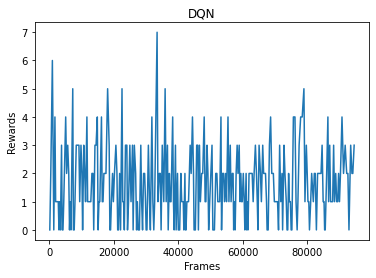

Episode:  301
Steps:  23441  epsilon:  0.33045442287212423
Episode:  302
Steps:  23566  epsilon:  0.32858243877317694
Episode:  303
Steps:  23646  epsilon:  0.3273904944958973
Episode:  304
Steps:  23742  epsilon:  0.32596644058588353
Episode:  305
Steps:  23859  epsilon:  0.3242400914031449
Episode:  306
Steps:  23982  epsilon:  0.32243606789934276
Episode:  307
Steps:  24079  epsilon:  0.3210211868300844
Episode:  308
Steps:  24138  epsilon:  0.32016393939059185
Episode:  309
Steps:  24232  epsilon:  0.31880336872111226
Episode:  310
Steps:  24388  epsilon:  0.31655946504600063


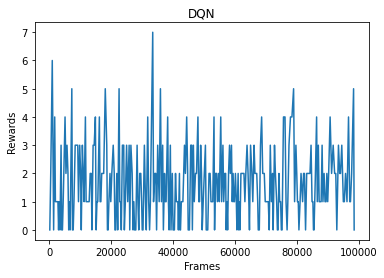

Episode:  311
Steps:  24434  epsilon:  0.3159011356454191
Episode:  312
Steps:  24559  epsilon:  0.3141198259389981
Episode:  313
Steps:  24669  epsilon:  0.3125614563411159
Episode:  314
Steps:  24783  epsilon:  0.31095543754184296
Steps:  24983  epsilon:  0.30815988422922636
Episode:  315
Steps:  25022  epsilon:  0.3076180009628734
Episode:  316
Steps:  25124  epsilon:  0.3062057534501652
Episode:  317
Steps:  25235  epsilon:  0.3046770575735437
Episode:  318
Steps:  25361  epsilon:  0.3029520316480152
Episode:  319
Steps:  25488  epsilon:  0.30122427767153503
Episode:  320
Steps:  25602  epsilon:  0.29968269696764094


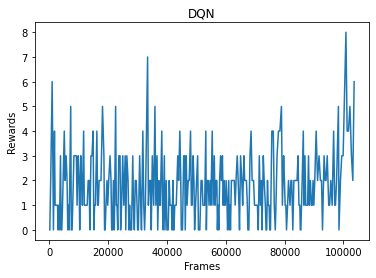

Episode:  321
Steps:  25717  epsilon:  0.2981364711195622
Episode:  322
Steps:  25824  epsilon:  0.2967057715329816
Episode:  323
Steps:  25935  epsilon:  0.2952296545147052
Episode:  324
Steps:  26073  epsilon:  0.2934058691937734
Episode:  325
Steps:  26208  epsilon:  0.29163386681281767
Episode:  326
Steps:  26310  epsilon:  0.2903029308635453
Episode:  327
Steps:  26447  epsilon:  0.28852594889872385
Episode:  328
Steps:  26569  epsilon:  0.2869537407205376
Episode:  329
Steps:  26654  epsilon:  0.2858640046519004
Episode:  330
Steps:  26755  epsilon:  0.28457514852920485


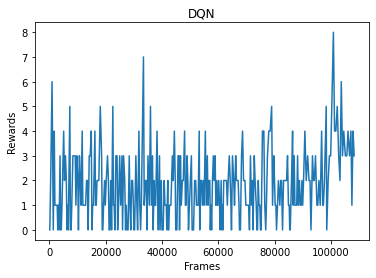

Episode:  331
Steps:  26852  epsilon:  0.2833434483461701
Episode:  332
Steps:  27006  epsilon:  0.28140019492087376
Episode:  333
Steps:  27132  epsilon:  0.27982135226924354
Episode:  334
Steps:  27216  epsilon:  0.27877430293248195
Episode:  335
Steps:  27408  epsilon:  0.2763974965488167
Episode:  336
Steps:  27566  epsilon:  0.2744586249526235
Episode:  337
Steps:  27657  epsilon:  0.2733488648279395
Episode:  338
Steps:  27817  epsilon:  0.2714098403486858
Episode:  339
Steps:  27905  epsilon:  0.27034997047479703
Episode:  340
Steps:  28048  epsilon:  0.2686375972153653


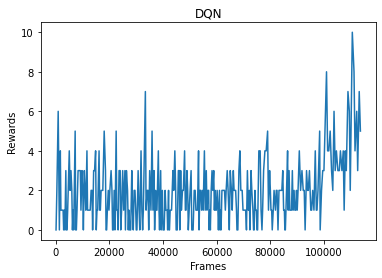

Episode:  341
Steps:  28157  epsilon:  0.26734055994753225
Episode:  342
Steps:  28245  epsilon:  0.26629855557448373
Episode:  343
Steps:  28381  epsilon:  0.26469717625690053
Episode:  344
Steps:  28480  epsilon:  0.263538295829774
Episode:  345
Steps:  28607  epsilon:  0.2620600261248589
Episode:  346
Steps:  28679  epsilon:  0.2612261119769028
Episode:  347
Steps:  28747  epsilon:  0.26044127816970997
Episode:  348
Steps:  28849  epsilon:  0.25926901945164527
Episode:  349
Steps:  28921  epsilon:  0.2584451348636728
Episode:  350
Steps:  29038  epsilon:  0.25711263219515457


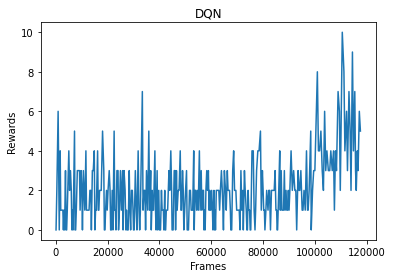

Episode:  351
Steps:  29143  epsilon:  0.25592341530195595
Episode:  352
Steps:  29227  epsilon:  0.25497652681543514
Episode:  353
Steps:  29303  epsilon:  0.2541232382885279
Episode:  354
Steps:  29369  epsilon:  0.25338485061192884
Episode:  355
Steps:  29480  epsilon:  0.2521484987410334
Episode:  356
Steps:  29547  epsilon:  0.25140554641022017
Episode:  357
Steps:  29616  epsilon:  0.2506430134008833
Episode:  358
Steps:  29724  epsilon:  0.24945475232090747
Episode:  359
Steps:  29788  epsilon:  0.2487536195242551
Episode:  360
Steps:  29895  epsilon:  0.2475864127220264


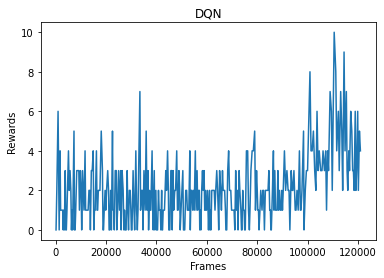

Episode:  361
Steps:  29990  epsilon:  0.24655532802640218
Episode:  362
Steps:  30117  epsilon:  0.24518455849277188
Episode:  363
Steps:  30178  epsilon:  0.24452924544976357
Episode:  364
Steps:  30307  epsilon:  0.243149984714206
Episode:  365
Steps:  30358  epsilon:  0.24260714466839464
Episode:  366
Steps:  30434  epsilon:  0.2418007705997218
Episode:  367
Steps:  30558  epsilon:  0.24049166823282944
Episode:  368
Steps:  30650  epsilon:  0.23952563014999545
Episode:  369
Steps:  30725  epsilon:  0.23874138042421125
Episode:  370
Steps:  30823  epsilon:  0.23772104951237794


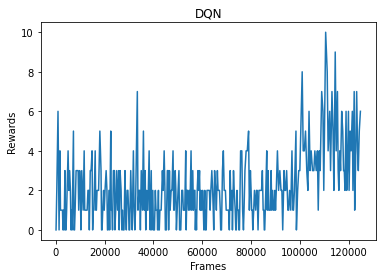

Episode:  371
Steps:  30938  epsilon:  0.23653008079411186
Episode:  372
Steps:  31063  epsilon:  0.23524329318917314
Episode:  373
Steps:  31146  epsilon:  0.23439329848137588
Episode:  374
Steps:  31245  epsilon:  0.2333840516006779
Episode:  375
Steps:  31317  epsilon:  0.2326531853634778
Episode:  376
Steps:  31455  epsilon:  0.231259691467095
Episode:  377
Steps:  31568  epsilon:  0.23012578052515462
Episode:  378
Steps:  31682  epsilon:  0.22898830845127577
Episode:  379
Steps:  31745  epsilon:  0.22836248147462307
Episode:  380
Steps:  31856  epsilon:  0.22726461908863407


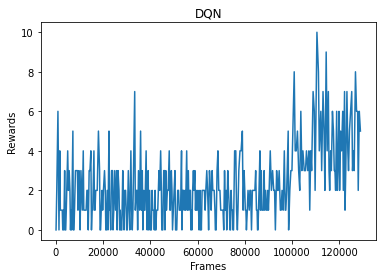

Episode:  381
Steps:  31974  epsilon:  0.22610418448431932
Episode:  382
Steps:  32050  epsilon:  0.2253604026637552
Episode:  383
Steps:  32102  epsilon:  0.22485312536308646
Episode:  384
Steps:  32191  epsilon:  0.22398795538612973
Episode:  385
Steps:  32278  epsilon:  0.2231459404903502
Episode:  386
Steps:  32359  epsilon:  0.22236528133322067
Episode:  387
Steps:  32409  epsilon:  0.22188496877075345
Episode:  388
Steps:  32489  epsilon:  0.22111896193069275
Episode:  389
Steps:  32605  epsilon:  0.22001368036650176
Episode:  390
Steps:  32655  epsilon:  0.2195392394638185


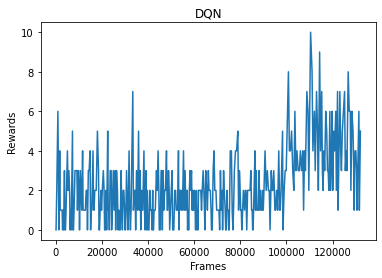

Episode:  391
Steps:  32770  epsilon:  0.21845251616054592
Episode:  392
Steps:  32885  epsilon:  0.21737202358575577
Episode:  393
Steps:  32980  epsilon:  0.21648411692149996
Episode:  394
Steps:  33072  epsilon:  0.21562825996382426
Episode:  395
Steps:  33187  epsilon:  0.2145639602630378
Episode:  396
Steps:  33265  epsilon:  0.21384556260401585
Episode:  397
Steps:  33341  epsilon:  0.2131482751513497
Episode:  398
Steps:  33433  epsilon:  0.21230772782666488
Episode:  399
Steps:  33555  epsilon:  0.2111990356359714
Episode:  400
Steps:  33632  epsilon:  0.21050276053838035


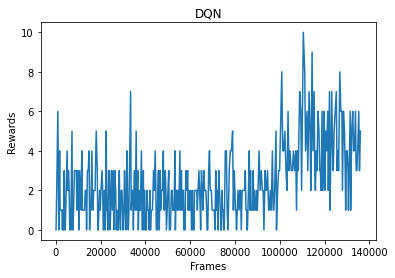

Episode:  401
Steps:  33737  epsilon:  0.2095576042517112
Episode:  402
Steps:  33836  epsilon:  0.20867099029057318
Episode:  403
Steps:  33940  epsilon:  0.20774431259119341
Episode:  404
Steps:  34070  epsilon:  0.2065927212856519
Episode:  405
Steps:  34120  epsilon:  0.20615179087510213
Episode:  406
Steps:  34223  epsilon:  0.2052469411400686
Episode:  407
Steps:  34294  epsilon:  0.204625917468243
Episode:  408
Steps:  34381  epsilon:  0.20386794451366055
Episode:  409
Steps:  34456  epsilon:  0.20321716070401455
Episode:  410
Steps:  34508  epsilon:  0.20276738105310613


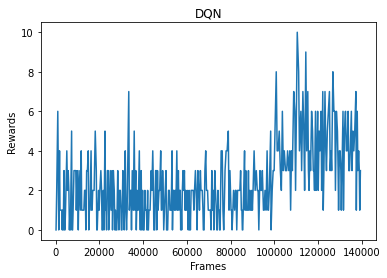

Episode:  411
Steps:  34583  epsilon:  0.20212071662776418
Episode:  412
Steps:  34674  epsilon:  0.20133934633255554
Episode:  413
Steps:  34791  epsilon:  0.20033993727818217
Episode:  414
Steps:  34841  epsilon:  0.19991461930397425
Episode:  415
Steps:  34907  epsilon:  0.19935482522850867
Episode:  416
Steps:  34983  epsilon:  0.1987124980871424
Episode:  417
Steps:  35074  epsilon:  0.1979465999604176
Episode:  418
Steps:  35221  epsilon:  0.19671671780440264
Episode:  419
Steps:  35298  epsilon:  0.19607609243599547
Episode:  420
Steps:  35409  epsilon:  0.19515692317706063


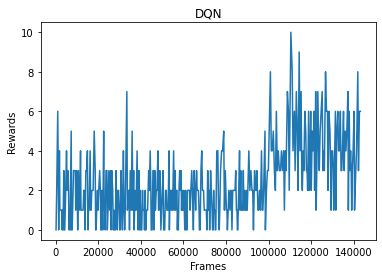

Episode:  421
Steps:  35525  epsilon:  0.19420178559917703
Episode:  422
Steps:  35648  epsilon:  0.19319504352275027
Episode:  423
Steps:  35802  epsilon:  0.19194326721123647
Episode:  424
Steps:  35889  epsilon:  0.19124034396534914
Episode:  425
Steps:  35967  epsilon:  0.19061273126415051
Episode:  426
Steps:  36070  epsilon:  0.18978770197205308
Episode:  427
Steps:  36157  epsilon:  0.18909413507015424
Episode:  428
Steps:  36227  epsilon:  0.18853827891311992
Episode:  429
Steps:  36342  epsilon:  0.18762929962923652
Episode:  430
Steps:  36466  epsilon:  0.1866550213551211


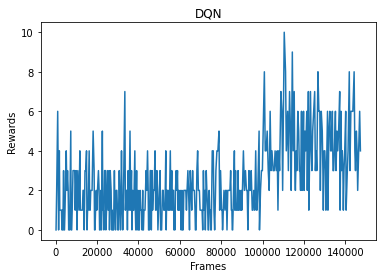

Episode:  431
Steps:  36555  epsilon:  0.18595945529240887
Episode:  432
Steps:  36656  epsilon:  0.1851738453778006
Episode:  433
Steps:  36786  epsilon:  0.1841684863394188
Episode:  434
Steps:  36936  epsilon:  0.18301654786087426
Episode:  435
Steps:  37099  epsilon:  0.18177453108896763
Episode:  436
Steps:  37251  epsilon:  0.18062541681798588
Episode:  437
Steps:  37346  epsilon:  0.17991164264380777
Episode:  438
Steps:  37436  epsilon:  0.1792385558330684
Episode:  439
Steps:  37541  epsilon:  0.17845710651429716
Episode:  440
Steps:  37658  epsilon:  0.1775911677815295


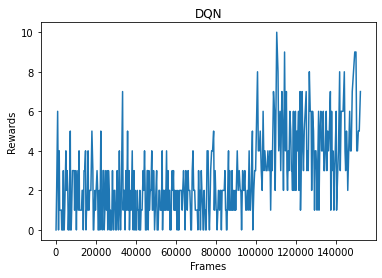

Episode:  441
Steps:  37801  epsilon:  0.17653965457127974
Episode:  442
Steps:  37916  epsilon:  0.17569946940473258
Steps:  38116  epsilon:  0.17424973546149747
Episode:  443
Steps:  38137  epsilon:  0.1740983527291057
Episode:  444
Steps:  38255  epsilon:  0.1732506755546374
Episode:  445
Steps:  38404  epsilon:  0.17218742355321814
Episode:  446
Steps:  38528  epsilon:  0.17130858873033822
Episode:  447
Steps:  38695  epsilon:  0.17013357452581312
Episode:  448
Steps:  38846  epsilon:  0.16907954998760638
Episode:  449
Steps:  38980  epsilon:  0.168150831683187
Episode:  450
Steps:  39082  epsilon:  0.1674480560427514


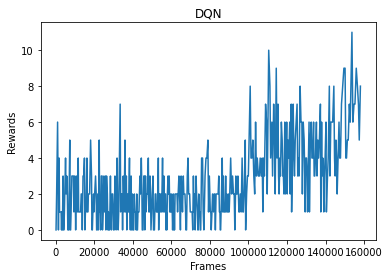

Episode:  451
Steps:  39231  epsilon:  0.16642787292589828
Episode:  452
Steps:  39330  epsilon:  0.16575422361247294
Episode:  453
Steps:  39485  epsilon:  0.1647061947369665
Episode:  454
Steps:  39579  epsilon:  0.16407456112342633
Episode:  455
Steps:  39774  epsilon:  0.1627736862229647
Episode:  456
Steps:  39945  epsilon:  0.1616433104482946
Episode:  457
Steps:  40015  epsilon:  0.16118336423712343
Episode:  458
Steps:  40187  epsilon:  0.16006002458868065
Episode:  459
Steps:  40278  epsilon:  0.15946959572108835
Episode:  460
Steps:  40405  epsilon:  0.158650068540837


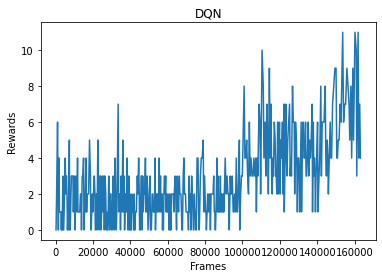

Episode:  461
Steps:  40497  epsilon:  0.158059637258625
Episode:  462
Steps:  40583  epsilon:  0.1575101630346424
Episode:  463
Steps:  40717  epsilon:  0.15665870052688824
Episode:  464
Steps:  40874  epsilon:  0.1556683220490722
Episode:  465
Steps:  40979  epsilon:  0.15501029219808501
Episode:  466
Steps:  41098  epsilon:  0.15426868941566552
Episode:  467
Steps:  41223  epsilon:  0.15349443218104275
Episode:  468
Steps:  41376  epsilon:  0.15255330417922391
Episode:  469
Steps:  41479  epsilon:  0.15192377708635046
Episode:  470
Steps:  41569  epsilon:  0.15137635271806887


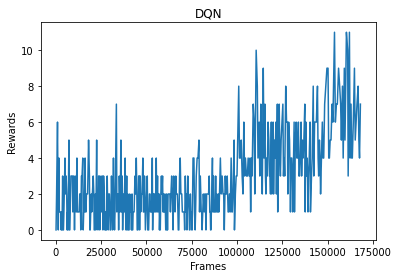

Episode:  471
Steps:  41689  epsilon:  0.15065027501310713
Episode:  472
Steps:  41774  epsilon:  0.15013859942510405
Episode:  473
Steps:  41935  epsilon:  0.14917536591626107
Episode:  474
Steps:  42078  epsilon:  0.14832630107396105
Episode:  475
Steps:  42166  epsilon:  0.14780680906975835
Episode:  476
Steps:  42253  epsilon:  0.14729546243556374
Episode:  477
Steps:  42369  epsilon:  0.14661711785434794
Episode:  478
Steps:  42542  epsilon:  0.14561273002483002
Episode:  479
Steps:  42672  epsilon:  0.14486368431548724
Episode:  480
Steps:  42833  epsilon:  0.14394274341713081


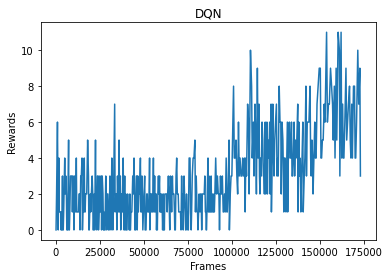

Episode:  481
Steps:  42911  epsilon:  0.1434992321269702
Episode:  482
Steps:  43032  epsilon:  0.14281463476777692
Episode:  483
Steps:  43111  epsilon:  0.14236989589796512
Episode:  484
Steps:  43280  epsilon:  0.14142437074745315
Episode:  485
Steps:  43388  epsilon:  0.14082430079246464
Episode:  486
Steps:  43529  epsilon:  0.14004573713348634
Episode:  487
Steps:  43654  epsilon:  0.1393600961364207
Steps:  43854  epsilon:  0.13827194499865636
Episode:  488
Steps:  43871  epsilon:  0.13817995294756796
Episode:  489
Steps:  43997  epsilon:  0.13750056157391072
Episode:  490
Steps:  44148  epsilon:  0.13669198853812453


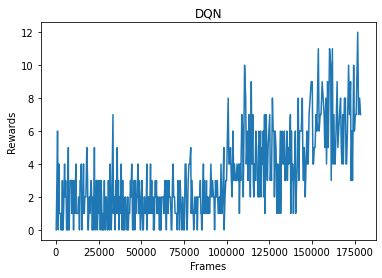

Episode:  491
Steps:  44282  epsilon:  0.13597954157738096
Episode:  492
Steps:  44402  epsilon:  0.13534556815011756
Episode:  493
Steps:  44571  epsilon:  0.1344591484966603
Episode:  494
Steps:  44741  epsilon:  0.13357500865203056
Episode:  495
Steps:  44884  epsilon:  0.13283708854823034
Episode:  496
Steps:  45020  epsilon:  0.13214016855952693
Episode:  497
Steps:  45196  epsilon:  0.13124527836806277
Steps:  45396  epsilon:  0.13023787101618878
Episode:  498
Steps:  45417  epsilon:  0.13013267648841365
Episode:  499
Steps:  45583  epsilon:  0.12930501482094203
Episode:  500
Steps:  45720  epsilon:  0.12862709997854


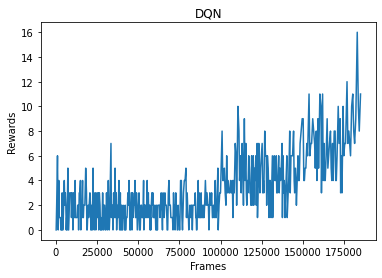

Episode:  501
Steps:  45914  epsilon:  0.12767504205459507
Episode:  502
Steps:  46071  epsilon:  0.12691129460520362
Episode:  503
Steps:  46155  epsilon:  0.12650512073007494
Episode:  504
Steps:  46263  epsilon:  0.12598539759352784
Episode:  505
Steps:  46394  epsilon:  0.12535874775790398
Episode:  506
Steps:  46494  epsilon:  0.12488314401930169
Episode:  507
Steps:  46660  epsilon:  0.12409887315041059
Episode:  508
Steps:  46775  epsilon:  0.1235593572245605
Episode:  509
Steps:  46945  epsilon:  0.12276747296405628
Episode:  510
Steps:  47063  epsilon:  0.12222175632069836


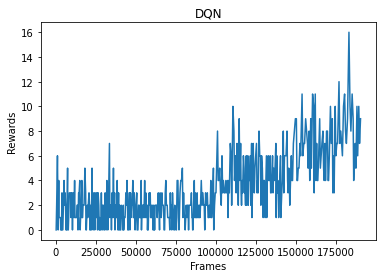

Episode:  511
Steps:  47217  epsilon:  0.12151437570743631
Episode:  512
Steps:  47318  epsilon:  0.1210533930709546
Episode:  513
Steps:  47462  epsilon:  0.12040016309072361
Episode:  514
Steps:  47595  epsilon:  0.11980099644332519
Episode:  515
Steps:  47707  epsilon:  0.11929951631812719
Episode:  516
Steps:  47897  epsilon:  0.1184551878234988
Episode:  517
Steps:  48058  epsilon:  0.11774598194503581
Episode:  518
Steps:  48171  epsilon:  0.11725161504864688
Episode:  519
Steps:  48358  epsilon:  0.11643961446624952
Episode:  520
Steps:  48515  epsilon:  0.1157637198499147


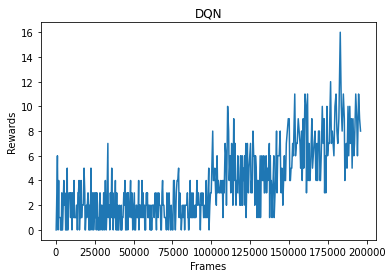

Episode:  521
Steps:  48665  epsilon:  0.11512289803668938
Episode:  522
Steps:  48803  epsilon:  0.11453757173824605
Episode:  523
Steps:  48964  epsilon:  0.11385977607353749
Episode:  524
Steps:  49112  epsilon:  0.11324150415805885
Episode:  525
Steps:  49255  epsilon:  0.1126484500981247
Episode:  526
Steps:  49432  epsilon:  0.11192023840444132
Episode:  527
Steps:  49602  epsilon:  0.11122686737952583
Episode:  528
Steps:  49728  epsilon:  0.1107167466824537
Episode:  529
Steps:  49884  epsilon:  0.1100896050901452
Episode:  530
Steps:  50032  epsilon:  0.10949912946681907
Steps:  50232  epsilon:  0.10870809991182778


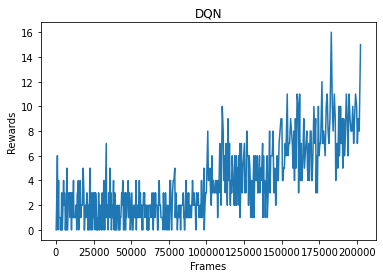

Episode:  531
Steps:  50250  epsilon:  0.10863729448912673
Episode:  532
Steps:  50426  epsilon:  0.10794832222176076
Episode:  533
Steps:  50571  epsilon:  0.1073852405232232
Episode:  534
Steps:  50649  epsilon:  0.107084025835613
Episode:  535
Steps:  50810  epsilon:  0.10646599035795065
Episode:  536
Steps:  50954  epsilon:  0.10591741247759706
Episode:  537
Steps:  51114  epsilon:  0.10531249606962557
Episode:  538
Steps:  51271  epsilon:  0.10472360738761885
Episode:  539
Steps:  51397  epsilon:  0.10425432844189497
Episode:  540
Steps:  51478  epsilon:  0.10395420656872742


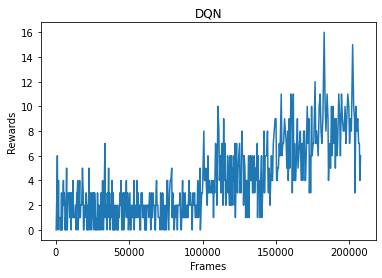

Episode:  541
Steps:  51590  epsilon:  0.10354122045233827
Episode:  542
Steps:  51720  epsilon:  0.10306475271709989
Episode:  543
Steps:  51852  epsilon:  0.1025841132042795
Episode:  544
Steps:  52000  epsilon:  0.10204897322650545
Episode:  545
Steps:  52138  epsilon:  0.10155354649905625
Episode:  546
Steps:  52307  epsilon:  0.10095146640204686
Episode:  547
Steps:  52463  epsilon:  0.10040019770695122
Episode:  548
Steps:  52643  epsilon:  0.09976943860118283
Episode:  549
Steps:  52817  epsilon:  0.09916507726915116
Steps:  53017  epsilon:  0.09847687325157149
Episode:  550
Steps:  53026  epsilon:  0.0984460655908518


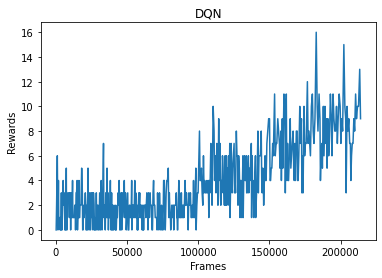

Episode:  551
Steps:  53170  epsilon:  0.0979550237903781
Episode:  552
Steps:  53323  epsilon:  0.09743715124645941
Episode:  553
Steps:  53466  epsilon:  0.09695669529192541
Episode:  554
Steps:  53603  epsilon:  0.09649960923621682
Episode:  555
Steps:  53692  epsilon:  0.09620434342878711
Episode:  556
Steps:  53816  epsilon:  0.09579514632135558
Episode:  557
Steps:  53928  epsilon:  0.09542772324676334
Steps:  54128  epsilon:  0.0947767065230446
Episode:  558
Steps:  54172  epsilon:  0.09463435441342984
Episode:  559
Steps:  54318  epsilon:  0.09416424162557811
Episode:  560
Steps:  54463  epsilon:  0.09370073312237881


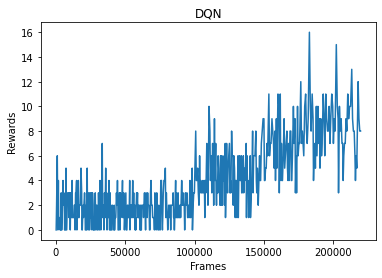

Episode:  561
Steps:  54604  epsilon:  0.09325322228310688
Episode:  562
Steps:  54736  epsilon:  0.09283712564537262
Episode:  563
Steps:  54910  epsilon:  0.0922928138418456
Episode:  564
Steps:  55036  epsilon:  0.09190160272359438
Episode:  565
Steps:  55192  epsilon:  0.0914206483827158
Episode:  566
Steps:  55350  epsilon:  0.09093733685464828
Episode:  567
Steps:  55537  epsilon:  0.09037022811989157
Episode:  568
Steps:  55708  epsilon:  0.08985626300135569
Steps:  55908  epsilon:  0.08926068323333869
Episode:  569
Steps:  55925  epsilon:  0.0892103330544479
Episode:  570
Steps:  56027  epsilon:  0.08890912907886726


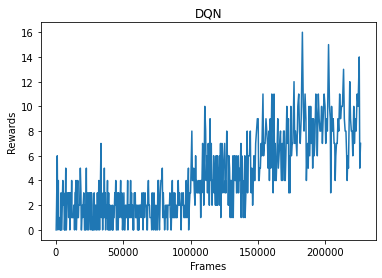

Episode:  571
Steps:  56164  epsilon:  0.088506980476125
Episode:  572
Steps:  56351  epsilon:  0.08796248966991543
Episode:  573
Steps:  56475  epsilon:  0.08760423397423026
Episode:  574
Steps:  56658  epsilon:  0.08707955928067371
Episode:  575
Steps:  56788  epsilon:  0.08670974534270007
Steps:  56988  epsilon:  0.08614547394849786
Episode:  576
Steps:  57002  epsilon:  0.08610618586916595
Steps:  57202  epsilon:  0.08554791999206765
Episode:  577
Steps:  57213  epsilon:  0.08551737703615486
Episode:  578
Steps:  57316  epsilon:  0.08523219751199923
Episode:  579
Steps:  57401  epsilon:  0.08499795878245149
Episode:  580
Steps:  57516  epsilon:  0.08468262796435605


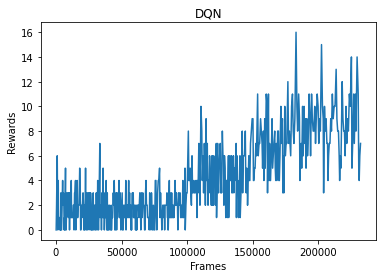

Episode:  581
Steps:  57654  epsilon:  0.08430661656256225
Episode:  582
Steps:  57830  epsilon:  0.0838308149344778
Episode:  583
Steps:  58009  epsilon:  0.08335117871456577
Episode:  584
Steps:  58159  epsilon:  0.08295254163187615
Steps:  58359  epsilon:  0.08242565503923491
Episode:  585
Steps:  58369  epsilon:  0.0823994487638301
Episode:  586
Steps:  58527  epsilon:  0.08198712394605648
Episode:  587
Steps:  58642  epsilon:  0.08168905575066793
Episode:  588
Steps:  58770  epsilon:  0.08135930213100481
Episode:  589
Steps:  58907  epsilon:  0.08100869311822939
Episode:  590
Steps:  59081  epsilon:  0.08056684232601727
Steps:  59281  epsilon:  0.08006369383809381


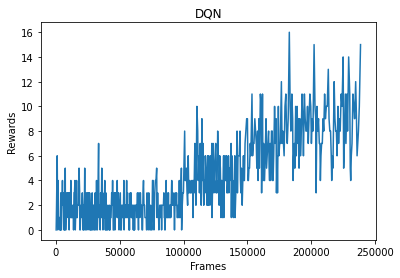

Episode:  591
Steps:  59318  epsilon:  0.07997116162318307
Episode:  592
Steps:  59396  epsilon:  0.07977665362997824
Episode:  593
Steps:  59513  epsilon:  0.07948631028853902
Episode:  594
Steps:  59693  epsilon:  0.07904293169242615
Episode:  595
Steps:  59861  epsilon:  0.07863269646633964
Steps:  60061  epsilon:  0.0781487930512733
Episode:  596
Steps:  60072  epsilon:  0.07812231849626511
Episode:  597
Steps:  60163  epsilon:  0.07790385931862369
Episode:  598
Steps:  60348  epsilon:  0.07746279170255028
Episode:  599
Steps:  60497  epsilon:  0.07711050779132059
Episode:  600
Steps:  60672  epsilon:  0.07670008904869924
Steps:  60872  epsilon:  0.07623541539873602


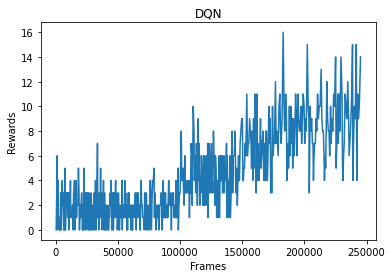

Episode:  601
Steps:  60920  epsilon:  0.0761245834533129
Episode:  602
Steps:  61099  epsilon:  0.07571361027968562
Episode:  603
Steps:  61216  epsilon:  0.07544696635346836
Episode:  604
Steps:  61332  epsilon:  0.07518413689085798
Episode:  605
Steps:  61405  epsilon:  0.07501951540817636
Episode:  606
Steps:  61598  epsilon:  0.07458716652297079
Episode:  607
Steps:  61721  epsilon:  0.07431379692200377
Steps:  61921  epsilon:  0.07387286727542422
Episode:  608
Steps:  61930  epsilon:  0.07385312892661183
Episode:  609
Steps:  62070  epsilon:  0.07354722892322806
Episode:  610
Steps:  62138  epsilon:  0.07339941976285118


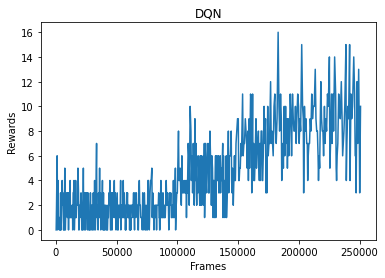

Episode:  611
Steps:  62310  epsilon:  0.07302778507256455
Episode:  612
Steps:  62431  epsilon:  0.07276825284947724
Episode:  613
Steps:  62605  epsilon:  0.07239778293057011
Episode:  614
Steps:  62708  epsilon:  0.07217999563212626
Episode:  615
Steps:  62873  epsilon:  0.07183344216681133
Steps:  63073  epsilon:  0.07141719246240699
Episode:  616
Steps:  63149  epsilon:  0.07126010578476497
Episode:  617
Steps:  63288  epsilon:  0.0709743422281769
Episode:  618
Steps:  63421  epsilon:  0.07070276684133195
Episode:  619
Steps:  63540  epsilon:  0.07046130444162908
Episode:  620
Steps:  63632  epsilon:  0.07027560986616249


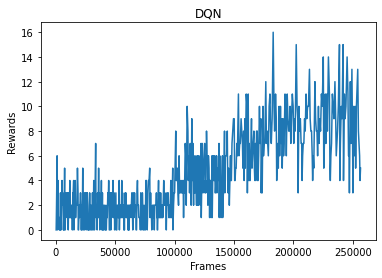

Episode:  621
Steps:  63734  epsilon:  0.07007072715085219
Episode:  622
Steps:  63884  epsilon:  0.06977132087422376
Episode:  623
Steps:  64081  epsilon:  0.06938149640095051
Episode:  624
Steps:  64253  epsilon:  0.06904426769379349
Episode:  625
Steps:  64366  epsilon:  0.06882428960461273
Steps:  64566  epsilon:  0.06843798146847638
Episode:  626
Steps:  64576  epsilon:  0.06841876728168914
Episode:  627
Steps:  64712  epsilon:  0.06815840589614294
Episode:  628
Steps:  64872  epsilon:  0.06785435646828046
Steps:  65072  epsilon:  0.06747769932810281
Episode:  629
Steps:  65092  epsilon:  0.06744024036137966
Episode:  630
Steps:  65280  epsilon:  0.06708995104108133


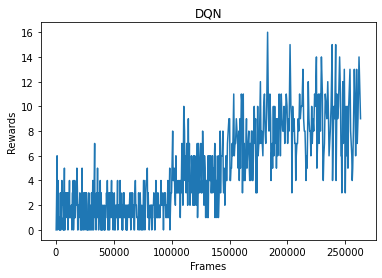

Episode:  631
Steps:  65419  epsilon:  0.06683306957842908
Episode:  632
Steps:  65602  epsilon:  0.06649758417812926
Episode:  633
Steps:  65793  epsilon:  0.06615069129917926
Episode:  634
Steps:  65909  epsilon:  0.065941624170402
Episode:  635
Steps:  66057  epsilon:  0.06567663781029343
Episode:  636
Steps:  66208  epsilon:  0.06540829346940288
Episode:  637
Steps:  66282  epsilon:  0.06527752485468846
Episode:  638
Steps:  66420  epsilon:  0.06503494778650012
Episode:  639
Steps:  66598  epsilon:  0.06472452020302477
Episode:  640
Steps:  66772  epsilon:  0.06442372722396668


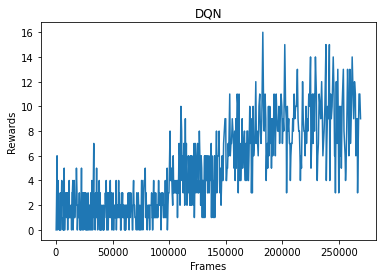

Episode:  641
Steps:  66931  epsilon:  0.06415114354830953
Episode:  642
Steps:  67075  epsilon:  0.06390613839174669
Episode:  643
Steps:  67217  epsilon:  0.0636662573944051
Episode:  644
Steps:  67342  epsilon:  0.06345649946203405
Episode:  645
Steps:  67497  epsilon:  0.06319821374114426
Episode:  646
Steps:  67640  epsilon:  0.06296169308187839
Episode:  647
Steps:  67811  epsilon:  0.0626810719707849
Episode:  648
Steps:  67945  epsilon:  0.06246284067977181
Episode:  649
Steps:  68074  epsilon:  0.062254129175564554
Episode:  650
Steps:  68219  epsilon:  0.06202113237302456


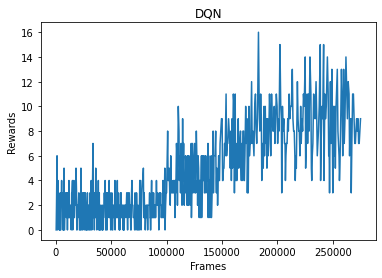

Episode:  651
Steps:  68374  epsilon:  0.06177392775234812
Episode:  652
Steps:  68529  epsilon:  0.06152863156275938
Episode:  653
Steps:  68634  epsilon:  0.06136353999162367
Episode:  654
Steps:  68766  epsilon:  0.06115722222524095
Episode:  655
Steps:  68955  epsilon:  0.06086417331215688
Episode:  656
Steps:  69131  epsilon:  0.06059376014998746
Episode:  657
Steps:  69306  epsilon:  0.060327232507610185
Episode:  658
Steps:  69434  epsilon:  0.06013375799838355
Episode:  659
Steps:  69565  epsilon:  0.05993702688125695
Episode:  660
Steps:  69741  epsilon:  0.05967473681364245


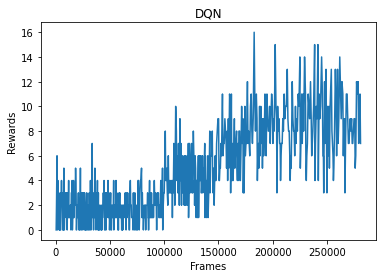

Episode:  661
Steps:  69864  epsilon:  0.059492797219939685
Episode:  662
Steps:  70039  epsilon:  0.05923586097962125
Episode:  663
Steps:  70168  epsilon:  0.05904789651335526
Episode:  664
Steps:  70315  epsilon:  0.05883517717518489
Episode:  665
Steps:  70419  epsilon:  0.058685623430604114
Episode:  666
Steps:  70609  epsilon:  0.05841440035743141
Episode:  667
Steps:  70763  epsilon:  0.058196449661714694
Steps:  70963  epsilon:  0.057915890299897424
Episode:  668
Steps:  70965  epsilon:  0.05791309885044223
Episode:  669
Steps:  71114  epsilon:  0.0577059189673203
Episode:  670
Steps:  71272  epsilon:  0.05748790449848609


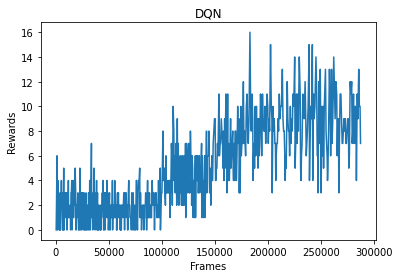

Episode:  671
Steps:  71387  epsilon:  0.057330302587340204
Episode:  672
Steps:  71517  epsilon:  0.05715323172426405
Steps:  71717  epsilon:  0.05688305255436027
Episode:  673
Steps:  71721  epsilon:  0.056877676481474605
Episode:  674
Steps:  71917  epsilon:  0.05661556171211453
Episode:  675
Steps:  72040  epsilon:  0.05645237831087718
Episode:  676
Steps:  72156  epsilon:  0.056299398586727056
Steps:  72356  epsilon:  0.056037715198492224
Episode:  677
Steps:  72376  epsilon:  0.056011690497812794
Episode:  678
Steps:  72555  epsilon:  0.05577992456747942
Episode:  679
Steps:  72680  epsilon:  0.05561930250573356
Episode:  680
Steps:  72874  epsilon:  0.05537199664393865


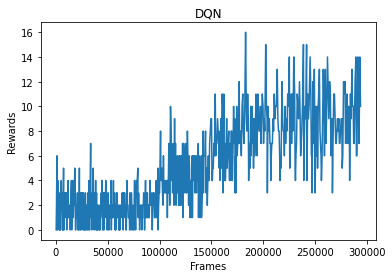

Episode:  681
Steps:  73034  epsilon:  0.05516983041392594
Episode:  682
Steps:  73157  epsilon:  0.055015510975548576
Episode:  683
Steps:  73249  epsilon:  0.05490070388381515
Episode:  684
Steps:  73350  epsilon:  0.054775272310492625
Episode:  685
Steps:  73471  epsilon:  0.05462583441845398
Episode:  686
Steps:  73626  epsilon:  0.054435721839506505
Steps:  73826  epsilon:  0.054192582344744326
Episode:  687
Steps:  73840  epsilon:  0.054175653462902915
Episode:  688
Steps:  73980  epsilon:  0.054007014812546106
Episode:  689
Steps:  74141  epsilon:  0.053814534117537255
Episode:  690
Steps:  74293  epsilon:  0.053634229682959875


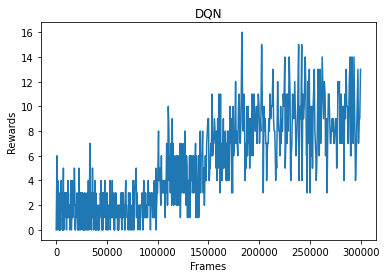

Episode:  691
Steps:  74478  epsilon:  0.053416621049913
Episode:  692
Steps:  74641  epsilon:  0.05322655117517097
Episode:  693
Steps:  74761  epsilon:  0.053087609111137996
Episode:  694
Steps:  74947  epsilon:  0.05287388968212986
Episode:  695
Steps:  75132  epsilon:  0.0526632817658591
Episode:  696
Steps:  75254  epsilon:  0.05252545654139476
Episode:  697
Steps:  75386  epsilon:  0.05237727805511379
Episode:  698
Steps:  75512  epsilon:  0.052236744349354644
Episode:  699
Steps:  75607  epsilon:  0.05213137027524635
Episode:  700
Steps:  75715  epsilon:  0.05201218297110621


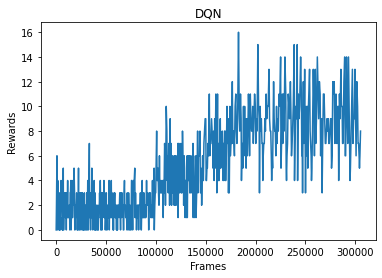

Episode:  701
Steps:  75869  epsilon:  0.05184334004173073
Episode:  702
Steps:  75971  epsilon:  0.051732222597846766
Episode:  703
Steps:  76171  epsilon:  0.0515159833699981
Episode:  704
Steps:  76365  epsilon:  0.051308287285825184
Episode:  705
Steps:  76476  epsilon:  0.05119035385936749
Episode:  706
Steps:  76552  epsilon:  0.05110998331544787
Episode:  707
Steps:  76715  epsilon:  0.05093863613960978
Episode:  708
Steps:  76893  epsilon:  0.05075310909793417
Steps:  77093  epsilon:  0.05054661221218807
Episode:  709
Steps:  77220  epsilon:  0.05041655459459693
Episode:  710
Steps:  77351  epsilon:  0.0502832631679688


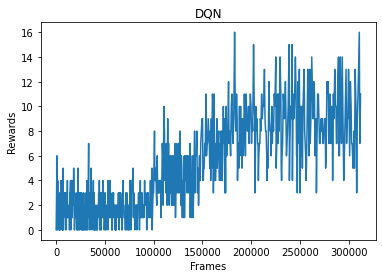

Episode:  711
Steps:  77532  epsilon:  0.050100527761219746
Episode:  712
Steps:  77712  epsilon:  0.049920434646014075
Episode:  713
Steps:  77874  epsilon:  0.04975973085438448
Episode:  714
Steps:  78014  epsilon:  0.04962189572418581
Episode:  715
Steps:  78200  epsilon:  0.049440258018434505
Episode:  716
Steps:  78353  epsilon:  0.04929210744305543
Episode:  717
Steps:  78530  epsilon:  0.049122125571415376
Steps:  78730  epsilon:  0.04893185724291052
Episode:  718
Steps:  78795  epsilon:  0.048870428582514204
Episode:  719
Steps:  78943  epsilon:  0.04873130281123403
Episode:  720
Steps:  79114  epsilon:  0.048571832877633836


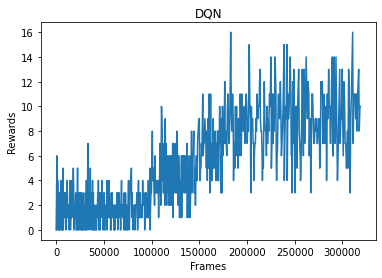

Episode:  721
Steps:  79273  epsilon:  0.04842477214720975
Episode:  722
Steps:  79442  epsilon:  0.048269738761101987
Episode:  723
Steps:  79613  epsilon:  0.048114198377366454
Episode:  724
Steps:  79804  epsilon:  0.047942031189688275
Steps:  80004  epsilon:  0.04776350499647326
Episode:  725
Steps:  80086  epsilon:  0.047690823724409775
Episode:  726
Steps:  80222  epsilon:  0.047570934209408694
Episode:  727
Steps:  80389  epsilon:  0.04742482775212725
Episode:  728
Steps:  80565  epsilon:  0.04727216198249673
Steps:  80765  epsilon:  0.0471003010992596
Episode:  729
Steps:  80774  epsilon:  0.047092607694910735
Episode:  730
Steps:  80950  epsilon:  0.04694285263587333
Steps:  81150  epsilon:  0.04677426843538306


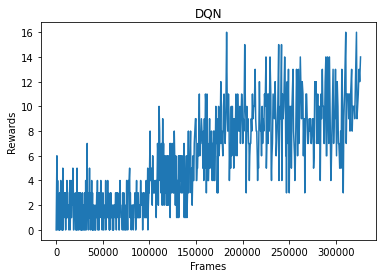

Episode:  731
Steps:  81169  epsilon:  0.04675834044736168
Episode:  732
Steps:  81362  epsilon:  0.046597400247436804
Episode:  733
Steps:  81534  epsilon:  0.046455274621467056
Episode:  734
Steps:  81680  epsilon:  0.046335588502569955
Steps:  81880  epsilon:  0.046173046681164204
Episode:  735
Steps:  81976  epsilon:  0.04609560207284817
Episode:  736
Steps:  82113  epsilon:  0.0459857239608288
Episode:  737
Steps:  82273  epsilon:  0.04585834835091767
Steps:  82473  epsilon:  0.04570055514836244
Episode:  738
Steps:  82498  epsilon:  0.04568094171537643
Steps:  82698  epsilon:  0.04552491373833883
Episode:  739
Steps:  82743  epsilon:  0.04549002195040895
Episode:  740
Steps:  82868  epsilon:  0.04539351122340311


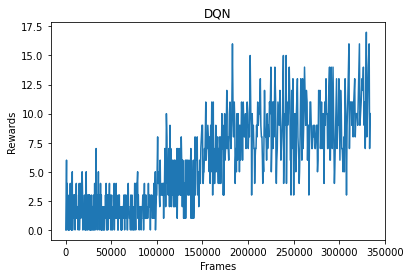

Episode:  741
Steps:  83016  epsilon:  0.04528001967697101
Steps:  83216  epsilon:  0.045127980940869165
Episode:  742
Steps:  83218  epsilon:  0.045126468218412465
Episode:  743
Steps:  83416  epsilon:  0.044977455015468105
Steps:  83616  epsilon:  0.04482842684804984
Episode:  744
Steps:  83625  epsilon:  0.04482175555712126
Episode:  745
Steps:  83763  epsilon:  0.044719837465552734
Episode:  746
Steps:  83942  epsilon:  0.04458868271323678
Episode:  747
Steps:  84106  epsilon:  0.04446954464862269
Episode:  748
Steps:  84253  epsilon:  0.044363583380140945
Episode:  749
Steps:  84373  epsilon:  0.04427765990804664
Episode:  750
Steps:  84555  epsilon:  0.04414832258025897
Steps:  84755  epsilon:  0.044007544418414986


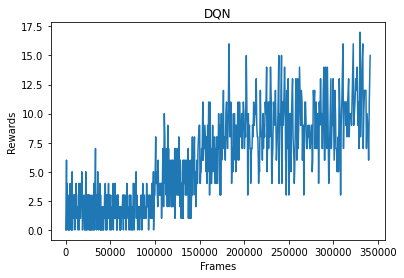

Episode:  751
Steps:  84800  epsilon:  0.043976062873492865
Episode:  752
Steps:  84950  epsilon:  0.04387163449785786
Episode:  753
Steps:  85121  epsilon:  0.043753537606542166
Steps:  85321  epsilon:  0.04361668762082001
Episode:  754
Steps:  85323  epsilon:  0.043615326020139095
Steps:  85523  epsilon:  0.043479851262679434
Episode:  755
Steps:  85591  epsilon:  0.043434097593699615
Episode:  756
Steps:  85748  epsilon:  0.04332905276795662
Episode:  757
Steps:  85945  epsilon:  0.0431984060893881
Episode:  758
Steps:  86018  epsilon:  0.043150319718175185
Episode:  759
Steps:  86123  epsilon:  0.04308146145076547
Episode:  760
Steps:  86298  epsilon:  0.04296749798036403


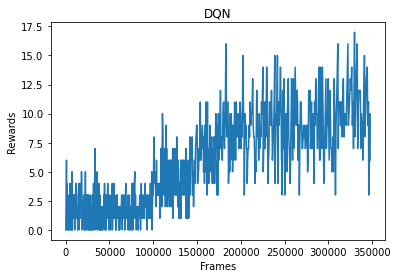

Episode:  761
Steps:  86420  epsilon:  0.04288863701316833
Steps:  86620  epsilon:  0.04276039293214068
Episode:  762
Steps:  86726  epsilon:  0.04269294175311664
Episode:  763
Steps:  86879  epsilon:  0.04259621121475681
Episode:  764
Steps:  87047  epsilon:  0.04249084619318903
Episode:  765
Steps:  87217  epsilon:  0.042385123956587674
Episode:  766
Steps:  87330  epsilon:  0.042315345316516775
Episode:  767
Steps:  87500  epsilon:  0.042211108515323115
Episode:  768
Steps:  87647  epsilon:  0.04212168589842168
Steps:  87847  epsilon:  0.04200107310849202
Episode:  769
Steps:  87852  epsilon:  0.04199807321521718
Steps:  88052  epsilon:  0.04187869039203612
Episode:  770
Steps:  88071  epsilon:  0.041867410994725705


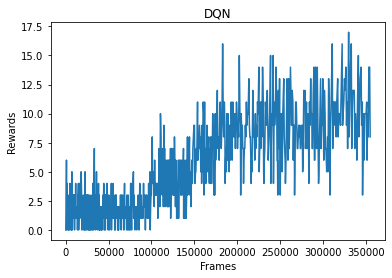

Episode:  771
Steps:  88223  epsilon:  0.041777560535391056
Episode:  772
Steps:  88358  epsilon:  0.04169832970665349
Episode:  773
Steps:  88532  epsilon:  0.04159699568038344
Episode:  774
Steps:  88700  epsilon:  0.04149998891547992
Episode:  775
Steps:  88897  epsilon:  0.041387270076299235
Steps:  89097  epsilon:  0.04127396484589693
Episode:  776
Steps:  89148  epsilon:  0.04124525285888164
Episode:  777
Steps:  89258  epsilon:  0.04118357374121407
Episode:  778
Steps:  89415  epsilon:  0.041096126367347996
Steps:  89615  epsilon:  0.04098571806525264
Episode:  779
Steps:  89625  epsilon:  0.04098022657920593
Episode:  780
Steps:  89800  epsilon:  0.04088456871013143


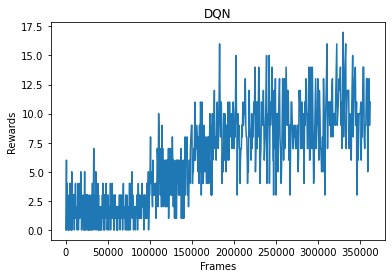

Episode:  781
Steps:  89977  epsilon:  0.04078866527569307
Episode:  782
Steps:  90150  epsilon:  0.040695745777260754
Episode:  783
Steps:  90235  epsilon:  0.040650385316962453
Episode:  784
Steps:  90349  epsilon:  0.04058985080790368
Episode:  785
Steps:  90518  epsilon:  0.04050074357683412
Episode:  786
Steps:  90619  epsilon:  0.04044784849426761
Episode:  787
Steps:  90714  epsilon:  0.04039833889231281
Episode:  788
Steps:  90869  epsilon:  0.040318063235862116
Episode:  789
Steps:  90988  epsilon:  0.0402568530405226
Steps:  91188  epsilon:  0.04015479564755904
Episode:  790
Steps:  91239  epsilon:  0.04012893390639159


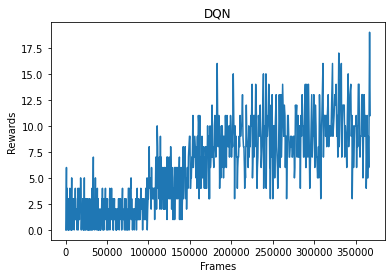

Episode:  791
Steps:  91410  epsilon:  0.04004270069379709
Episode:  792
Steps:  91541  epsilon:  0.039977135963152985
Episode:  793
Steps:  91683  epsilon:  0.039906549177426996
Episode:  794
Steps:  91834  epsilon:  0.039832036370932966
Episode:  795
Steps:  92015  epsilon:  0.03974345786408544
Episode:  796
Steps:  92131  epsilon:  0.039687109377049654
Episode:  797
Steps:  92282  epsilon:  0.03961424710245019
Episode:  798
Steps:  92425  epsilon:  0.03954575040317754
Episode:  799
Steps:  92584  epsilon:  0.039470162547310714
Episode:  800
Steps:  92700  epsilon:  0.039415394585159316


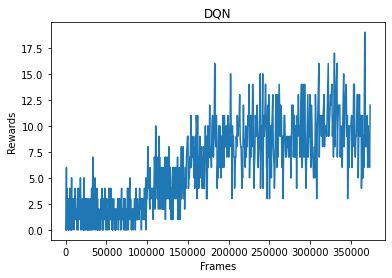

Episode:  801
Steps:  92892  epsilon:  0.039325439273493516
Episode:  802
Steps:  93086  epsilon:  0.03923541981275171
Steps:  93286  epsilon:  0.0391435258502186
Episode:  803
Steps:  93398  epsilon:  0.03909246520869206
Episode:  804
Steps:  93552  epsilon:  0.03902272208221091
Episode:  805
Steps:  93675  epsilon:  0.03896740262310198
Episode:  806
Steps:  93866  epsilon:  0.03888217155417836
Episode:  807
Steps:  93988  epsilon:  0.038828155224997406
Episode:  808
Steps:  94119  epsilon:  0.03877051977044594
Episode:  809
Steps:  94311  epsilon:  0.03868672563603281
Episode:  810
Steps:  94433  epsilon:  0.03863389789806372
Steps:  94633  epsilon:  0.038547989178585276


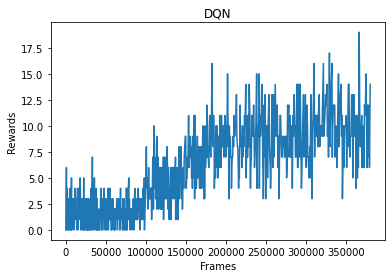

Episode:  811
Steps:  94651  epsilon:  0.03854029944922182
Episode:  812
Steps:  94795  epsilon:  0.03847903012742912
Episode:  813
Steps:  94966  epsilon:  0.038406843457604735
Episode:  814
Steps:  95150  epsilon:  0.03832985518686335
Steps:  95350  epsilon:  0.0382469717429087
Episode:  815
Steps:  95355  epsilon:  0.03824491025766937
Episode:  816
Steps:  95524  epsilon:  0.038175534292246925
Episode:  817
Steps:  95652  epsilon:  0.03812337795109509
Episode:  818
Steps:  95820  epsilon:  0.03805542736830258
Steps:  96020  epsilon:  0.03797527452676646
Episode:  819
Steps:  96021  epsilon:  0.03797487577300905
Episode:  820
Steps:  96220  epsilon:  0.03789591921932911


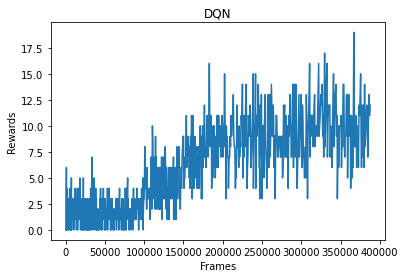

Episode:  821
Steps:  96418  epsilon:  0.03781813528483276
Episode:  822
Steps:  96554  epsilon:  0.037765152311167255
Episode:  823
Steps:  96728  epsilon:  0.03769788850787035
Episode:  824
Steps:  96872  epsilon:  0.037642662761874286
Steps:  97072  epsilon:  0.037566616996794595
Episode:  825
Steps:  97088  epsilon:  0.037560566123869044
Episode:  826
Steps:  97271  epsilon:  0.03749170247547942
Episode:  827
Steps:  97453  epsilon:  0.03742383723810864
Episode:  828
Steps:  97628  epsilon:  0.03735916202895601
Episode:  829
Steps:  97761  epsilon:  0.03731038596163713
Episode:  830
Steps:  97943  epsilon:  0.03724416321985282
Steps:  98143  epsilon:  0.03717208259146713


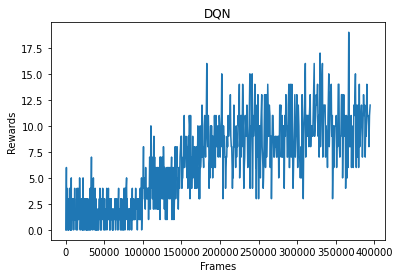

Episode:  831
Steps:  98153  epsilon:  0.03716849744653231
Episode:  832
Steps:  98299  epsilon:  0.037116357955856175
Episode:  833
Steps:  98457  epsilon:  0.03706036021033437
Episode:  834
Steps:  98614  epsilon:  0.03700515335309632
Episode:  835
Steps:  98789  epsilon:  0.03694412564684058
Episode:  836
Steps:  98988  epsilon:  0.03687537420230389
Episode:  837
Steps:  99131  epsilon:  0.03682639060180935
Episode:  838
Steps:  99283  epsilon:  0.03677470668090673
Episode:  839
Steps:  99446  epsilon:  0.03671971720793754
Episode:  840
Steps:  99609  epsilon:  0.03666517407785519


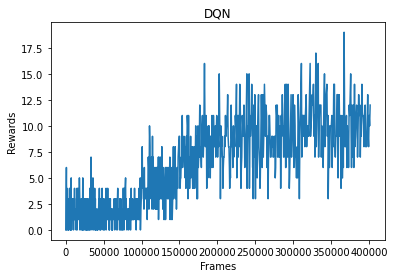

Episode:  841
Steps:  99790  epsilon:  0.03660512637812936
Episode:  842
Steps:  99891  epsilon:  0.03657185457193993
Episode:  843
Steps:  100051  epsilon:  0.03651948947503226
Episode:  844
Steps:  100224  epsilon:  0.03646333909159052
Episode:  845
Steps:  100413  epsilon:  0.03640254822641031
Steps:  100613  epsilon:  0.036338841807128555
Episode:  846
Steps:  100623  epsilon:  0.03633567317844817
Episode:  847
Steps:  100767  epsilon:  0.03629022015879099
Episode:  848
Steps:  100908  epsilon:  0.03624603005980017
Episode:  849
Steps:  101077  epsilon:  0.036193473470108595
Episode:  850
Steps:  101154  epsilon:  0.036169674439778816
Steps:  101354  epsilon:  0.0361082851533895


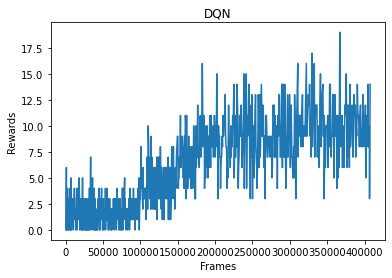

Episode:  851
Steps:  101361  epsilon:  0.03610614762767464
Episode:  852
Steps:  101519  epsilon:  0.03605809910298066
Episode:  853
Steps:  101705  epsilon:  0.03600201995355764
Episode:  854
Steps:  101833  epsilon:  0.035963729685410305
Steps:  102033  epsilon:  0.03590438958356545
Episode:  855
Steps:  102039  epsilon:  0.03590261853236135
Episode:  856
Steps:  102200  epsilon:  0.035855293193232246
Episode:  857
Steps:  102317  epsilon:  0.035821139724349686
Episode:  858
Steps:  102460  epsilon:  0.035779667016931825
Episode:  859
Steps:  102646  epsilon:  0.035726165282353346
Episode:  860
Steps:  102800  epsilon:  0.03568224312698921


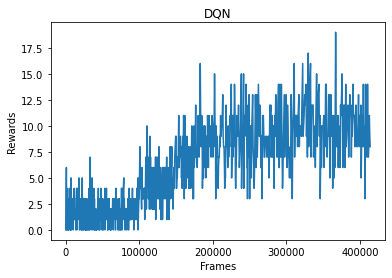

Episode:  861
Steps:  102926  epsilon:  0.03564655752297189
Episode:  862
Steps:  103119  epsilon:  0.03559233030999166
Steps:  103319  epsilon:  0.03553668569367768
Episode:  863
Steps:  103352  epsilon:  0.03552755769495297
Episode:  864
Steps:  103526  epsilon:  0.03547967652809281
Episode:  865
Steps:  103699  epsilon:  0.03543248173786153
Episode:  866
Steps:  103885  epsilon:  0.035382193858786486
Episode:  867
Steps:  104034  epsilon:  0.035342245506918515
Steps:  104234  epsilon:  0.035289089275971915
Episode:  868
Steps:  104245  epsilon:  0.03528618107669824
Steps:  104445  epsilon:  0.03523358269615309
Episode:  869
Steps:  104464  epsilon:  0.035228613153498255
Episode:  870
Steps:  104635  epsilon:  0.03518409907987443


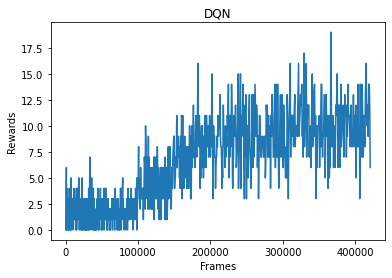

Episode:  871
Steps:  104750  epsilon:  0.035154376045781276
Episode:  872
Steps:  104883  epsilon:  0.03512021316256079
Episode:  873
Steps:  105057  epsilon:  0.0350758605217878
Episode:  874
Steps:  105243  epsilon:  0.035028873845635265
Steps:  105443  epsilon:  0.03497883571481673
Episode:  875
Steps:  105585  epsilon:  0.03494361117632547
Steps:  105785  epsilon:  0.03489442142324156
Episode:  876
Steps:  105789  epsilon:  0.034893442636838815
Steps:  105989  epsilon:  0.03484475206906336
Episode:  877
Steps:  105997  epsilon:  0.034842814555764226
Episode:  878
Steps:  106143  epsilon:  0.03480759073288365
Episode:  879
Steps:  106283  epsilon:  0.03477405510937277
Episode:  880
Steps:  106454  epsilon:  0.034733410939612255


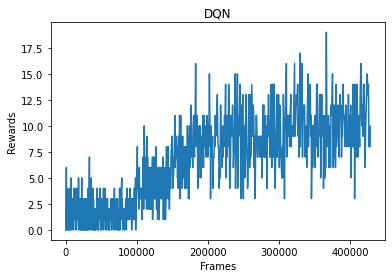

Episode:  881
Steps:  106604  epsilon:  0.03469804315255299
Steps:  106804  epsilon:  0.0346512968421315
Episode:  882
Steps:  106866  epsilon:  0.03463690014832564
Episode:  883
Steps:  107014  epsilon:  0.03460271373296872
Steps:  107214  epsilon:  0.0345569159661207
Episode:  884
Steps:  107243  epsilon:  0.03455031322611318
Steps:  107443  epsilon:  0.03450503685302
Episode:  885
Steps:  107481  epsilon:  0.034496485409443216
Episode:  886
Steps:  107591  epsilon:  0.03447182262452055
Episode:  887
Steps:  107779  epsilon:  0.03442998443938823
Episode:  888
Steps:  107932  epsilon:  0.03439622435539175
Episode:  889
Steps:  108081  epsilon:  0.034363594182260204
Episode:  890
Steps:  108233  epsilon:  0.034330556568428476


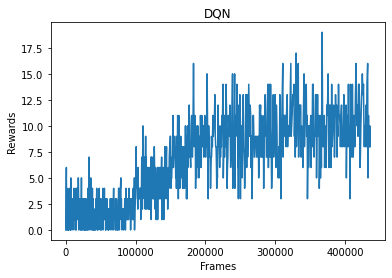

Episode:  891
Steps:  108369  epsilon:  0.03430120867967205
Episode:  892
Steps:  108534  epsilon:  0.034265869681868844
Episode:  893
Steps:  108715  epsilon:  0.03422743772814427
Episode:  894
Steps:  108896  epsilon:  0.03418935201450137
Steps:  109096  epsilon:  0.03414766726547382
Episode:  895
Steps:  109144  epsilon:  0.03413772479976791
Steps:  109344  epsilon:  0.03409655375011003
Episode:  896
Steps:  109355  epsilon:  0.03409430126503765
Episode:  897
Steps:  109517  epsilon:  0.034061271376430426
Steps:  109717  epsilon:  0.034020861051045195
Episode:  898
Steps:  109727  epsilon:  0.03401885112304355
Episode:  899
Steps:  109897  epsilon:  0.03398483565902097
Episode:  900
Steps:  110047  epsilon:  0.03395506118542202


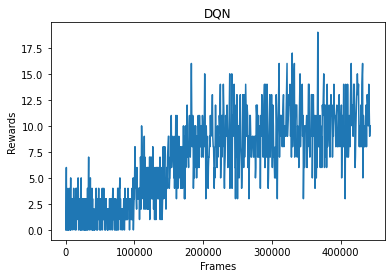

Episode:  901
Steps:  110221  epsilon:  0.03392080139927193
Episode:  902
Steps:  110373  epsilon:  0.033891116255069784
Steps:  110573  epsilon:  0.03385239900143053
Episode:  903
Steps:  110585  epsilon:  0.033850088255322826
Episode:  904
Steps:  110723  epsilon:  0.033823614087277035
Episode:  905
Steps:  110887  epsilon:  0.033792388651016365
Episode:  906
Steps:  111011  epsilon:  0.033768948580684396
Steps:  111211  epsilon:  0.03373144691571575
Episode:  907
Steps:  111212  epsilon:  0.0337312603480342
Steps:  111412  epsilon:  0.03369413368724612
Episode:  908
Steps:  111463  epsilon:  0.03368472564669333
Episode:  909
Steps:  111619  epsilon:  0.03365609658513838
Episode:  910
Steps:  111781  epsilon:  0.03362660181786867
Steps:  111981  epsilon:  0.0335905165268553


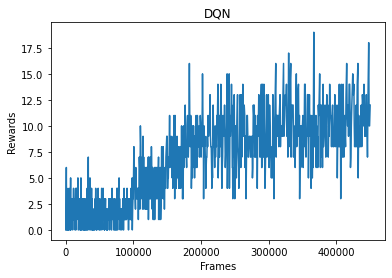

Episode:  911
Steps:  111997  epsilon:  0.03358764526229278
Episode:  912
Steps:  112158  epsilon:  0.0335588806508272
Episode:  913
Steps:  112318  epsilon:  0.03353052318671667
Episode:  914
Steps:  112503  epsilon:  0.03349801642280231
Steps:  112703  epsilon:  0.033463210577847284
Episode:  915
Steps:  112730  epsilon:  0.03345853839799818
Episode:  916
Steps:  112854  epsilon:  0.03343716179587352
Episode:  917
Steps:  112995  epsilon:  0.033413015022601224
Episode:  918
Steps:  113174  epsilon:  0.03338260482676941
Episode:  919
Steps:  113332  epsilon:  0.03335598752541031
Episode:  920
Steps:  113516  epsilon:  0.03332525403102399


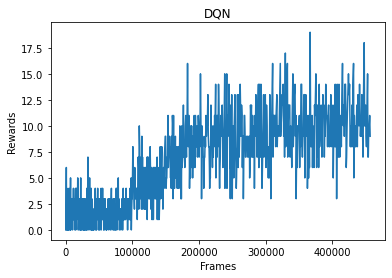

Episode:  921
Steps:  113694  epsilon:  0.03329579057700136
Episode:  922
Steps:  113894  epsilon:  0.03326299691283228
Episode:  923
Steps:  114055  epsilon:  0.03323683522973682
Episode:  924
Steps:  114246  epsilon:  0.03320607058827316
Steps:  114446  epsilon:  0.03317416965290793
Episode:  925
Steps:  114452  epsilon:  0.03317321754483541
Steps:  114652  epsilon:  0.033141643502714244
Episode:  926
Steps:  114656  epsilon:  0.03314101523684238
Episode:  927
Steps:  114806  epsilon:  0.033117545743180446
Episode:  928
Steps:  114919  epsilon:  0.03309998127607616
Episode:  929
Steps:  115090  epsilon:  0.033073589422117064
Episode:  930
Steps:  115228  epsilon:  0.03305245465390691


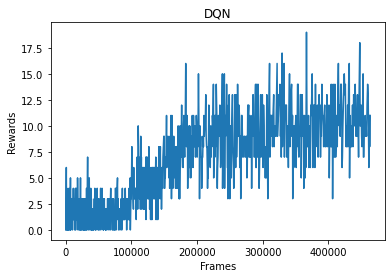

Episode:  931
Steps:  115411  epsilon:  0.033024652084553234
Episode:  932
Steps:  115546  epsilon:  0.033004304433562025
Steps:  115746  epsilon:  0.03297441110497997
Episode:  933
Steps:  115766  epsilon:  0.032971438180584935
Episode:  934
Steps:  115946  epsilon:  0.0329448152199871
Steps:  116146  epsilon:  0.032915513818970246
Episode:  935
Steps:  116147  epsilon:  0.03291536804692363
Episode:  936
Steps:  116332  epsilon:  0.032888525231903644
Steps:  116532  epsilon:  0.03285978392562648
Episode:  937
Steps:  116536  epsilon:  0.03285921202603322
Episode:  938
Steps:  116699  epsilon:  0.032836004148581954
Episode:  939
Steps:  116806  epsilon:  0.03282087204086839
Episode:  940
Steps:  116969  epsilon:  0.032797975364429535


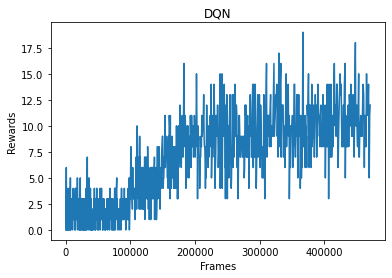

Episode:  941
Steps:  117157  epsilon:  0.03277179762413841
Episode:  942
Steps:  117329  epsilon:  0.032748062372441204
Episode:  943
Steps:  117498  epsilon:  0.03272493907889755
Episode:  944
Steps:  117666  epsilon:  0.03270214545786946
Steps:  117866  epsilon:  0.03267525866132973
Episode:  945
Steps:  117881  epsilon:  0.03267325296956216
Episode:  946
Steps:  118047  epsilon:  0.03265115679588586
Episode:  947
Steps:  118223  epsilon:  0.03262792896841963
Episode:  948
Steps:  118417  epsilon:  0.032602561289571806
Episode:  949
Steps:  118565  epsilon:  0.032583373418711724
Episode:  950
Steps:  118691  epsilon:  0.03256714932572789


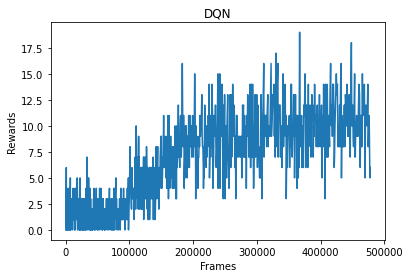

Episode:  951
Steps:  118801  epsilon:  0.0325530687614828
Episode:  952
Steps:  118944  epsilon:  0.032534879424209254
Episode:  953
Steps:  119081  epsilon:  0.03251757483603242
Steps:  119281  epsilon:  0.032492524547864984
Episode:  954
Steps:  119327  epsilon:  0.0324867983290808
Episode:  955
Steps:  119492  epsilon:  0.03246636663947138
Episode:  956
Steps:  119650  epsilon:  0.03244695910372103
Episode:  957
Steps:  119833  epsilon:  0.032424671548982174
Episode:  958
Steps:  119999  epsilon:  0.03240463006234985
Episode:  959
Steps:  120180  epsilon:  0.03238296633650428
Steps:  120380  epsilon:  0.03235925542528592
Episode:  960
Steps:  120384  epsilon:  0.03235878362138283


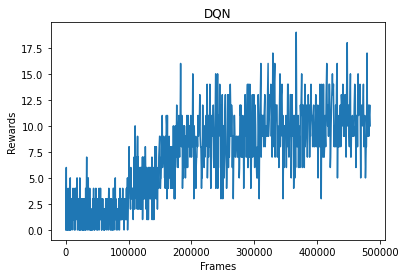

Episode:  961
Steps:  120553  epsilon:  0.03233893587461035
Episode:  962
Steps:  120676  epsilon:  0.032324595560645784
Episode:  963
Steps:  120828  epsilon:  0.032306995598953704
Episode:  964
Steps:  120961  epsilon:  0.032291704975891435
Episode:  965
Steps:  121142  epsilon:  0.0322710586115737
Steps:  121342  epsilon:  0.032248461200823156
Episode:  966
Steps:  121406  epsilon:  0.032241277624832095
Episode:  967
Steps:  121487  epsilon:  0.03223221880694002
Episode:  968
Steps:  121652  epsilon:  0.032213878758504906
Episode:  969
Steps:  121729  epsilon:  0.03220537171185743
Episode:  970
Steps:  121906  epsilon:  0.03218594028310606


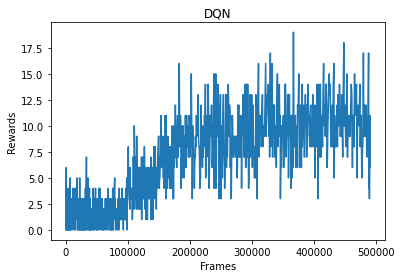

Episode:  971
Steps:  122029  epsilon:  0.0321725380046136
Episode:  972
Steps:  122206  epsilon:  0.03215339587214708
Episode:  973
Steps:  122385  epsilon:  0.03213420896856131
Episode:  974
Steps:  122529  epsilon:  0.0321188978501579
Episode:  975
Steps:  122675  epsilon:  0.03210348621675411
Episode:  976
Steps:  122831  epsilon:  0.03208714284626912
Episode:  977
Steps:  123030  epsilon:  0.03206647874931392
Episode:  978
Steps:  123166  epsilon:  0.03205247436269661
Steps:  123366  epsilon:  0.03203205190156221
Episode:  979
Steps:  123468  epsilon:  0.03202171481883082
Episode:  980
Steps:  123609  epsilon:  0.03200751185363723


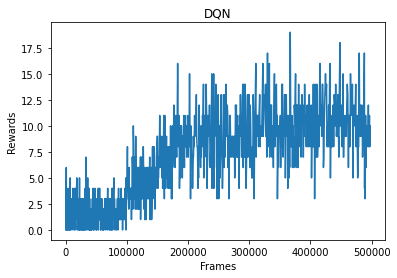

Episode:  981
Steps:  123759  epsilon:  0.03199251183511692
Episode:  982
Steps:  123946  epsilon:  0.0319739686738282
Episode:  983
Steps:  124126  epsilon:  0.03195628266219651
Episode:  984
Steps:  124263  epsilon:  0.031942927918178515
Episode:  985
Steps:  124406  epsilon:  0.031929085529075994
Episode:  986
Steps:  124593  epsilon:  0.03191113263992625
Episode:  987
Steps:  124787  epsilon:  0.03189268427255108
Steps:  124987  epsilon:  0.031873851749378866
Episode:  988
Steps:  124990  epsilon:  0.03187357069269624
Episode:  989
Steps:  125071  epsilon:  0.031865998076289856
Steps:  125271  epsilon:  0.031847431085207045
Episode:  990
Steps:  125272  epsilon:  0.03184733871596203


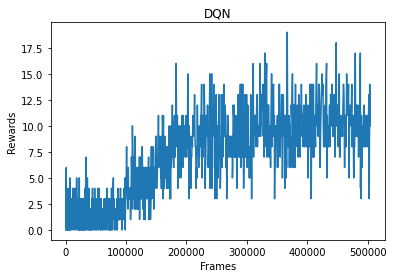

Episode:  991
Steps:  125463  epsilon:  0.031829780604651206
Episode:  992
Steps:  125625  epsilon:  0.03181501924596385
Steps:  125825  epsilon:  0.031796959502718054
Episode:  993
Steps:  125889  epsilon:  0.03179121842293606
Episode:  994
Steps:  126005  epsilon:  0.03178085942621323
Episode:  995
Steps:  126194  epsilon:  0.03176410957234518
Episode:  996
Steps:  126380  epsilon:  0.03174777940629401
Episode:  997
Steps:  126542  epsilon:  0.03173367957451249
Steps:  126742  epsilon:  0.031716429174520416
Episode:  998
Steps:  126764  epsilon:  0.03171454214048744
Episode:  999
Steps:  126951  epsilon:  0.03169858588322109
Episode:  1000
Steps:  127124  epsilon:  0.03168395647872295


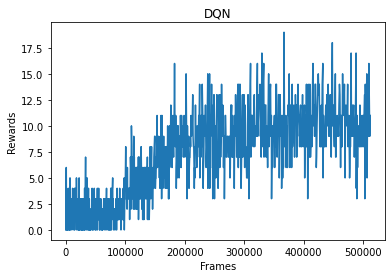

Episode:  1001
Steps:  127300  epsilon:  0.03166920267366355
Episode:  1002
Steps:  127447  epsilon:  0.03165697901100176
Episode:  1003
Steps:  127623  epsilon:  0.03164246156614809
Episode:  1004
Steps:  127719  epsilon:  0.03163459664155026
Episode:  1005
Steps:  127858  epsilon:  0.031623275581145985
Steps:  128058  epsilon:  0.031607123719242666
Episode:  1006
Steps:  128065  epsilon:  0.031606561324365776
Episode:  1007
Steps:  128235  epsilon:  0.0315929634260471
Episode:  1008
Steps:  128408  epsilon:  0.03157924371570417
Episode:  1009
Steps:  128579  epsilon:  0.031565798741106314
Episode:  1010
Steps:  128727  epsilon:  0.03155425459643713
Steps:  128927  epsilon:  0.031538789504806465


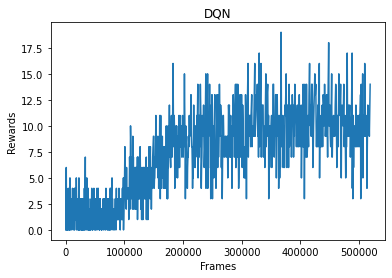

Episode:  1011
Steps:  129068  epsilon:  0.03152797918993244
Steps:  129268  epsilon:  0.031512775542964805
Episode:  1012
Steps:  129272  epsilon:  0.03151247301810971
Steps:  129472  epsilon:  0.031497423660129614
Episode:  1013
Steps:  129485  epsilon:  0.03149645065101275
Steps:  129685  epsilon:  0.03148156071824901
Episode:  1014
Steps:  129689  epsilon:  0.0314812644357346
Episode:  1015
Steps:  129818  epsilon:  0.031471741026136514
Episode:  1016
Steps:  130006  epsilon:  0.03145797147875315
Steps:  130206  epsilon:  0.031443464420150585
Episode:  1017
Steps:  130217  epsilon:  0.031442670733003476
Steps:  130417  epsilon:  0.03142831591936488
Episode:  1018
Steps:  130489  epsilon:  0.03142318322644573
Episode:  1019
Steps:  130677  epsilon:  0.03140986798380199
Steps:  130877  epsilon:  0.031395839562971435
Episode:  1020
Steps:  130885  epsilon:  0.03139528133879852


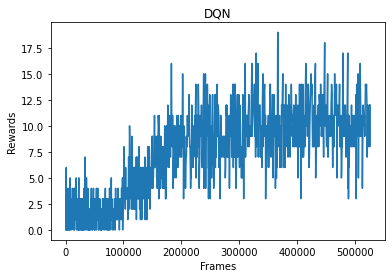

Episode:  1021
Steps:  131071  epsilon:  0.03138236537467256
Episode:  1022
Steps:  131254  epsilon:  0.03136977442294384
Steps:  131454  epsilon:  0.03135614493970941
Episode:  1023
Steps:  131599  epsilon:  0.03134634844410374
Episode:  1024
Steps:  131723  epsilon:  0.031338026907171426
Episode:  1025
Steps:  131865  epsilon:  0.03132856056142442
Steps:  132065  epsilon:  0.03131534116296395
Steps:  132265  epsilon:  0.03130225329971589
Episode:  1026
Steps:  132305  epsilon:  0.03129965139588759
Episode:  1027
Steps:  132495  epsilon:  0.03128736316912137
Episode:  1028
Steps:  132628  epsilon:  0.031278830606262464
Episode:  1029
Steps:  132780  epsilon:  0.03126914833289762
Steps:  132980  epsilon:  0.031256520095988324
Episode:  1030
Steps:  132999  epsilon:  0.03125532696872232


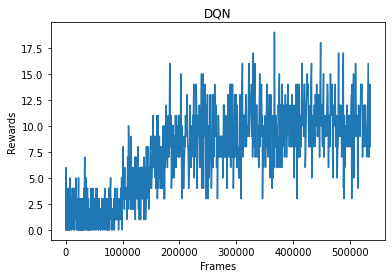

Episode:  1031
Steps:  133157  epsilon:  0.031245448955196688
Episode:  1032
Steps:  133308  epsilon:  0.031236081223271605
Episode:  1033
Steps:  133439  epsilon:  0.031228011348949043
Episode:  1034
Steps:  133573  epsilon:  0.031219811174172052
Episode:  1035
Steps:  133757  epsilon:  0.03120864037583328
Episode:  1036
Steps:  133951  epsilon:  0.031196973241270243
Steps:  134151  epsilon:  0.031185063158521806
Episode:  1037
Steps:  134188  epsilon:  0.031182872818367888
Episode:  1038
Steps:  134347  epsilon:  0.03117350626086039
Steps:  134547  epsilon:  0.031161829678468436
Episode:  1039
Steps:  134596  epsilon:  0.031158986679851588
Episode:  1040
Steps:  134736  epsilon:  0.031150902102126662


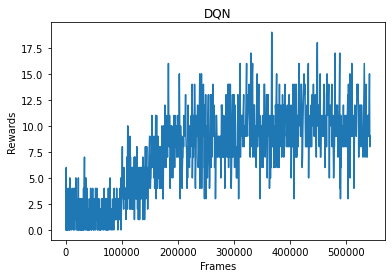

Episode:  1041
Steps:  134904  epsilon:  0.0311412750148426
Episode:  1042
Steps:  135056  epsilon:  0.031132634201411907
Episode:  1043
Steps:  135178  epsilon:  0.03112574616266013
Steps:  135378  epsilon:  0.031114544801185428
Episode:  1044
Steps:  135392  epsilon:  0.031113764892824372
Steps:  135592  epsilon:  0.031102682746976428
Episode:  1045
Steps:  135640  epsilon:  0.03110003948157094
Episode:  1046
Steps:  135797  epsilon:  0.03109143797671763
Steps:  135997  epsilon:  0.03108057798739682
Episode:  1047
Steps:  136015  epsilon:  0.031079605904710986
Steps:  136215  epsilon:  0.03106886364647373
Episode:  1048
Steps:  136239  epsilon:  0.03106758177937205
Episode:  1049
Steps:  136436  epsilon:  0.0310571177189468
Episode:  1050
Steps:  136575  epsilon:  0.031049796222470897
Steps:  136775  epsilon:  0.031039350575527817


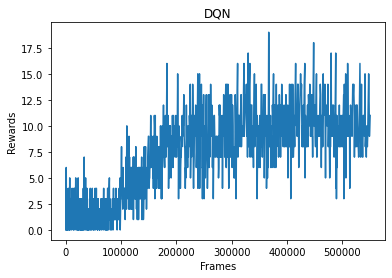

Episode:  1051
Steps:  136906  epsilon:  0.031032565076028525
Episode:  1052
Steps:  137017  epsilon:  0.031026850213270056
Steps:  137217  epsilon:  0.031016632882933316
Episode:  1053
Steps:  137234  epsilon:  0.031015769112137416
Episode:  1054
Steps:  137417  epsilon:  0.031006517216732067
Steps:  137617  epsilon:  0.030996502203091258
Episode:  1055
Steps:  137708  epsilon:  0.03099197841748392
Episode:  1056
Steps:  137853  epsilon:  0.030984812581500428
Episode:  1057
Steps:  138010  epsilon:  0.030977112066799557
Episode:  1058
Steps:  138169  epsilon:  0.03096937482216697
Episode:  1059
Steps:  138336  epsilon:  0.030961314242157013
Episode:  1060
Steps:  138486  epsilon:  0.030954131354838037
Steps:  138686  epsilon:  0.030944637589232264


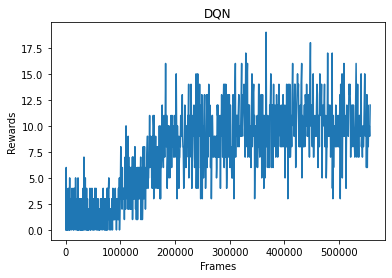

Episode:  1061
Steps:  138716  epsilon:  0.030943221695034544
Episode:  1062
Steps:  138898  epsilon:  0.030934677313508945
Steps:  139098  epsilon:  0.03092537711884865
Episode:  1063
Steps:  139242  epsilon:  0.03091873833190547
Steps:  139442  epsilon:  0.030909596732761998
Steps:  139642  epsilon:  0.0309005460940498
Episode:  1064
Steps:  139649  epsilon:  0.0309002309580689
Episode:  1065
Steps:  139741  epsilon:  0.03089609940551795
Episode:  1066
Steps:  139870  epsilon:  0.030890338164328682
Episode:  1067
Steps:  140045  epsilon:  0.030882581689456238
Episode:  1068
Steps:  140174  epsilon:  0.030876907356953753
Episode:  1069
Steps:  140353  epsilon:  0.030869094052800465
Steps:  140553  epsilon:  0.030860446422487493
Episode:  1070
Steps:  140651  epsilon:  0.030856240547825476


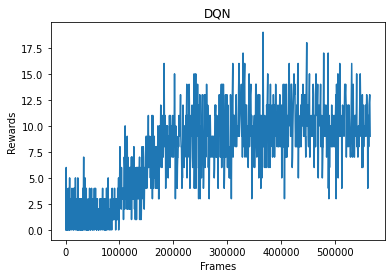

Episode:  1071
Steps:  140850  epsilon:  0.03084776319912418
Episode:  1072
Steps:  141038  epsilon:  0.030839831562149395
Episode:  1073
Steps:  141129  epsilon:  0.030836019008678207
Episode:  1074
Steps:  141289  epsilon:  0.030829357538019225
Episode:  1075
Steps:  141467  epsilon:  0.030822009005407353
Episode:  1076
Steps:  141573  epsilon:  0.030817663882425798
Episode:  1077
Steps:  141740  epsilon:  0.030810864814619587
Episode:  1078
Steps:  141900  epsilon:  0.030804403774721066
Episode:  1079
Steps:  142056  epsilon:  0.030798153831743037
Episode:  1080
Steps:  142249  epsilon:  0.03079048869105354


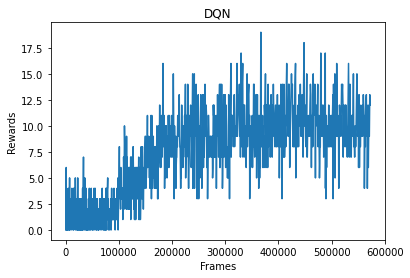

Episode:  1081
Steps:  142438  epsilon:  0.030783053758310055
Steps:  142638  epsilon:  0.03077526224323153
Episode:  1082
Steps:  142743  epsilon:  0.030771202781864723
Steps:  142943  epsilon:  0.030763529185972065
Episode:  1083
Steps:  142977  epsilon:  0.030762232289030647
Episode:  1084
Steps:  143111  epsilon:  0.030757142402853238
Episode:  1085
Steps:  143198  epsilon:  0.030753855986538577
Episode:  1086
Steps:  143307  epsilon:  0.030749758646804484
Steps:  143507  epsilon:  0.03074229842362078
Episode:  1087
Steps:  143521  epsilon:  0.03074177899654493
Episode:  1088
Steps:  143713  epsilon:  0.030734691990236505
Episode:  1089
Steps:  143874  epsilon:  0.03072880146090571
Steps:  144074  epsilon:  0.030721549765205847
Steps:  144274  epsilon:  0.0307143702250838
Episode:  1090
Steps:  144382  epsilon:  0.03071052302266358


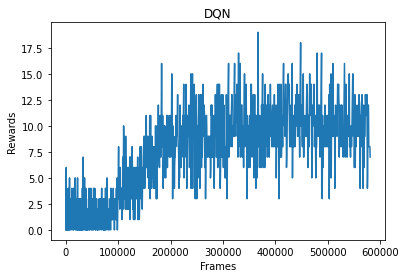

Episode:  1091
Steps:  144512  epsilon:  0.03070591960034667
Episode:  1092
Steps:  144665  epsilon:  0.030700539918921476
Episode:  1093
Steps:  144817  epsilon:  0.030695235995974395
Episode:  1094
Steps:  144982  epsilon:  0.030689523893827255
Episode:  1095
Steps:  145178  epsilon:  0.030682799562707214
Episode:  1096
Steps:  145305  epsilon:  0.030678477522484676
Episode:  1097
Steps:  145449  epsilon:  0.0306736100283293
Steps:  145649  epsilon:  0.0306669074965592
Episode:  1098
Steps:  145660  epsilon:  0.03066654079828736
Episode:  1099
Steps:  145859  epsilon:  0.030659941602786664
Episode:  1100
Steps:  146049  epsilon:  0.030653701843345656


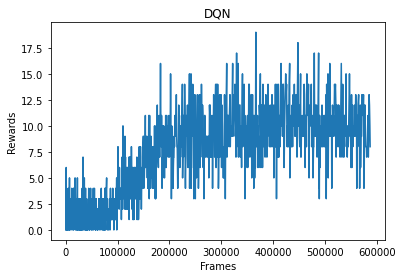

Episode:  1101
Steps:  146183  epsilon:  0.030649336680619706
Episode:  1102
Steps:  146333  epsilon:  0.030644484872538194
Episode:  1103
Steps:  146498  epsilon:  0.030639189744775044
Episode:  1104
Steps:  146628  epsilon:  0.030635048485108597
Episode:  1105
Steps:  146779  epsilon:  0.030630271923256663
Episode:  1106
Steps:  146924  epsilon:  0.03062571897618901
Episode:  1107
Steps:  147121  epsilon:  0.030619585899264525
Episode:  1108
Steps:  147296  epsilon:  0.03061418817214071
Steps:  147496  epsilon:  0.030608076897718613
Episode:  1109
Steps:  147498  epsilon:  0.030608016093069124
Episode:  1110
Steps:  147640  epsilon:  0.030603714467648972


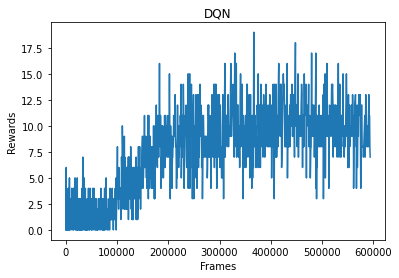

Episode:  1111
Steps:  147782  epsilon:  0.03059944327560298
Episode:  1112
Steps:  147912  epsilon:  0.030595559530158266
Episode:  1113
Steps:  148110  epsilon:  0.03058969258013057
Episode:  1114
Steps:  148307  epsilon:  0.030583912621245886
Episode:  1115
Steps:  148502  epsilon:  0.03057824713730414
Steps:  148702  epsilon:  0.030572493482153896
Episode:  1116
Steps:  148715  epsilon:  0.030572121482303545
Episode:  1117
Steps:  148871  epsilon:  0.030567676293514937
Episode:  1118
Steps:  149004  epsilon:  0.030563913770418033
Episode:  1119
Steps:  149164  epsilon:  0.030559420457470787
Steps:  149364  epsilon:  0.030553854130914836
Episode:  1120
Steps:  149372  epsilon:  0.030553632633564892


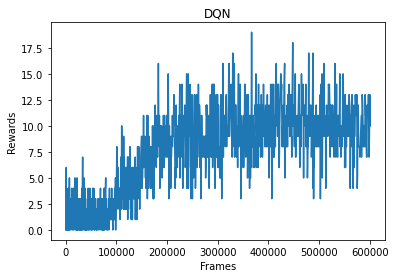

Episode:  1121
Steps:  149544  epsilon:  0.030548891807686766
Episode:  1122
Steps:  149736  epsilon:  0.030543647658523958
Episode:  1123
Steps:  149911  epsilon:  0.03053891149245611
Episode:  1124
Steps:  150092  epsilon:  0.030534056346123873
Episode:  1125
Steps:  150228  epsilon:  0.030530437082413067
Episode:  1126
Steps:  150415  epsilon:  0.030525500609665777
Episode:  1127
Steps:  150594  epsilon:  0.030520818363515716
Episode:  1128
Steps:  150785  epsilon:  0.030515868222688636
Episode:  1129
Steps:  150885  epsilon:  0.030513295319194143
Steps:  151085  epsilon:  0.030508187945432388
Steps:  151285  epsilon:  0.030503131390888664
Episode:  1130
Steps:  151330  epsilon:  0.030502000617855872


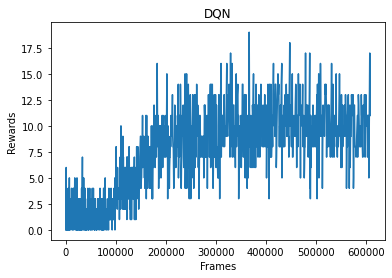

Episode:  1131
Steps:  151526  epsilon:  0.030497105039316613
Steps:  151726  epsilon:  0.030492158761531284
Episode:  1132
Steps:  151763  epsilon:  0.030491249109510014
Episode:  1133
Steps:  151947  epsilon:  0.03048675034375624
Episode:  1134
Steps:  152076  epsilon:  0.03048362090732087
Episode:  1135
Steps:  152253  epsilon:  0.030479359745743097
Episode:  1136
Steps:  152342  epsilon:  0.03047723133410276
Episode:  1137
Steps:  152502  epsilon:  0.030473428714190207
Episode:  1138
Steps:  152661  epsilon:  0.03046967987728373
Episode:  1139
Steps:  152835  epsilon:  0.03046561138595064
Episode:  1140
Steps:  152993  epsilon:  0.03046194754721961
Steps:  153193  epsilon:  0.030457351092325613
Steps:  153393  epsilon:  0.030452800372921973


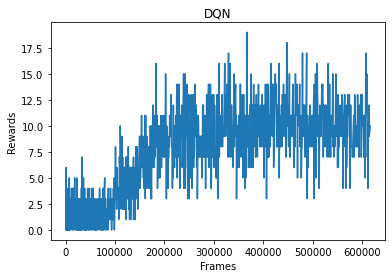

Episode:  1141
Steps:  153467  epsilon:  0.03045112810714163
Episode:  1142
Steps:  153560  epsilon:  0.030449035231151198
Episode:  1143
Steps:  153715  epsilon:  0.030445568658429973
Episode:  1144
Steps:  153846  epsilon:  0.03044265972088776
Episode:  1145
Steps:  154033  epsilon:  0.030438540141542847
Steps:  154233  epsilon:  0.03043417659422683
Episode:  1146
Steps:  154253  epsilon:  0.030433742634648556
Episode:  1147
Steps:  154403  epsilon:  0.03043050173345986
Episode:  1148
Steps:  154551  epsilon:  0.03042732777874849
Episode:  1149
Steps:  154723  epsilon:  0.030423668517229007
Steps:  154923  epsilon:  0.030419452945047335
Episode:  1150
Steps:  154931  epsilon:  0.030419285197421077


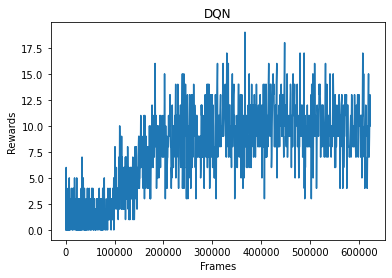

Episode:  1151
Steps:  155081  epsilon:  0.030416152321410803
Episode:  1152
Steps:  155235  epsilon:  0.030412960253767822
Episode:  1153
Steps:  155317  epsilon:  0.03041127058291956
Episode:  1154
Steps:  155407  epsilon:  0.03040942402317192
Steps:  155607  epsilon:  0.030405350186074275
Episode:  1155
Steps:  155682  epsilon:  0.030403832969435683
Episode:  1156
Steps:  155843  epsilon:  0.03040059516368468
Episode:  1157
Steps:  155964  epsilon:  0.030398178879573988
Episode:  1158
Steps:  156135  epsilon:  0.030394788962699194
Steps:  156335  epsilon:  0.030390860746886343
Episode:  1159
Steps:  156350  epsilon:  0.03039056771122829
Episode:  1160
Steps:  156442  epsilon:  0.030388775225634254


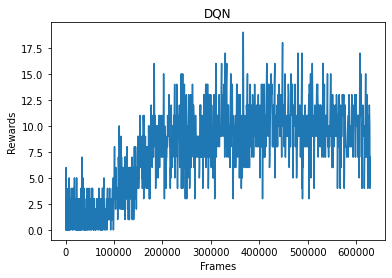

Episode:  1161
Steps:  156566  epsilon:  0.030386372276076393
Steps:  156766  epsilon:  0.03038252780769472
Episode:  1162
Steps:  156775  epsilon:  0.030382355708906388
Steps:  156975  epsilon:  0.030378551206035817
Steps:  157175  epsilon:  0.030374784558601306
Episode:  1163
Steps:  157186  epsilon:  0.03037457848376985
Episode:  1164
Steps:  157379  epsilon:  0.030370981186277606
Episode:  1165
Steps:  157553  epsilon:  0.030367767649113017
Steps:  157753  epsilon:  0.030364108299862663
Episode:  1166
Steps:  157762  epsilon:  0.03036394448798816
Episode:  1167
Steps:  157941  epsilon:  0.030360701717863113
Episode:  1168
Steps:  158121  epsilon:  0.03035746996709509
Episode:  1169
Steps:  158254  epsilon:  0.030355100678430037
Episode:  1170
Steps:  158432  epsilon:  0.030351954304524552


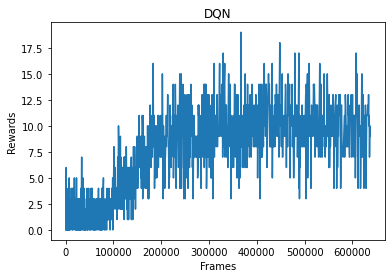

Episode:  1171
Steps:  158592  epsilon:  0.030349149902652636
Episode:  1172
Steps:  158740  epsilon:  0.030346575729560246
Steps:  158940  epsilon:  0.03034312724343262
Steps:  159140  epsilon:  0.030339713070315275
Episode:  1173
Steps:  159147  epsilon:  0.030339594191545662
Episode:  1174
Steps:  159320  epsilon:  0.03033666936987935
Episode:  1175
Steps:  159493  epsilon:  0.03033376973881403
Steps:  159693  epsilon:  0.030330448674423336
Episode:  1176
Steps:  159822  epsilon:  0.03032832413946404
Steps:  160022  epsilon:  0.03032505725969221
Episode:  1177
Steps:  160172  epsilon:  0.03032262844966715
Episode:  1178
Steps:  160353  epsilon:  0.030319721834469657
Steps:  160553  epsilon:  0.030316540549062666
Episode:  1179
Steps:  160593  epsilon:  0.030315908100623793
Episode:  1180
Steps:  160711  epsilon:  0.030314049730413056


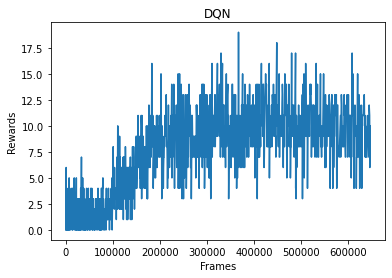

Episode:  1181
Steps:  160883  epsilon:  0.030311360483069785
Steps:  161083  epsilon:  0.030308262394499304
Episode:  1182
Steps:  161085  epsilon:  0.030308231569801114
Episode:  1183
Steps:  161250  epsilon:  0.03030569912006912
Episode:  1184
Steps:  161392  epsilon:  0.03030353634325976
Episode:  1185
Steps:  161568  epsilon:  0.030300876941966745
Episode:  1186
Steps:  161683  epsilon:  0.030299151863902817
Steps:  161883  epsilon:  0.030296175253122736
Steps:  162083  epsilon:  0.030293228260114782
Steps:  162283  epsilon:  0.0302903105901772
Steps:  162483  epsilon:  0.03028742195154056
Episode:  1187
Steps:  162560  epsilon:  0.030286317504451994
Episode:  1188
Steps:  162703  epsilon:  0.030284277635516867
Steps:  162903  epsilon:  0.03028144902578208
Episode:  1189
Steps:  163006  epsilon:  0.030280003289266208
Steps:  163206  epsilon:  0.030277217209987228
Episode:  1190
Steps:  163341  epsilon:  0.03027535229498878


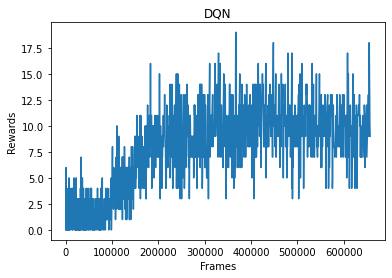

Episode:  1191
Steps:  163500  epsilon:  0.030273171922707173
Steps:  163700  epsilon:  0.03027045381666118
Episode:  1192
Steps:  163735  epsilon:  0.030269980936372957
Episode:  1193
Steps:  163926  epsilon:  0.03026741489080065
Episode:  1194
Steps:  164040  epsilon:  0.030265894961835845
Episode:  1195
Steps:  164196  epsilon:  0.030263829048669044
Episode:  1196
Steps:  164326  epsilon:  0.030262119721185272
Episode:  1197
Steps:  164506  epsilon:  0.030259771227767292
Episode:  1198
Steps:  164650  epsilon:  0.03025790759206679
Episode:  1199
Steps:  164799  epsilon:  0.030255993320023152
Episode:  1200
Steps:  164967  epsilon:  0.03025385198234426


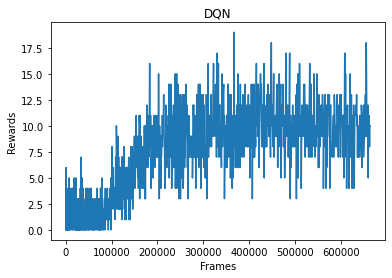

Episode:  1201
Steps:  165121  epsilon:  0.03025190482824405
Steps:  165321  epsilon:  0.030249398333323636
Episode:  1202
Steps:  165378  epsilon:  0.030248688559981102
Episode:  1203
Steps:  165556  epsilon:  0.030246485051952966
Steps:  165756  epsilon:  0.03024403248470769
Episode:  1204
Steps:  165782  epsilon:  0.030243715448595693
Steps:  165982  epsilon:  0.030241290439364268
Episode:  1205
Steps:  165984  epsilon:  0.030241266311526745
Episode:  1206
Steps:  166127  epsilon:  0.03023954740979589
Episode:  1207
Steps:  166264  epsilon:  0.030237912117309883
Episode:  1208
Steps:  166461  epsilon:  0.030235580186567402
Episode:  1209
Steps:  166571  epsilon:  0.030234288052168132
Steps:  166771  epsilon:  0.030231956847098475
Episode:  1210
Steps:  166894  epsilon:  0.030230534690104036
Steps:  167094  epsilon:  0.030228240831610916


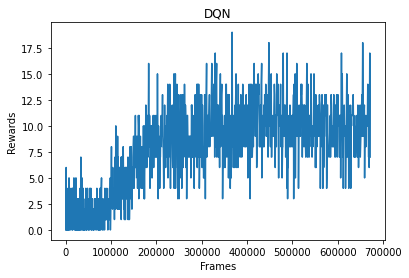

Episode:  1211
Steps:  167098  epsilon:  0.030228195188009108
Episode:  1212
Steps:  167240  epsilon:  0.030226580740245822
Episode:  1213
Steps:  167380  epsilon:  0.030225000213362007
Steps:  167580  epsilon:  0.030222761423832584
Episode:  1214
Steps:  167626  epsilon:  0.03022224966131027
Steps:  167826  epsilon:  0.03022003824023104
Episode:  1215
Steps:  167840  epsilon:  0.03021988426735967
Steps:  168040  epsilon:  0.030217696382343503
Episode:  1216
Steps:  168120  epsilon:  0.030216827336065413
Steps:  168320  epsilon:  0.030214669868023836
Steps:  168520  epsilon:  0.030212533867147954
Episode:  1217
Steps:  168576  epsilon:  0.030211939604675653
Episode:  1218
Steps:  168754  epsilon:  0.030210061711215583
Episode:  1219
Steps:  168917  epsilon:  0.03020835666576715
Episode:  1220
Steps:  169110  epsilon:  0.03020635569415844


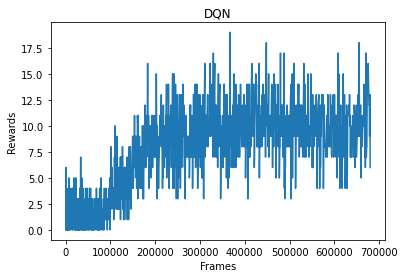

Episode:  1221
Steps:  169230  epsilon:  0.03020512126697831
Steps:  169430  epsilon:  0.030203080276270295
Episode:  1222
Steps:  169455  epsilon:  0.030202826584515337
Steps:  169655  epsilon:  0.03020080842627932
Episode:  1223
Steps:  169756  epsilon:  0.030199796899980216
Steps:  169956  epsilon:  0.030197808887609014
Episode:  1224
Steps:  169970  epsilon:  0.03019767046983956
Steps:  170170  epsilon:  0.030195703615801775
Episode:  1225
Steps:  170200  epsilon:  0.030195410280434598
Episode:  1226
Steps:  170316  epsilon:  0.030194280181263716
Episode:  1227
Steps:  170488  epsilon:  0.030192616535634643
Episode:  1228
Steps:  170656  epsilon:  0.03019100533325915
Episode:  1229
Steps:  170849  epsilon:  0.030189170996701896
Episode:  1230
Steps:  170980  epsilon:  0.030187935975782464


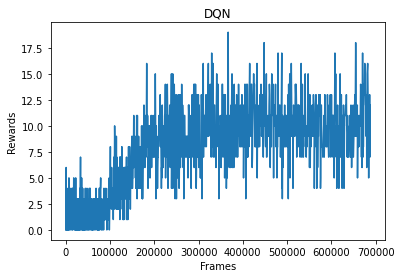

Episode:  1231
Steps:  171152  epsilon:  0.030186326656382913
Episode:  1232
Steps:  171290  epsilon:  0.030185045427775836
Steps:  171490  epsilon:  0.03018320419500551
Episode:  1233
Steps:  171502  epsilon:  0.03018309430545867
Steps:  171702  epsilon:  0.030181272486679775
Steps:  171902  epsilon:  0.030179468795300608
Episode:  1234
Steps:  172026  epsilon:  0.030178359531042285
Steps:  172226  epsilon:  0.030176584824055996
Episode:  1235
Steps:  172324  epsilon:  0.030175721674860666
Episode:  1236
Steps:  172450  epsilon:  0.03017461810819409
Episode:  1237
Steps:  172641  epsilon:  0.030172958442776985
Episode:  1238
Steps:  172735  epsilon:  0.030172147445432604
Steps:  172935  epsilon:  0.030170434549730892
Episode:  1239
Steps:  173030  epsilon:  0.030169626905293748
Episode:  1240
Steps:  173172  epsilon:  0.03016842681961169
Steps:  173372  epsilon:  0.030166750944755454


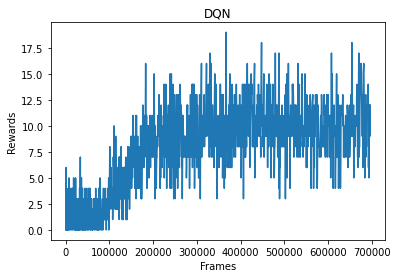

Episode:  1241
Steps:  173395  epsilon:  0.030166559291390792
Episode:  1242
Steps:  173529  epsilon:  0.030165447074226588
Episode:  1243
Steps:  173706  epsilon:  0.030163989327662746
Steps:  173906  epsilon:  0.03016235760658914
Episode:  1244
Steps:  173914  epsilon:  0.03016229267653338
Episode:  1245
Steps:  174064  epsilon:  0.030161080034551067
Episode:  1246
Steps:  174180  epsilon:  0.030160148474486333
Episode:  1247
Steps:  174362  epsilon:  0.030158697734247893
Episode:  1248
Steps:  174540  epsilon:  0.0301572915910321
Episode:  1249
Steps:  174677  epsilon:  0.030156217825479194
Episode:  1250
Steps:  174852  epsilon:  0.030154856882315683


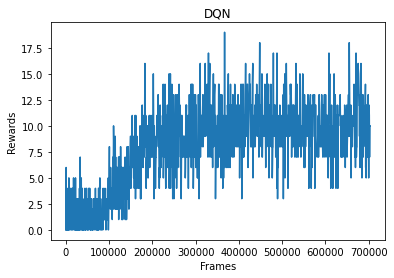

Episode:  1251
Steps:  175025  epsilon:  0.03015352314700498
Episode:  1252
Steps:  175141  epsilon:  0.030152635290026545
Episode:  1253
Steps:  175299  epsilon:  0.030151434221701766
Episode:  1254
Steps:  175459  epsilon:  0.030150227580926663
Steps:  175659  epsilon:  0.03014873279152098
Episode:  1255
Steps:  175705  epsilon:  0.030148391099197286
Episode:  1256
Steps:  175829  epsilon:  0.03014747392057402
Episode:  1257
Steps:  176002  epsilon:  0.03014620377247123
Steps:  176202  epsilon:  0.030144749020628643
Steps:  176402  epsilon:  0.03014330874380874
Episode:  1258
Steps:  176430  epsilon:  0.030143108251944464
Episode:  1259
Steps:  176561  epsilon:  0.030142173956053567
Episode:  1260
Steps:  176693  epsilon:  0.030141238697691197


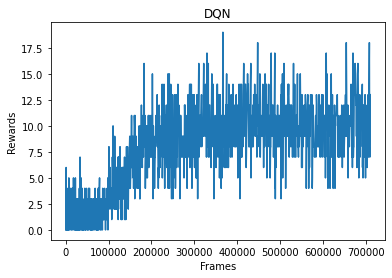

Episode:  1261
Steps:  176884  epsilon:  0.030139896288335494
Episode:  1262
Steps:  176982  epsilon:  0.03013921247323784
Episode:  1263
Steps:  177135  epsilon:  0.030138151560980885
Episode:  1264
Steps:  177328  epsilon:  0.03013682481028537
Episode:  1265
Steps:  177487  epsilon:  0.03013574136544321
Episode:  1266
Steps:  177600  epsilon:  0.03013497658925565
Episode:  1267
Steps:  177800  epsilon:  0.030133633549752587
Steps:  178000  epsilon:  0.03013230387371586
Episode:  1268
Steps:  178088  epsilon:  0.030131723015496707
Episode:  1269
Steps:  178247  epsilon:  0.030130679969126422
Episode:  1270
Steps:  178349  epsilon:  0.030130015197891415
Steps:  178549  epsilon:  0.030128721525057262


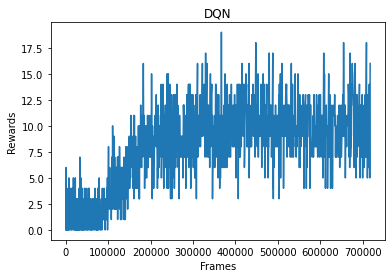

Episode:  1271
Steps:  178599  epsilon:  0.03012840012316438
Episode:  1272
Steps:  178700  epsilon:  0.03012775333705189
Episode:  1273
Steps:  178837  epsilon:  0.03012688121711404
Episode:  1274
Steps:  179027  epsilon:  0.03012568155297856
Episode:  1275
Steps:  179213  epsilon:  0.030124518132824914
Steps:  179413  epsilon:  0.03012327915670206
Steps:  179613  epsilon:  0.030122052508597615
Episode:  1276
Steps:  179624  epsilon:  0.030121985398174945
Steps:  179824  epsilon:  0.03012077162318293
Episode:  1277
Steps:  179868  epsilon:  0.030120506217665044
Steps:  180068  epsilon:  0.030119307160765017
Episode:  1278
Steps:  180088  epsilon:  0.030119187913237953
Episode:  1279
Steps:  180211  epsilon:  0.030118457156950374
Episode:  1280
Steps:  180375  epsilon:  0.030117489779929695
Steps:  180575  epsilon:  0.030116320737086623


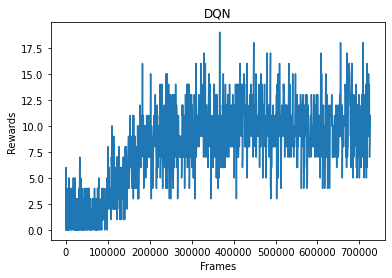

Episode:  1281
Steps:  180583  epsilon:  0.030116274218096206
Steps:  180783  epsilon:  0.030115117270295463
Episode:  1282
Steps:  180826  epsilon:  0.03011487003403854
Steps:  181026  epsilon:  0.03011372705810262
Episode:  1283
Steps:  181118  epsilon:  0.030113205115024785
Episode:  1284
Steps:  181304  epsilon:  0.030112157187869252
Episode:  1285
Steps:  181442  epsilon:  0.030111385967044615
Steps:  181642  epsilon:  0.03011027765815451
Episode:  1286
Steps:  181778  epsilon:  0.03010953031392919
Episode:  1287
Steps:  181966  epsilon:  0.030108505552900736
Steps:  182166  epsilon:  0.030107425904610234
Episode:  1288
Steps:  182192  epsilon:  0.030107286341669807
Episode:  1289
Steps:  182366  epsilon:  0.030106356998999717
Steps:  182566  epsilon:  0.03010529872917773
Steps:  182766  epsilon:  0.030104250989316413
Episode:  1290
Steps:  182809  epsilon:  0.030104027090466893


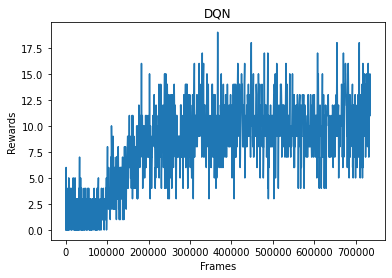

Episode:  1291
Steps:  182974  epsilon:  0.030103172397427037
Steps:  183174  epsilon:  0.03010214581492014
Episode:  1292
Steps:  183253  epsilon:  0.030101743134768075
Steps:  183453  epsilon:  0.03010073077366225
Episode:  1293
Steps:  183457  epsilon:  0.030100710629522
Episode:  1294
Steps:  183621  epsilon:  0.030099888179015453
Episode:  1295
Steps:  183757  epsilon:  0.03009921124358706
Episode:  1296
Steps:  183900  epsilon:  0.030098504413125556
Episode:  1297
Steps:  184082  epsilon:  0.030097612089197756
Steps:  184282  epsilon:  0.030096640832682146
Episode:  1298
Steps:  184284  epsilon:  0.030096631169082066
Episode:  1299
Steps:  184470  epsilon:  0.030095736665100247
Episode:  1300
Steps:  184662  epsilon:  0.030094821990577683


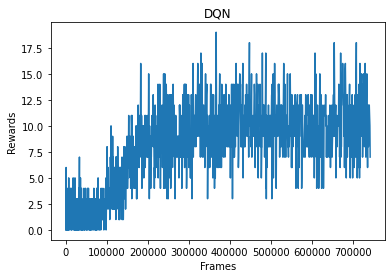

Episode:  1301
Steps:  184829  epsilon:  0.03009403352338803
Episode:  1302
Steps:  184986  epsilon:  0.030093298249953444
Episode:  1303
Steps:  185164  epsilon:  0.03009247157966833
Steps:  185364  epsilon:  0.030091551472077153
Steps:  185564  epsilon:  0.03009064051970948
Steps:  185764  epsilon:  0.03008973863146931
Episode:  1304
Steps:  185836  epsilon:  0.030089416153205168
Episode:  1305
Steps:  186020  epsilon:  0.03008859729710938
Episode:  1306
Steps:  186146  epsilon:  0.03008804088866451
Episode:  1307
Steps:  186293  epsilon:  0.03008739616041164
Episode:  1308
Steps:  186453  epsilon:  0.030086699780362568
Episode:  1309
Steps:  186592  epsilon:  0.030086099305954645
Steps:  186792  epsilon:  0.030085242603546315
Episode:  1310
Steps:  186926  epsilon:  0.03008467338710697
Steps:  187126  epsilon:  0.030083830872828236


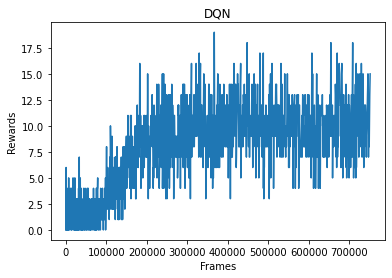

Episode:  1311
Steps:  187180  epsilon:  0.03008360483476031
Steps:  187380  epsilon:  0.03008277295275507
Episode:  1312
Steps:  187389  epsilon:  0.030082735713305834
Steps:  187589  epsilon:  0.03008191247920356
Episode:  1313
Steps:  187625  epsilon:  0.030081765169359627
Episode:  1314
Steps:  187805  epsilon:  0.030081032584412595
Episode:  1315
Steps:  187943  epsilon:  0.030080475384131805
Episode:  1316
Steps:  188077  epsilon:  0.030079938001300866
Episode:  1317
Steps:  188258  epsilon:  0.030079217826097227
Steps:  188458  epsilon:  0.03007842959555753
Episode:  1318
Steps:  188533  epsilon:  0.03007813603534361
Episode:  1319
Steps:  188648  epsilon:  0.03007768804235454
Episode:  1320
Steps:  188772  epsilon:  0.030077207866575018


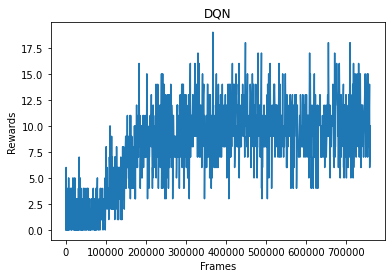

Episode:  1321
Steps:  188939  epsilon:  0.03007656586497595
Episode:  1322
Steps:  189135  epsilon:  0.030075819184210862
Episode:  1323
Steps:  189276  epsilon:  0.030075286538743598
Episode:  1324
Steps:  189457  epsilon:  0.030074608269366223
Episode:  1325
Steps:  189602  epsilon:  0.03007406931548188
Episode:  1326
Steps:  189737  epsilon:  0.030073571031203734
Episode:  1327
Steps:  189875  epsilon:  0.030073065138425642
Episode:  1328
Steps:  189974  epsilon:  0.03007270435965456
Episode:  1329
Steps:  190151  epsilon:  0.030072063764884548
Episode:  1330
Steps:  190279  epsilon:  0.03007160402951171
Steps:  190479  epsilon:  0.03007089155751384


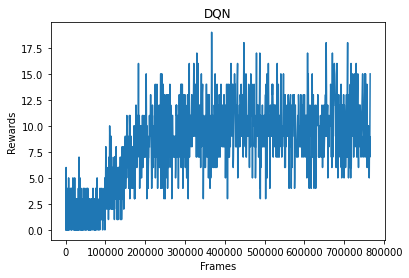

Episode:  1331
Steps:  190548  epsilon:  0.030070647403049038
Episode:  1332
Steps:  190689  epsilon:  0.03007015109041524
Episode:  1333
Steps:  190858  epsilon:  0.030069560811143436
Episode:  1334
Steps:  190986  epsilon:  0.030069117043523226
Steps:  191186  epsilon:  0.030068429317449404
Episode:  1335
Steps:  191250  epsilon:  0.030068210693618255
Steps:  191450  epsilon:  0.03006753198587667
Episode:  1336
Steps:  191469  epsilon:  0.03006746786095425
Episode:  1337
Steps:  191618  epsilon:  0.030066967093066672
Steps:  191818  epsilon:  0.030066300759357324
Steps:  192018  epsilon:  0.030065641055779163
Episode:  1338
Steps:  192048  epsilon:  0.030065542668004774
Episode:  1339
Steps:  192246  epsilon:  0.030064896996936822
Episode:  1340
Steps:  192403  epsilon:  0.03006438954984654


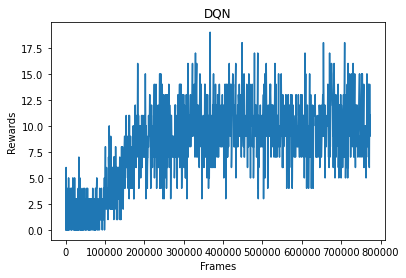

Episode:  1341
Steps:  192577  epsilon:  0.03006383179053395
Episode:  1342
Steps:  192700  epsilon:  0.03006344042969028
Steps:  192900  epsilon:  0.030062809186867837
Episode:  1343
Steps:  192929  epsilon:  0.030062718179543133
Episode:  1344
Steps:  193043  epsilon:  0.03006236170284349
Episode:  1345
Steps:  193233  epsilon:  0.030061772071848215
Episode:  1346
Steps:  193377  epsilon:  0.0300613289102272
Episode:  1347
Steps:  193562  epsilon:  0.030060764233463887
Steps:  193762  epsilon:  0.030060159619238816
Episode:  1348
Steps:  193785  epsilon:  0.030060090475441996
Episode:  1349
Steps:  193913  epsilon:  0.030059707124430905
Episode:  1350
Steps:  194054  epsilon:  0.03005928766951956
Steps:  194254  epsilon:  0.030058697747351214


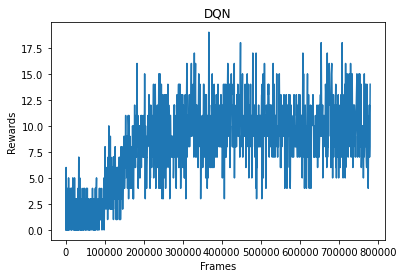

Episode:  1351
Steps:  194288  epsilon:  0.03005859804595092
Episode:  1352
Steps:  194447  epsilon:  0.030058134038359653
Episode:  1353
Steps:  194571  epsilon:  0.030057774722352455
Steps:  194771  epsilon:  0.03005719985425995
Episode:  1354
Steps:  194780  epsilon:  0.03005717412011615
Episode:  1355
Steps:  194964  epsilon:  0.030056650530416746
Steps:  195164  epsilon:  0.030056086848220902
Episode:  1356
Steps:  195167  epsilon:  0.030056078435824616
Episode:  1357
Steps:  195317  epsilon:  0.030055659420826303
Episode:  1358
Steps:  195499  epsilon:  0.030055155217700424
Episode:  1359
Steps:  195668  epsilon:  0.030054691119686443
Episode:  1360
Steps:  195829  epsilon:  0.030054252623488133
Steps:  196029  epsilon:  0.03005371280086488


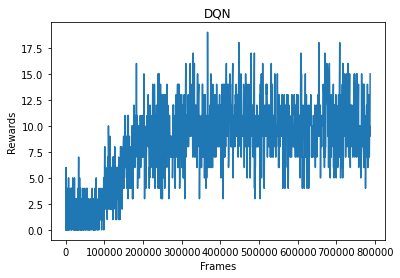

Episode:  1361
Steps:  196038  epsilon:  0.030053688635542097
Episode:  1362
Steps:  196166  epsilon:  0.03005334612547594
Episode:  1363
Steps:  196345  epsilon:  0.03005287080787205
Episode:  1364
Steps:  196484  epsilon:  0.030052504629700424
Episode:  1365
Steps:  196682  epsilon:  0.03005198739838588
Episode:  1366
Steps:  196826  epsilon:  0.030051614433402648
Episode:  1367
Steps:  196949  epsilon:  0.030051297978732756
Episode:  1368
Steps:  197097  epsilon:  0.030050919774770663
Episode:  1369
Steps:  197219  epsilon:  0.0300506101095836
Episode:  1370
Steps:  197373  epsilon:  0.030050221908233043


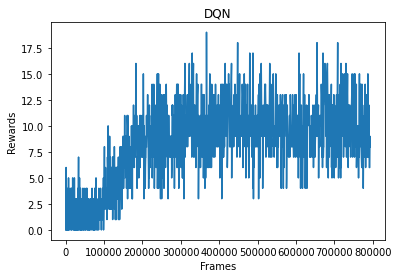

Episode:  1371
Steps:  197511  epsilon:  0.03004987656985377
Episode:  1372
Steps:  197696  epsilon:  0.030049417338800656
Episode:  1373
Steps:  197884  epsilon:  0.030048954992249126
Steps:  198084  epsilon:  0.03004846788193744
Episode:  1374
Steps:  198207  epsilon:  0.030048170719175638
Episode:  1375
Steps:  198396  epsilon:  0.030047717650002945
Steps:  198596  epsilon:  0.03004724285145232
Episode:  1376
Steps:  198609  epsilon:  0.030047212153576766
Steps:  198809  epsilon:  0.030046742384799617
Episode:  1377
Steps:  198816  epsilon:  0.030046726027827573
Episode:  1378
Steps:  198954  epsilon:  0.030046404727994743
Episode:  1379
Steps:  199154  epsilon:  0.03004594299323637
Episode:  1380
Steps:  199289  epsilon:  0.030045633922319872


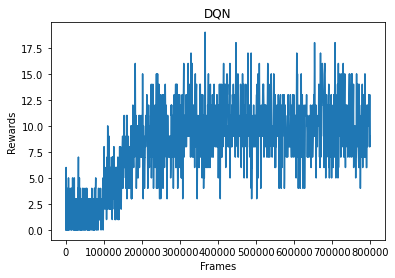

Episode:  1381
Steps:  199447  epsilon:  0.0300452748345976
Episode:  1382
Steps:  199584  epsilon:  0.0300449657617636
Episode:  1383
Steps:  199757  epsilon:  0.030044578485309757
Episode:  1384
Steps:  199947  epsilon:  0.030044156994948484
Steps:  200147  epsilon:  0.03004371762550761
Episode:  1385
Steps:  200163  epsilon:  0.03004368266539311
Episode:  1386
Steps:  200335  epsilon:  0.030043308605234867
Episode:  1387
Steps:  200490  epsilon:  0.030042974260802435
Episode:  1388
Steps:  200641  epsilon:  0.030042651026876872
Episode:  1389
Steps:  200784  epsilon:  0.030042347159654557
Episode:  1390
Steps:  200964  epsilon:  0.03004196774514401


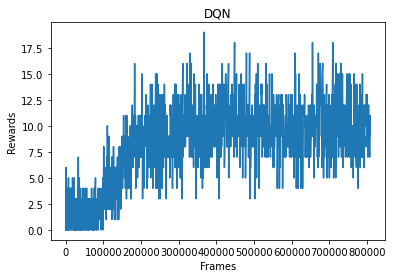

Episode:  1391
Steps:  201129  epsilon:  0.030041622935541894
Steps:  201329  epsilon:  0.030041208780413404
Episode:  1392
Steps:  201371  epsilon:  0.030041122332776324
Episode:  1393
Steps:  201478  epsilon:  0.030040902915759848
Episode:  1394
Steps:  201636  epsilon:  0.030040581055746335
Episode:  1395
Steps:  201787  epsilon:  0.030040275822480946
Episode:  1396
Steps:  201940  epsilon:  0.03003996888796039
Episode:  1397
Steps:  202089  epsilon:  0.03003967222618233
Episode:  1398
Steps:  202200  epsilon:  0.030039452655200104
Episode:  1399
Steps:  202384  epsilon:  0.030039091355300168
Steps:  202584  epsilon:  0.03003870238981596
Episode:  1400
Steps:  202589  epsilon:  0.030038692715427855


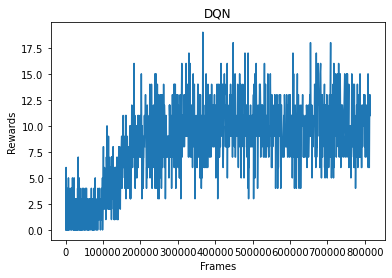

Episode:  1401
Steps:  202782  epsilon:  0.03003832112652404
Steps:  202982  epsilon:  0.030037939824944206
Episode:  1402
Steps:  203001  epsilon:  0.030037903799225437
Episode:  1403
Steps:  203196  epsilon:  0.03003753603295694
Episode:  1404
Steps:  203380  epsilon:  0.03003719228511836
Episode:  1405
Steps:  203524  epsilon:  0.030036925462380036
Steps:  203724  epsilon:  0.030036558047890467
Episode:  1406
Steps:  203764  epsilon:  0.030036485004862064
Episode:  1407
Steps:  203909  epsilon:  0.030036221445135267
Steps:  204109  epsilon:  0.030035861035734326
Episode:  1408
Steps:  204152  epsilon:  0.030035784017331948
Episode:  1409
Steps:  204310  epsilon:  0.0300355024373006
Episode:  1410
Steps:  204466  epsilon:  0.030035226595471306


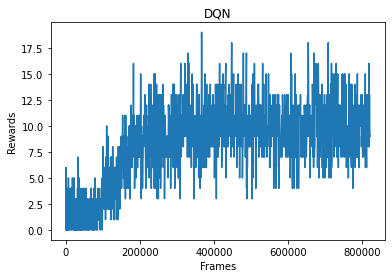

Episode:  1411
Steps:  204630  epsilon:  0.03003493891847607
Steps:  204830  epsilon:  0.03003459127042861
Episode:  1412
Steps:  204994  epsilon:  0.03003430878179736
Episode:  1413
Steps:  205159  epsilon:  0.030034026898714053
Steps:  205359  epsilon:  0.030033688325414847
Steps:  205559  epsilon:  0.030033353120976256
Episode:  1414
Steps:  205565  epsilon:  0.030033343116540705
Episode:  1415
Steps:  205736  epsilon:  0.030033059248160895
Episode:  1416
Steps:  205891  epsilon:  0.030032804029238393
Episode:  1417
Steps:  206075  epsilon:  0.030032503616188342
Episode:  1418
Steps:  206255  epsilon:  0.03003221239609878
Steps:  206455  epsilon:  0.030031891877402263
Episode:  1419
Steps:  206483  epsilon:  0.03003184726001336
Episode:  1420
Steps:  206663  epsilon:  0.030031561920626518
Steps:  206863  epsilon:  0.030031247874269088


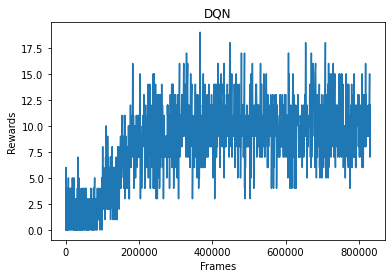

Episode:  1421
Steps:  206873  epsilon:  0.030031232254237285
Episode:  1422
Steps:  207021  epsilon:  0.030031001988589604
Episode:  1423
Steps:  207188  epsilon:  0.03003074419975109
Steps:  207388  epsilon:  0.030030438289852315
Episode:  1424
Steps:  207419  epsilon:  0.030030391147048155
Episode:  1425
Steps:  207549  epsilon:  0.030030194245216555
Episode:  1426
Steps:  207738  epsilon:  0.0300299102535732
Steps:  207938  epsilon:  0.030029612641577542
Episode:  1427
Steps:  207986  epsilon:  0.030029541656453978
Episode:  1428
Steps:  208117  epsilon:  0.030029348790928334
Episode:  1429
Steps:  208248  epsilon:  0.030029157184543694
Episode:  1430
Steps:  208436  epsilon:  0.030028884391146617


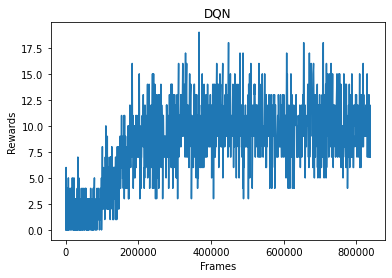

Episode:  1431
Steps:  208572  epsilon:  0.030028688643582817
Steps:  208772  epsilon:  0.030028403186809657
Episode:  1432
Steps:  208799  epsilon:  0.030028364868378225
Episode:  1433
Steps:  208936  epsilon:  0.030028171232988198
Episode:  1434
Steps:  209130  epsilon:  0.030027899293069052
Steps:  209330  epsilon:  0.030027621690464735
Episode:  1435
Steps:  209430  epsilon:  0.030027483926708808
Episode:  1436
Steps:  209523  epsilon:  0.03002735642312519
Steps:  209723  epsilon:  0.030027084222167065
Episode:  1437
Steps:  209843  epsilon:  0.03002692220337649
Steps:  210043  epsilon:  0.030026654322977058
Episode:  1438
Steps:  210194  epsilon:  0.030026453840611842
Steps:  210394  epsilon:  0.03002619062049978
Episode:  1439
Steps:  210523  epsilon:  0.030026022234625773
Episode:  1440
Steps:  210663  epsilon:  0.030025840715043137


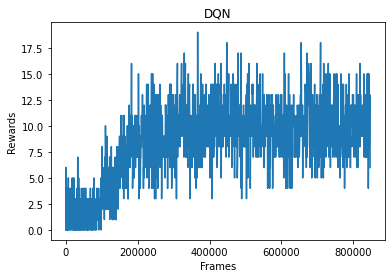

Episode:  1441
Steps:  210786  epsilon:  0.030025682282325588
Episode:  1442
Steps:  210969  epsilon:  0.030025448361263203
Episode:  1443
Steps:  211158  epsilon:  0.030025209006979497
Episode:  1444
Steps:  211322  epsilon:  0.03002500313833725
Episode:  1445
Steps:  211502  epsilon:  0.030024779119688257
Episode:  1446
Steps:  211587  epsilon:  0.030024674031899314
Episode:  1447
Steps:  211721  epsilon:  0.030024509268459464
Steps:  211921  epsilon:  0.030024265397163605
Episode:  1448
Steps:  211984  epsilon:  0.030024189081422938
Episode:  1449
Steps:  212152  epsilon:  0.030023986744145293
Episode:  1450
Steps:  212352  epsilon:  0.03002374807205323
Steps:  212552  epsilon:  0.030023511774788163


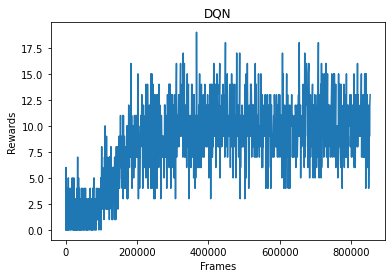

Episode:  1451
Steps:  212622  epsilon:  0.03002342962741816
Episode:  1452
Steps:  212821  epsilon:  0.030023197658584088
Steps:  213021  epsilon:  0.030022966838024547
Episode:  1453
Steps:  213127  epsilon:  0.030022845435783138
Steps:  213327  epsilon:  0.030022618119899022
Steps:  213527  epsilon:  0.030022393065845747
Episode:  1454
Steps:  213538  epsilon:  0.030022380753045863
Episode:  1455
Steps:  213715  epsilon:  0.03002218355725983
Episode:  1456
Steps:  213892  epsilon:  0.0300219880989568
Episode:  1457
Steps:  214050  epsilon:  0.0300218150773104
Steps:  214250  epsilon:  0.03002159801366439
Episode:  1458
Steps:  214263  epsilon:  0.030021583979517097
Episode:  1459
Steps:  214434  epsilon:  0.03002140022317003
Steps:  214634  epsilon:  0.030021187287391685
Episode:  1460
Steps:  214653  epsilon:  0.0300211671690264


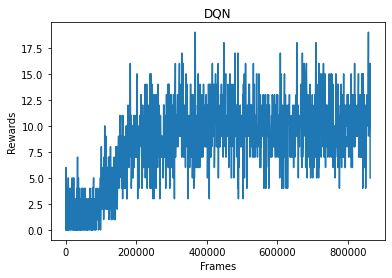

Episode:  1461
Steps:  214751  epsilon:  0.03002106370359549
Episode:  1462
Steps:  214921  epsilon:  0.030020885420889837
Episode:  1463
Steps:  215045  epsilon:  0.030020756331869798
Steps:  215245  epsilon:  0.030020549802916935
Episode:  1464
Steps:  215308  epsilon:  0.030020485172883492
Steps:  215508  epsilon:  0.030020281342007623
Steps:  215708  epsilon:  0.030020079539282856
Episode:  1465
Steps:  215725  epsilon:  0.030020062478926145
Episode:  1466
Steps:  215907  epsilon:  0.030019880738540828
Episode:  1467
Steps:  216087  epsilon:  0.03001970261465379
Steps:  216287  epsilon:  0.030019506570362408
Episode:  1468
Steps:  216317  epsilon:  0.030019477332440786
Episode:  1469
Steps:  216441  epsilon:  0.030019356946561517
Episode:  1470
Steps:  216601  epsilon:  0.030019202708762818


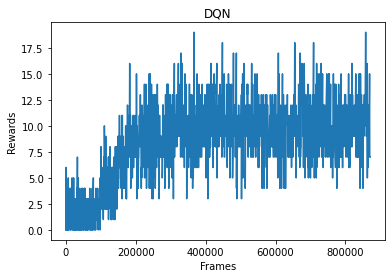

Episode:  1471
Steps:  216741  epsilon:  0.030019068759172006
Episode:  1472
Steps:  216931  epsilon:  0.030018888463719244
Episode:  1473
Steps:  217096  epsilon:  0.030018733274927538
Episode:  1474
Steps:  217288  epsilon:  0.030018554295961824
Episode:  1475
Steps:  217395  epsilon:  0.030018455295540692
Episode:  1476
Steps:  217576  epsilon:  0.03001828902860872
Episode:  1477
Steps:  217752  epsilon:  0.030018128791235468
Episode:  1478
Steps:  217912  epsilon:  0.030017984339483005
Episode:  1479
Steps:  218099  epsilon:  0.030017816969582445
Episode:  1480
Steps:  218229  epsilon:  0.030017701534849468


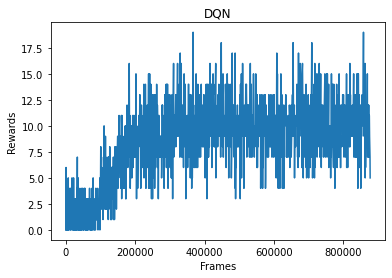

Episode:  1481
Steps:  218330  epsilon:  0.0300176123674357
Episode:  1482
Steps:  218451  epsilon:  0.030017506134292004
Episode:  1483
Steps:  218647  epsilon:  0.030017335412081122
Episode:  1484
Steps:  218765  epsilon:  0.030017233434280175
Steps:  218965  epsilon:  0.030017061958744016
Episode:  1485
Steps:  218991  epsilon:  0.030017039792608755
Episode:  1486
Steps:  219155  epsilon:  0.030016900637624532
Steps:  219355  epsilon:  0.030016732473470423
Episode:  1487
Steps:  219461  epsilon:  0.030016644025953988
Episode:  1488
Steps:  219615  epsilon:  0.0300165163591023
Episode:  1489
Steps:  219751  epsilon:  0.030016404428854553
Episode:  1490
Steps:  219931  epsilon:  0.03001625745138557


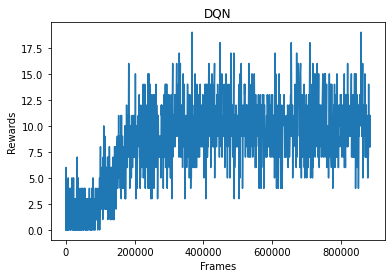

Episode:  1491
Steps:  220080  epsilon:  0.030016136783419037
Episode:  1492
Steps:  220225  epsilon:  0.030016020214811045
Episode:  1493
Steps:  220396  epsilon:  0.030015883825868006
Episode:  1494
Steps:  220573  epsilon:  0.030015743874208613
Steps:  220773  epsilon:  0.030015587220042803
Episode:  1495
Steps:  220811  epsilon:  0.030015557632441844
Episode:  1496
Steps:  220983  epsilon:  0.03001542441047838
Steps:  221183  epsilon:  0.030015270935029797
Episode:  1497
Steps:  221214  epsilon:  0.030015247283415238
Episode:  1498
Steps:  221362  epsilon:  0.030015134869960727
Steps:  221562  epsilon:  0.030014984275488432
Episode:  1499
Steps:  221654  epsilon:  0.030014915506112017
Episode:  1500
Steps:  221804  epsilon:  0.030014804058268


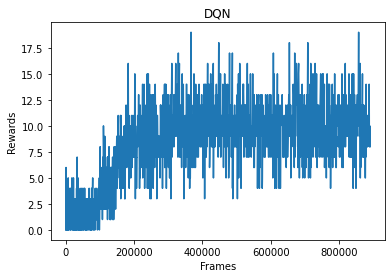

Episode:  1501
Steps:  221934  epsilon:  0.030014708143948497
Episode:  1502
Steps:  222122  epsilon:  0.030014570535169895
Episode:  1503
Steps:  222312  epsilon:  0.03001443277050405
Episode:  1504
Steps:  222478  epsilon:  0.030014313474273083
Episode:  1505
Steps:  222669  epsilon:  0.030014177431233243
Episode:  1506
Steps:  222854  epsilon:  0.030014046894656754
Steps:  223054  epsilon:  0.03001390712571961
Episode:  1507
Steps:  223120  epsilon:  0.030013861307845807
Episode:  1508
Steps:  223287  epsilon:  0.03001374604780565
Episode:  1509
Steps:  223465  epsilon:  0.0300136242507809
Episode:  1510
Steps:  223590  epsilon:  0.03001353936475866


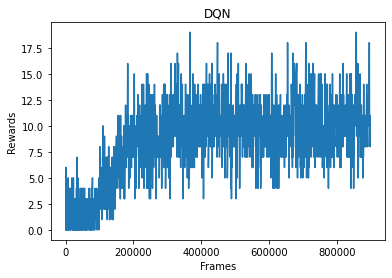

Episode:  1511
Steps:  223744  epsilon:  0.03001343551199627
Episode:  1512
Steps:  223881  epsilon:  0.030013343793234493
Episode:  1513
Steps:  224005  epsilon:  0.030013261317654933
Episode:  1514
Steps:  224201  epsilon:  0.030013131991475234
Episode:  1515
Steps:  224351  epsilon:  0.030013033869954818
Steps:  224551  epsilon:  0.030012904180781876
Episode:  1516
Steps:  224592  epsilon:  0.030012877754307662
Steps:  224792  epsilon:  0.030012749618511365
Episode:  1517
Steps:  224797  epsilon:  0.03001274643150513
Steps:  224997  epsilon:  0.030012619602392546
Episode:  1518
Steps:  225007  epsilon:  0.030012613294168537
Episode:  1519
Steps:  225203  epsilon:  0.030012490287602323
Episode:  1520
Steps:  225374  epsilon:  0.030012383950880597
Steps:  225574  epsilon:  0.030012260728510494


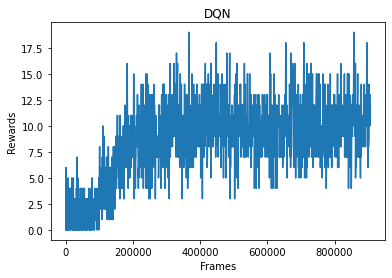

Episode:  1521
Steps:  225577  epsilon:  0.030012258889539144
Episode:  1522
Steps:  225730  epsilon:  0.030012165466831636
Episode:  1523
Steps:  225862  epsilon:  0.030012085439132453
Episode:  1524
Steps:  225951  epsilon:  0.03001203177841197
Episode:  1525
Steps:  226096  epsilon:  0.030011944863465867
Episode:  1526
Steps:  226235  epsilon:  0.030011862134481003
Episode:  1527
Steps:  226383  epsilon:  0.03001177467867143
Episode:  1528
Steps:  226514  epsilon:  0.030011697806557137
Episode:  1529
Steps:  226668  epsilon:  0.030011608079339763
Episode:  1530
Steps:  226794  epsilon:  0.030011535178319258


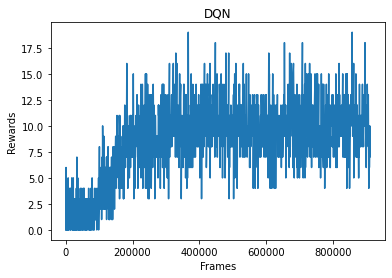

Episode:  1531
Steps:  226959  epsilon:  0.03001144040457735
Episode:  1532
Steps:  227140  epsilon:  0.03001133733600468
Episode:  1533
Steps:  227243  epsilon:  0.03001127909881374
Episode:  1534
Steps:  227400  epsilon:  0.030011190904503614
Steps:  227600  epsilon:  0.03001107955314331
Episode:  1535
Steps:  227706  epsilon:  0.03001102098684942
Episode:  1536
Steps:  227881  epsilon:  0.030010924973883794
Episode:  1537
Steps:  228059  epsilon:  0.030010828173019043
Steps:  228259  epsilon:  0.030010720430897312
Episode:  1538
Steps:  228298  epsilon:  0.030010699546426038
Episode:  1539
Steps:  228419  epsilon:  0.030010635009590936
Steps:  228619  epsilon:  0.030010529189477428
Episode:  1540
Steps:  228674  epsilon:  0.030010500273983394


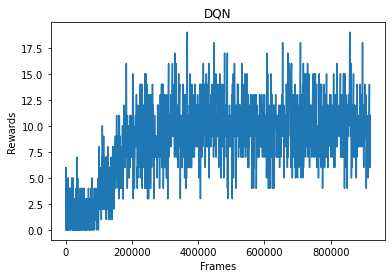

Episode:  1541
Steps:  228855  epsilon:  0.03001040567520895
Episode:  1542
Steps:  229014  epsilon:  0.030010323278053707
Episode:  1543
Steps:  229151  epsilon:  0.030010252805243977
Episode:  1544
Steps:  229289  epsilon:  0.030010182304395432
Steps:  229489  epsilon:  0.03001008098877388
Episode:  1545
Steps:  229500  epsilon:  0.030010075445754528
Episode:  1546
Steps:  229696  epsilon:  0.030009977188632412
Episode:  1547
Steps:  229795  epsilon:  0.03000992792358028
Episode:  1548
Steps:  229966  epsilon:  0.03000984340167969
Steps:  230166  epsilon:  0.030009745458196502
Episode:  1549
Steps:  230209  epsilon:  0.030009724527969437
Episode:  1550
Steps:  230400  epsilon:  0.030009632100769672
Steps:  230600  epsilon:  0.03000953625976567


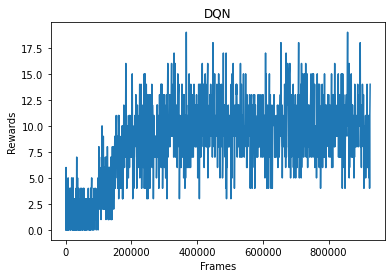

Episode:  1551
Steps:  230649  epsilon:  0.030009512924526586
Episode:  1552
Steps:  230769  epsilon:  0.030009456017870115
Episode:  1553
Steps:  230892  epsilon:  0.0300093980418193
Episode:  1554
Steps:  231055  epsilon:  0.03000932175905299
Episode:  1555
Steps:  231204  epsilon:  0.03000925256999729
Steps:  231404  epsilon:  0.03000916050538757
Steps:  231604  epsilon:  0.030009069356836022
Episode:  1556
Steps:  231612  epsilon:  0.030009065729818738
Episode:  1557
Steps:  231720  epsilon:  0.030009016906818457
Episode:  1558
Steps:  231856  epsilon:  0.030008955799851245
Steps:  232056  epsilon:  0.030008866688153817
Episode:  1559
Steps:  232207  epsilon:  0.03000879999673516
Episode:  1560
Steps:  232367  epsilon:  0.030008729877611738


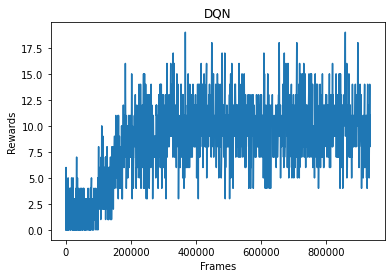

Episode:  1561
Steps:  232531  epsilon:  0.030008658585313222
Steps:  232731  epsilon:  0.030008572430949856
Episode:  1562
Steps:  232861  epsilon:  0.030008516890849556
Episode:  1563
Steps:  233038  epsilon:  0.030008441848915882
Episode:  1564
Steps:  233184  epsilon:  0.030008380447805523
Episode:  1565
Steps:  233364  epsilon:  0.030008305362167472
Episode:  1566
Steps:  233444  epsilon:  0.030008272207073198
Episode:  1567
Steps:  233616  epsilon:  0.030008201371123536
Episode:  1568
Steps:  233714  epsilon:  0.030008161282701874
Steps:  233914  epsilon:  0.03000808007658217
Episode:  1569
Steps:  234049  epsilon:  0.030008025719726016
Episode:  1570
Steps:  234229  epsilon:  0.030007953812317197
Steps:  234429  epsilon:  0.03000787467056231


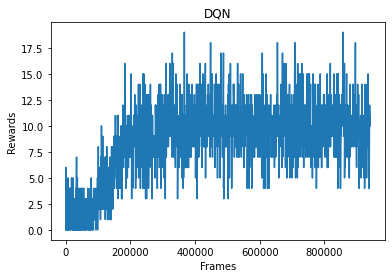

Episode:  1571
Steps:  234479  epsilon:  0.030007855008473756
Episode:  1572
Steps:  234613  epsilon:  0.030007802555829556
Episode:  1573
Steps:  234738  epsilon:  0.0300077539419323
Steps:  234938  epsilon:  0.030007676788920974
Episode:  1574
Steps:  235083  epsilon:  0.03000762133347021
Steps:  235283  epsilon:  0.03000754549993513
Episode:  1575
Steps:  235295  epsilon:  0.030007540973993087
Episode:  1576
Steps:  235492  epsilon:  0.030007467060023166
Episode:  1577
Steps:  235668  epsilon:  0.03000740163817329
Episode:  1578
Steps:  235840  epsilon:  0.030007338257014623
Episode:  1579
Steps:  235964  epsilon:  0.030007292900571397
Episode:  1580
Steps:  236121  epsilon:  0.030007235875418474
Steps:  236321  epsilon:  0.030007163877255088


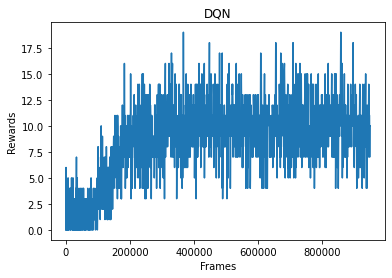

Episode:  1581
Steps:  236348  epsilon:  0.03000715421254594
Steps:  236548  epsilon:  0.030007083026941713
Episode:  1582
Steps:  236589  epsilon:  0.030007068521609528
Episode:  1583
Steps:  236758  epsilon:  0.030007009044247687
Episode:  1584
Steps:  236895  epsilon:  0.030006961196360697
Episode:  1585
Steps:  237058  epsilon:  0.0300069046931736
Episode:  1586
Steps:  237202  epsilon:  0.030006855157923642
Episode:  1587
Steps:  237317  epsilon:  0.030006815853873017
Episode:  1588
Steps:  237489  epsilon:  0.030006757488858993
Episode:  1589
Steps:  237637  epsilon:  0.030006707668005943
Episode:  1590
Steps:  237824  epsilon:  0.030006645243598962
Steps:  238024  epsilon:  0.030006579122320375


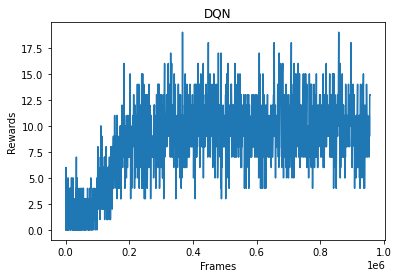

Episode:  1591
Steps:  238143  epsilon:  0.030006540092770626
Episode:  1592
Steps:  238286  epsilon:  0.030006493497882543
Episode:  1593
Steps:  238427  epsilon:  0.030006447879715455
Episode:  1594
Steps:  238559  epsilon:  0.030006405463835706
Episode:  1595
Steps:  238733  epsilon:  0.030006349978013637
Steps:  238933  epsilon:  0.030006286794676713
Episode:  1596
Steps:  238975  epsilon:  0.030006273606260576
Episode:  1597
Steps:  239129  epsilon:  0.03000622548499699
Episode:  1598
Steps:  239248  epsilon:  0.03000618855334189
Episode:  1599
Steps:  239417  epsilon:  0.030006136480384242
Episode:  1600
Steps:  239574  epsilon:  0.030006088497592086


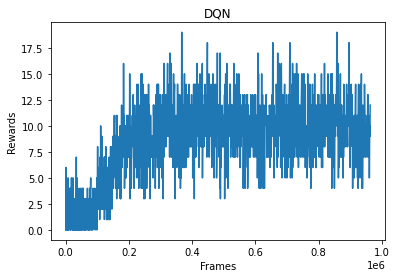

Episode:  1601
Steps:  239762  epsilon:  0.03000603153386369
Episode:  1602
Steps:  239928  epsilon:  0.030005981679315202
Episode:  1603
Steps:  239999  epsilon:  0.030005960482001125
Episode:  1604
Steps:  240170  epsilon:  0.0300059097371235
Episode:  1605
Steps:  240320  epsilon:  0.03000586557989168
Steps:  240520  epsilon:  0.0300058072163966
Episode:  1606
Steps:  240623  epsilon:  0.030005777386111075
Episode:  1607
Steps:  240789  epsilon:  0.030005729632258983
Episode:  1608
Steps:  240976  epsilon:  0.030005676309868005
Episode:  1609
Steps:  241162  epsilon:  0.030005623764899056
Episode:  1610
Steps:  241338  epsilon:  0.030005574492882783


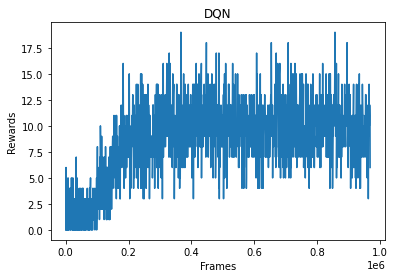

Episode:  1611
Steps:  241453  epsilon:  0.03000554253152567
Episode:  1612
Steps:  241609  epsilon:  0.030005499467946062
Episode:  1613
Steps:  241753  epsilon:  0.030005460013981564
Steps:  241953  epsilon:  0.030005405685934714
Episode:  1614
Steps:  241957  epsilon:  0.030005404604905635
Episode:  1615
Steps:  242123  epsilon:  0.030005359932332554
Episode:  1616
Steps:  242275  epsilon:  0.030005319351250268
Episode:  1617
Steps:  242427  epsilon:  0.03000527907741519
Steps:  242627  epsilon:  0.030005226549717257
Steps:  242827  epsilon:  0.030005174544678655
Episode:  1618
Steps:  242951  epsilon:  0.030005142561751172
Episode:  1619
Steps:  243132  epsilon:  0.0300050962315278
Episode:  1620
Steps:  243314  epsilon:  0.030005050066191755


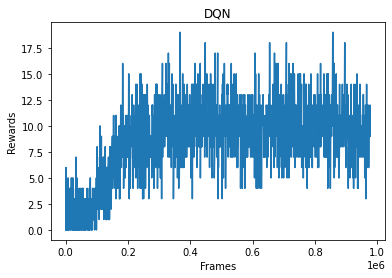

Episode:  1621
Steps:  243458  epsilon:  0.030005013836299298
Episode:  1622
Steps:  243596  epsilon:  0.030004979359909166
Steps:  243796  epsilon:  0.030004929814450246
Episode:  1623
Steps:  243803  epsilon:  0.030004928089317102
Episode:  1624
Steps:  243921  epsilon:  0.030004899099195088
Steps:  244121  epsilon:  0.03000485035234362
Episode:  1625
Steps:  244136  epsilon:  0.03000484671594318
Episode:  1626
Steps:  244298  epsilon:  0.030004807616112135
Steps:  244498  epsilon:  0.03000475977953255
Episode:  1627
Steps:  244568  epsilon:  0.030004743149423852
Episode:  1628
Steps:  244638  epsilon:  0.030004726577418796
Episode:  1629
Steps:  244778  epsilon:  0.03000469360690828
Episode:  1630
Steps:  244907  epsilon:  0.030004663430567038


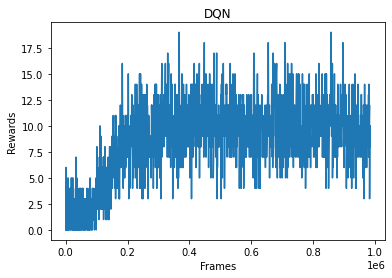

Episode:  1631
Steps:  245095  epsilon:  0.030004619799706023
Episode:  1632
Steps:  245256  epsilon:  0.030004582759604822
Steps:  245456  epsilon:  0.030004537160384866
Episode:  1633
Steps:  245504  epsilon:  0.030004526284256518
Episode:  1634
Steps:  245624  epsilon:  0.030004499207861392
Episode:  1635
Steps:  245813  epsilon:  0.030004456890611028
Episode:  1636
Steps:  245952  epsilon:  0.03000442602261183
Episode:  1637
Steps:  246104  epsilon:  0.030004392512340307
Episode:  1638
Steps:  246233  epsilon:  0.03000436427180933
Episode:  1639
Steps:  246366  epsilon:  0.030004335345687753
Episode:  1640
Steps:  246566  epsilon:  0.030004292208277404


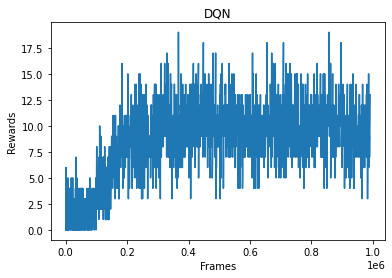

Episode:  1641
Steps:  246758  epsilon:  0.030004251200231504
Episode:  1642
Steps:  246892  epsilon:  0.030004222812395398
Episode:  1643
Steps:  246994  epsilon:  0.030004201330876615
Episode:  1644
Steps:  247185  epsilon:  0.030004161399144254
Episode:  1645
Steps:  247365  epsilon:  0.030004124114584148
Steps:  247565  epsilon:  0.030004083078958396
Episode:  1646
Steps:  247614  epsilon:  0.03000407308765929
Episode:  1647
Steps:  247762  epsilon:  0.03000404305805717
Episode:  1648
Steps:  247931  epsilon:  0.030004009038153107
Steps:  248131  epsilon:  0.03000396914755698
Episode:  1649
Steps:  248187  epsilon:  0.030003958049488366
Episode:  1650
Steps:  248262  epsilon:  0.030003943234598065


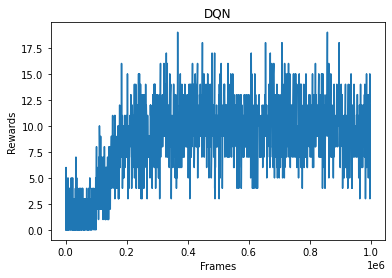

Episode:  1651
Steps:  248459  epsilon:  0.030003904584401983
Episode:  1652
Steps:  248611  epsilon:  0.0300038750220398
Steps:  248811  epsilon:  0.030003836464926277
Episode:  1653
Steps:  248867  epsilon:  0.0300038257378494
Episode:  1654
Steps:  249001  epsilon:  0.030003800191083042
Steps:  249201  epsilon:  0.030003762378549983
Episode:  1655
Steps:  249223  epsilon:  0.03000375824220898
Steps:  249423  epsilon:  0.03000372084707419
Episode:  1656
Steps:  249502  epsilon:  0.030003706178717324
Steps:  249702  epsilon:  0.03000366930162293
Episode:  1657
Steps:  249718  epsilon:  0.0300036663673555
Steps:  249918  epsilon:  0.030003629886390774
Episode:  1658
Steps:  249981  epsilon:  0.03000361847023852
Episode:  1659
Steps:  250161  epsilon:  0.030003586050115764
Steps:  250361  epsilon:  0.030003550368320926
Episode:  1660
Steps:  250417  epsilon:  0.03000354044119409
Steps:  250617  epsilon:  0.030003505213215608


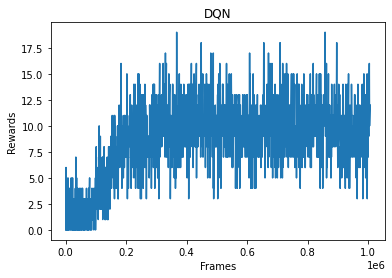

Episode:  1661
Steps:  250674  epsilon:  0.030003495237579978
Episode:  1662
Steps:  250821  epsilon:  0.03000346964176362
Episode:  1663
Steps:  251012  epsilon:  0.030003436664402312
Episode:  1664
Steps:  251169  epsilon:  0.03000340979219815
Steps:  251369  epsilon:  0.030003375864198895
Episode:  1665
Steps:  251379  epsilon:  0.030003374176688708
Steps:  251579  epsilon:  0.030003340603069698
Episode:  1666
Steps:  251610  epsilon:  0.030003335429145767
Episode:  1667
Steps:  251709  epsilon:  0.03000331895956733
Steps:  251909  epsilon:  0.030003285935367854
Episode:  1668
Steps:  251946  epsilon:  0.030003279862007015
Episode:  1669
Steps:  252124  epsilon:  0.030003250800749576
Episode:  1670
Steps:  252323  epsilon:  0.03000321861566843


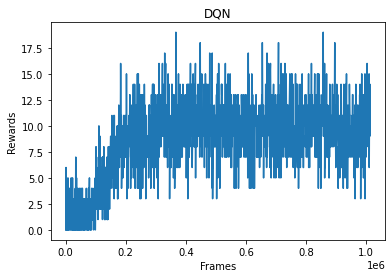

Episode:  1671
Steps:  252500  epsilon:  0.030003190256593766
Episode:  1672
Steps:  252675  epsilon:  0.030003162463620156
Episode:  1673
Steps:  252853  epsilon:  0.03000313444257256
Steps:  253053  epsilon:  0.03000310325434786
Episode:  1674
Steps:  253058  epsilon:  0.03000310247863124
Episode:  1675
Steps:  253229  epsilon:  0.030003076065515916
Episode:  1676
Steps:  253350  epsilon:  0.03000305751150203
Episode:  1677
Steps:  253508  epsilon:  0.030003033452320062
Episode:  1678
Steps:  253653  epsilon:  0.030003011539321344
Episode:  1679
Steps:  253852  epsilon:  0.030002981723086852
Episode:  1680
Steps:  254019  epsilon:  0.030002956929356957
Steps:  254219  epsilon:  0.030002927507418262


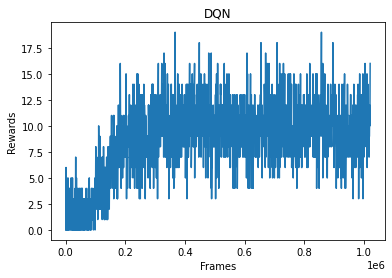

Episode:  1681
Steps:  254253  epsilon:  0.030002922534883503
Episode:  1682
Steps:  254390  epsilon:  0.030002902583929583
Episode:  1683
Steps:  254577  epsilon:  0.030002875571250906
Episode:  1684
Steps:  254720  epsilon:  0.030002855084244787
Steps:  254920  epsilon:  0.030002826675681892
Episode:  1685
Steps:  255078  epsilon:  0.0300028044329186
Episode:  1686
Steps:  255258  epsilon:  0.030002779306261895
Steps:  255458  epsilon:  0.030002751651702526
Episode:  1687
Steps:  255556  epsilon:  0.03000273820158887
Steps:  255756  epsilon:  0.030002710956027835
Episode:  1688
Steps:  255757  epsilon:  0.030002710820483423
Episode:  1689
Steps:  255908  epsilon:  0.03000269043085647
Episode:  1690
Steps:  256074  epsilon:  0.03000266819269639


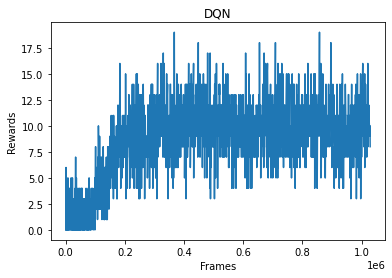

Episode:  1691
Steps:  256215  epsilon:  0.030002649448090255
Steps:  256415  epsilon:  0.030002623085641285
Episode:  1692
Steps:  256490  epsilon:  0.030002613267490666
Episode:  1693
Steps:  256652  epsilon:  0.030002592185521235
Episode:  1694
Steps:  256828  epsilon:  0.0300025694743643
Steps:  257028  epsilon:  0.030002543907667198
Episode:  1695
Steps:  257099  epsilon:  0.030002534892805827
Episode:  1696
Steps:  257296  epsilon:  0.030002510046679746
Episode:  1697
Steps:  257467  epsilon:  0.03000248867726506
Episode:  1698
Steps:  257665  epsilon:  0.0300024641609163
Episode:  1699
Steps:  257837  epsilon:  0.030002443059996428
Episode:  1700
Steps:  257978  epsilon:  0.030002425896994124
Steps:  258178  epsilon:  0.030002401758915723


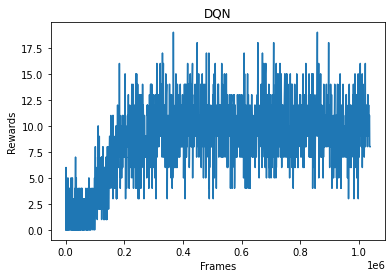

Episode:  1701
Steps:  258372  epsilon:  0.030002378574480536
Episode:  1702
Steps:  258541  epsilon:  0.030002358560205576
Episode:  1703
Steps:  258691  epsilon:  0.030002340937173015
Episode:  1704
Steps:  258796  epsilon:  0.030002328679457516
Episode:  1705
Steps:  258953  epsilon:  0.03000231047088592
Steps:  259153  epsilon:  0.03000228748131649
Episode:  1706
Steps:  259163  epsilon:  0.030002286337861717
Episode:  1707
Steps:  259319  epsilon:  0.030002268573796315
Episode:  1708
Steps:  259463  epsilon:  0.030002252298725544
Episode:  1709
Steps:  259663  epsilon:  0.03000222988797878
Steps:  259863  epsilon:  0.03000220770022267
Steps:  260063  epsilon:  0.030002185733238422
Steps:  260263  epsilon:  0.03000216398482932
Episode:  1710
Steps:  260431  epsilon:  0.03000214588348882


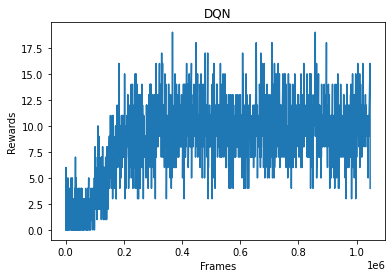

Episode:  1711
Steps:  260561  epsilon:  0.030002131980479872
Episode:  1712
Steps:  260675  epsilon:  0.030002119862759448
Episode:  1713
Steps:  260834  epsilon:  0.03000210307666365
Episode:  1714
Steps:  260948  epsilon:  0.03000209112322633
Steps:  261148  epsilon:  0.030002070316202577
Episode:  1715
Steps:  261338  epsilon:  0.03000205074132653
Episode:  1716
Steps:  261449  epsilon:  0.0300020393912378
Steps:  261649  epsilon:  0.030002019098955935
Episode:  1717
Steps:  261671  epsilon:  0.03000201687916819
Steps:  261871  epsilon:  0.030001996810885157
Episode:  1718
Steps:  261874  epsilon:  0.03000199651138599
Episode:  1719
Steps:  262058  epsilon:  0.030001978227715085
Episode:  1720
Steps:  262252  epsilon:  0.030001959131671786


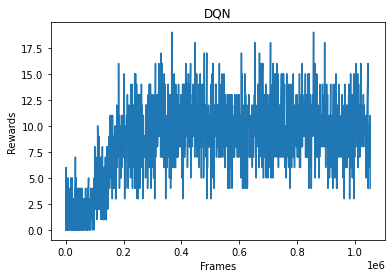

Episode:  1721
Steps:  262344  epsilon:  0.030001950140361965
Episode:  1722
Steps:  262493  epsilon:  0.030001935665800953
Episode:  1723
Steps:  262654  epsilon:  0.03000192014624129
Episode:  1724
Steps:  262845  epsilon:  0.030001901896127683
Episode:  1725
Steps:  262995  epsilon:  0.03000188768526408
Episode:  1726
Steps:  263178  epsilon:  0.030001870491724314
Episode:  1727
Steps:  263311  epsilon:  0.03000185809422173
Episode:  1728
Steps:  263509  epsilon:  0.0300018397898451
Episode:  1729
Steps:  263635  epsilon:  0.030001828235603156
Steps:  263835  epsilon:  0.030001810044354957
Episode:  1730
Steps:  263882  epsilon:  0.030001805795744796


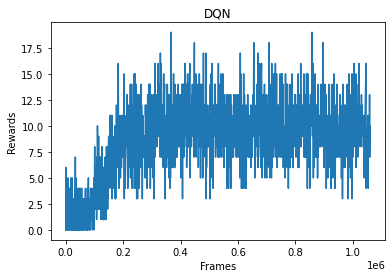

Episode:  1731
Steps:  264034  epsilon:  0.03000179212371665
Episode:  1732
Steps:  264207  epsilon:  0.030001776688699192
Episode:  1733
Steps:  264351  epsilon:  0.030001763942482003
Steps:  264551  epsilon:  0.03000174639096105
Episode:  1734
Steps:  264581  epsilon:  0.030001743773338318
Episode:  1735
Steps:  264751  epsilon:  0.030001729014080648
Episode:  1736
Steps:  264951  epsilon:  0.030001711810103096
Episode:  1737
Steps:  265121  epsilon:  0.03000169732138152
Episode:  1738
Steps:  265265  epsilon:  0.03000168514455675
Steps:  265465  epsilon:  0.03000166837708825
Episode:  1739
Steps:  265590  epsilon:  0.030001657982249158
Episode:  1740
Steps:  265770  epsilon:  0.030001643127356203


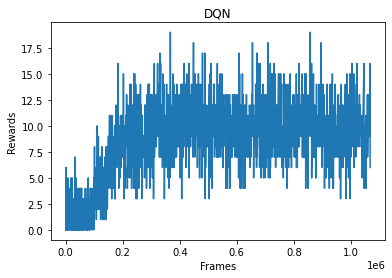

Episode:  1741
Steps:  265870  epsilon:  0.030001634932224328
Episode:  1742
Steps:  266001  epsilon:  0.03000162425841315
Steps:  266201  epsilon:  0.030001608096771906
Episode:  1743
Steps:  266224  epsilon:  0.030001606248523563
Steps:  266424  epsilon:  0.030001590266083716
Episode:  1744
Steps:  266455  epsilon:  0.030001587803080605
Episode:  1745
Steps:  266625  epsilon:  0.030001574363951632
Steps:  266825  epsilon:  0.030001558698768575
Episode:  1746
Steps:  266831  epsilon:  0.03000155823122908
Steps:  267031  epsilon:  0.030001542726569293
Steps:  267231  epsilon:  0.03000152737618345
Episode:  1747
Steps:  267279  epsilon:  0.030001523714875935
Steps:  267479  epsilon:  0.0300015085536596
Episode:  1748
Steps:  267512  epsilon:  0.03000150606659845
Steps:  267712  epsilon:  0.03000149108098541
Episode:  1749
Steps:  267739  epsilon:  0.030001489069384216
Episode:  1750
Steps:  267902  epsilon:  0.030001476982788516
Steps:  268102  epsilon:  0.03000146228656422


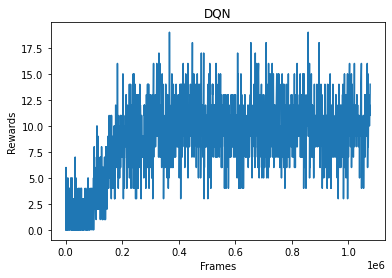

Episode:  1751
Steps:  268147  epsilon:  0.030001459000118087
Steps:  268347  epsilon:  0.030001444482824356
Episode:  1752
Steps:  268454  epsilon:  0.030001436775476783
Episode:  1753
Steps:  268649  epsilon:  0.03000142283498621
Episode:  1754
Steps:  268837  epsilon:  0.030001409523001687
Episode:  1755
Steps:  268963  epsilon:  0.030001400670920112
Episode:  1756
Steps:  269076  epsilon:  0.030001392779443827
Steps:  269276  epsilon:  0.03000137892105681
Episode:  1757
Steps:  269309  epsilon:  0.03000137664771309
Episode:  1758
Steps:  269470  epsilon:  0.030001365610184655
Episode:  1759
Steps:  269614  epsilon:  0.030001355813103144
Episode:  1760
Steps:  269812  epsilon:  0.03000134245677633
Steps:  270012  epsilon:  0.03000132909910822


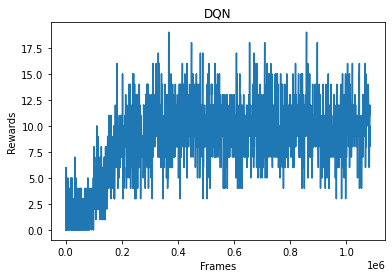

Episode:  1761
Steps:  270017  epsilon:  0.030001328766874974
Episode:  1762
Steps:  270143  epsilon:  0.03000132042195775
Steps:  270343  epsilon:  0.03000130728353975
Episode:  1763
Steps:  270487  epsilon:  0.030001297904901875
Steps:  270687  epsilon:  0.030001284990532322
Episode:  1764
Steps:  270715  epsilon:  0.030001283192804283
Episode:  1765
Steps:  270838  epsilon:  0.030001275325385646
Episode:  1766
Steps:  270974  epsilon:  0.030001266682591825
Episode:  1767
Steps:  271149  epsilon:  0.03000125564746822
Steps:  271349  epsilon:  0.030001243153567156
Episode:  1768
Steps:  271363  epsilon:  0.030001242283664162
Episode:  1769
Steps:  271485  epsilon:  0.030001234728799574
Episode:  1770
Steps:  271669  epsilon:  0.030001223421388463
Steps:  271869  epsilon:  0.030001211248142253


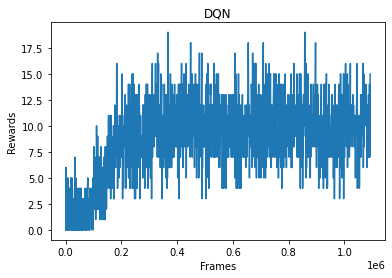

Episode:  1771
Steps:  271958  epsilon:  0.030001205870063122
Steps:  272158  epsilon:  0.030001193871455518
Episode:  1772
Steps:  272169  epsilon:  0.030001193215006758
Episode:  1773
Steps:  272292  epsilon:  0.030001185899253463
Episode:  1774
Steps:  272460  epsilon:  0.030001175979421358
Steps:  272660  epsilon:  0.03000116427823061
Episode:  1775
Steps:  272692  epsilon:  0.03000116241687492
Episode:  1776
Steps:  272804  epsilon:  0.03000115592553314
Episode:  1777
Steps:  272947  epsilon:  0.03000114769014219
Steps:  273147  epsilon:  0.030001136270434468
Episode:  1778
Steps:  273161  epsilon:  0.030001135475323487
Episode:  1779
Steps:  273327  epsilon:  0.030001126089881765
Episode:  1780
Steps:  273496  epsilon:  0.03000111661451208


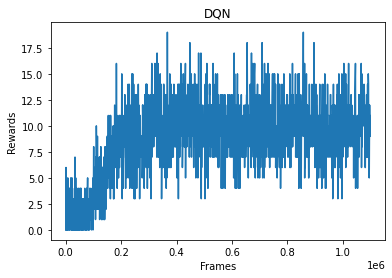

Episode:  1781
Steps:  273649  epsilon:  0.03000110810500144
Steps:  273849  epsilon:  0.030001097079172454
Episode:  1782
Steps:  273854  epsilon:  0.03000109680493694
Episode:  1783
Steps:  273986  epsilon:  0.0300010895898603
Episode:  1784
Steps:  274170  epsilon:  0.030001079611603945
Episode:  1785
Steps:  274341  epsilon:  0.03000107042027366
Steps:  274541  epsilon:  0.03000105976941398
Episode:  1786
Steps:  274592  epsilon:  0.030001057070444623
Episode:  1787
Steps:  274719  epsilon:  0.030001050379314123
Episode:  1788
Steps:  274791  epsilon:  0.030001046604746888
Steps:  274991  epsilon:  0.03000103619085566
Episode:  1789
Steps:  275019  epsilon:  0.030001034741203452
Episode:  1790
Steps:  275127  epsilon:  0.030001029168660362


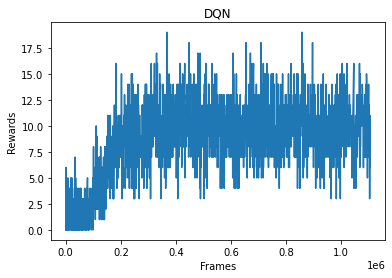

Episode:  1791
Steps:  275263  epsilon:  0.030001022194054008
Episode:  1792
Steps:  275444  epsilon:  0.030001012984931952
Steps:  275644  epsilon:  0.03000100290556347
Episode:  1793
Steps:  275649  epsilon:  0.030001002654868415
Episode:  1794
Steps:  275819  epsilon:  0.030000994168420534
Episode:  1795
Steps:  275999  epsilon:  0.03000098526104805
Episode:  1796
Steps:  276193  epsilon:  0.030000975750217984
Steps:  276393  epsilon:  0.030000966041341094
Episode:  1797
Steps:  276433  epsilon:  0.03000096411118921
Episode:  1798
Steps:  276620  epsilon:  0.030000955138761054
Steps:  276820  epsilon:  0.03000094563497159
Steps:  277020  epsilon:  0.03000093622574641
Episode:  1799
Steps:  277047  epsilon:  0.030000934962694403
Steps:  277247  epsilon:  0.030000925659660158
Episode:  1800
Steps:  277273  epsilon:  0.03000092445708444


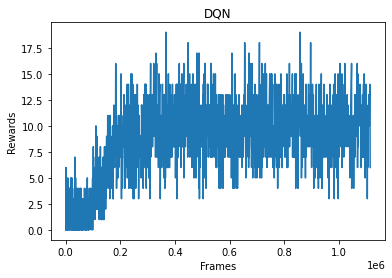

Episode:  1801
Steps:  277390  epsilon:  0.030000919064798313
Episode:  1802
Steps:  277547  epsilon:  0.03000091187838323
Steps:  277747  epsilon:  0.030000902805041717
Episode:  1803
Steps:  277848  epsilon:  0.030000898257368794
Episode:  1804
Steps:  277983  epsilon:  0.030000892214549015
Steps:  278183  epsilon:  0.030000883336865923
Episode:  1805
Steps:  278289  epsilon:  0.03000087866756511
Steps:  278489  epsilon:  0.030000869924676758
Episode:  1806
Steps:  278547  epsilon:  0.030000867405549695
Episode:  1807
Steps:  278714  epsilon:  0.030000860192868208
Steps:  278914  epsilon:  0.03000085163380616
Episode:  1808
Steps:  278919  epsilon:  0.03000085142092432
Episode:  1809
Steps:  279065  epsilon:  0.030000845228182582
Episode:  1810
Steps:  279243  epsilon:  0.030000837739027928


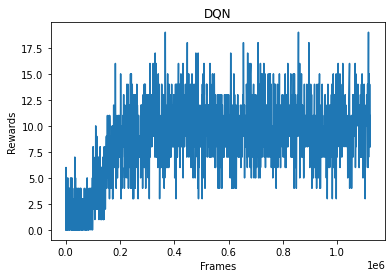

Episode:  1811
Steps:  279387  epsilon:  0.030000831728969102
Episode:  1812
Steps:  279521  epsilon:  0.030000826175011545
Episode:  1813
Steps:  279683  epsilon:  0.03000081951002359
Episode:  1814
Steps:  279789  epsilon:  0.03000081517811018
Steps:  279989  epsilon:  0.03000080706695246
Episode:  1815
Steps:  280028  epsilon:  0.03000080549470534
Steps:  280228  epsilon:  0.030000797479899106
Episode:  1816
Steps:  280338  epsilon:  0.030000793105799464
Episode:  1817
Steps:  280503  epsilon:  0.030000786589592928
Episode:  1818
Steps:  280671  epsilon:  0.03000078000991369
Steps:  280871  epsilon:  0.03000077224868537
Episode:  1819
Steps:  280872  epsilon:  0.0300007722100739
Steps:  281072  epsilon:  0.030000764526455285
Episode:  1820
Steps:  281087  epsilon:  0.030000763953275413


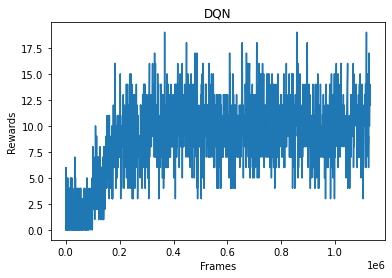

Episode:  1821
Steps:  281267  epsilon:  0.03000075710854343
Episode:  1822
Steps:  281411  epsilon:  0.030000751676939157
Episode:  1823
Steps:  281514  epsilon:  0.030000747815754007
Episode:  1824
Steps:  281676  epsilon:  0.030000741782912392
Steps:  281876  epsilon:  0.030000734402049093
Episode:  1825
Steps:  281978  epsilon:  0.030000730666133325
Episode:  1826
Steps:  282122  epsilon:  0.03000072542423066
Episode:  1827
Steps:  282301  epsilon:  0.030000718960651457
Episode:  1828
Steps:  282448  epsilon:  0.030000713695663202
Steps:  282648  epsilon:  0.030000706594272702
Episode:  1829
Steps:  282650  epsilon:  0.030000706523616808
Episode:  1830
Steps:  282796  epsilon:  0.030000701384774002


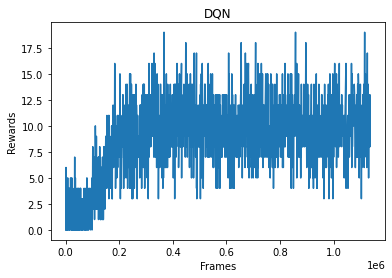

Episode:  1831
Steps:  282960  epsilon:  0.03000069565693509
Steps:  283160  epsilon:  0.03000068873503293
Episode:  1832
Steps:  283234  epsilon:  0.03000068619142189
Episode:  1833
Steps:  283400  epsilon:  0.030000680519603695
Episode:  1834
Steps:  283486  epsilon:  0.030000677599651797
Steps:  283686  epsilon:  0.03000067085742261
Episode:  1835
Steps:  283710  epsilon:  0.030000670052876526
Episode:  1836
Steps:  283905  epsilon:  0.030000663551606174
Steps:  284105  epsilon:  0.030000656949157378
Episode:  1837
Steps:  284125  epsilon:  0.030000656292536586
Episode:  1838
Steps:  284316  epsilon:  0.03000065005477558
Episode:  1839
Steps:  284404  epsilon:  0.030000647200817878
Episode:  1840
Steps:  284594  epsilon:  0.03000064108152278


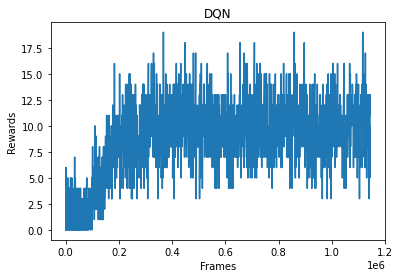

Episode:  1841
Steps:  284792  epsilon:  0.03000063476612849
Episode:  1842
Steps:  284982  epsilon:  0.030000628764403597
Steps:  285182  epsilon:  0.03000062250809325
Episode:  1843
Steps:  285210  epsilon:  0.030000621637191693
Steps:  285410  epsilon:  0.030000615451798288
Steps:  285610  epsilon:  0.030000609327950577
Episode:  1844
Steps:  285698  epsilon:  0.030000606652797246
Episode:  1845
Steps:  285866  epsilon:  0.03000060157825666
Episode:  1846
Steps:  286015  epsilon:  0.030000597113151815
Steps:  286215  epsilon:  0.030000591171776683
Episode:  1847
Steps:  286286  epsilon:  0.030000589076837593
Steps:  286486  epsilon:  0.030000583215425123
Episode:  1848
Steps:  286596  epsilon:  0.030000580016545268
Episode:  1849
Steps:  286782  epsilon:  0.03000057464739664
Steps:  286982  epsilon:  0.030000568929559504
Episode:  1850
Steps:  287012  epsilon:  0.03000056807680489


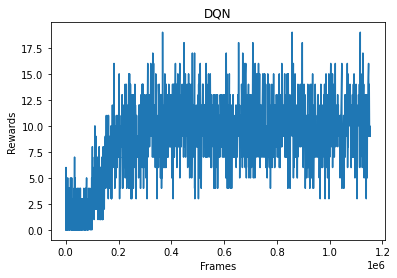

Episode:  1851
Steps:  287176  epsilon:  0.03000056343762174
Steps:  287376  epsilon:  0.03000055783132373
Episode:  1852
Steps:  287403  epsilon:  0.030000557078759538
Episode:  1853
Steps:  287572  epsilon:  0.030000552391276525
Steps:  287772  epsilon:  0.03000054689489149
Episode:  1854
Steps:  287944  epsilon:  0.030000542211761745
Episode:  1855
Steps:  288042  epsilon:  0.030000539561422745
Episode:  1856
Steps:  288186  epsilon:  0.030000535690532428
Episode:  1857
Steps:  288319  epsilon:  0.030000532140008963
Steps:  288519  epsilon:  0.030000526845127405
Episode:  1858
Steps:  288549  epsilon:  0.030000526055452118
Episode:  1859
Steps:  288741  epsilon:  0.03000052102948303
Steps:  288941  epsilon:  0.03000051584515305
Episode:  1860
Steps:  289021  epsilon:  0.030000513785893704


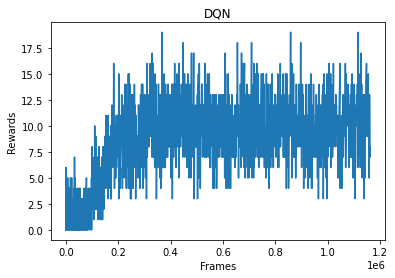

Episode:  1861
Steps:  289164  epsilon:  0.03000051012542633
Steps:  289364  epsilon:  0.030000505049593527
Episode:  1862
Steps:  289393  epsilon:  0.030000504317802296
Episode:  1863
Steps:  289491  epsilon:  0.030000501852689522
Steps:  289691  epsilon:  0.03000049685917183
Episode:  1864
Steps:  289839  epsilon:  0.030000493195984464
Episode:  1865
Steps:  289942  epsilon:  0.03000049066255433
Episode:  1866
Steps:  290078  epsilon:  0.030000487337367408
Steps:  290278  epsilon:  0.030000482488279582
Episode:  1867
Steps:  290359  epsilon:  0.03000048053815372
Steps:  290559  epsilon:  0.0300004757567192
Episode:  1868
Steps:  290578  epsilon:  0.030000475304964934
Episode:  1869
Steps:  290717  epsilon:  0.030000472013048087
Steps:  290917  epsilon:  0.030000467316439787
Episode:  1870
Steps:  290964  epsilon:  0.03000046621953552
Steps:  291164  epsilon:  0.030000461580573633


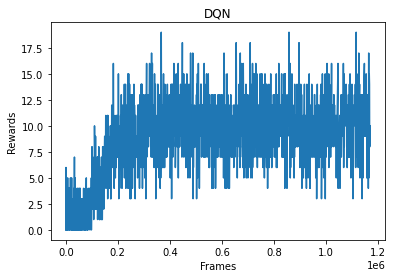

Episode:  1871
Steps:  291222  epsilon:  0.030000460243929043
Episode:  1872
Steps:  291395  epsilon:  0.030000456279987816
Episode:  1873
Steps:  291560  epsilon:  0.030000452531163083
Steps:  291760  epsilon:  0.030000448028402776
Episode:  1874
Steps:  291790  epsilon:  0.03000044735686395
Steps:  291990  epsilon:  0.030000442905588783
Episode:  1875
Steps:  292109  epsilon:  0.030000440278124985
Steps:  292309  epsilon:  0.030000435897284444
Episode:  1876
Steps:  292415  epsilon:  0.030000433593140214
Steps:  292615  epsilon:  0.030000429278816382
Episode:  1877
Steps:  292745  epsilon:  0.030000426497552975
Steps:  292945  epsilon:  0.030000422253831417
Episode:  1878
Steps:  293031  epsilon:  0.03000042044203809
Steps:  293231  epsilon:  0.03000041625856991
Episode:  1879
Steps:  293253  epsilon:  0.03000041580093723
Episode:  1880
Steps:  293415  epsilon:  0.030000412446553232


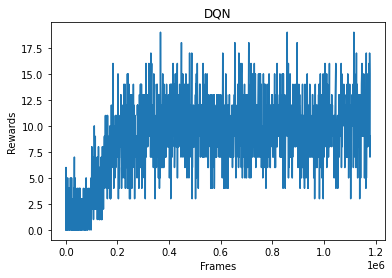

Episode:  1881
Steps:  293576  epsilon:  0.030000409139686476
Episode:  1882
Steps:  293726  epsilon:  0.030000406082617167
Episode:  1883
Steps:  293912  epsilon:  0.030000402323555556
Episode:  1884
Steps:  294044  epsilon:  0.03000039967696345
Steps:  294244  epsilon:  0.030000395700111218
Episode:  1885
Steps:  294312  epsilon:  0.030000394357015396
Episode:  1886
Steps:  294444  epsilon:  0.030000391762829325
Episode:  1887
Steps:  294607  epsilon:  0.030000388582937926
Episode:  1888
Steps:  294805  epsilon:  0.030000384754946662
Steps:  295005  epsilon:  0.030000380926570976
Episode:  1889
Steps:  295009  epsilon:  0.03000038085039328
Steps:  295209  epsilon:  0.03000037706086855
Episode:  1890
Steps:  295213  epsilon:  0.030000376985463918


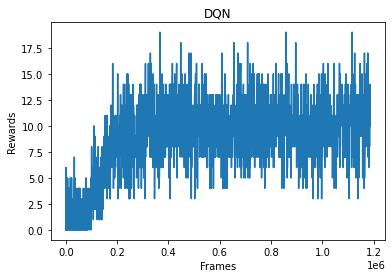

Episode:  1891
Steps:  295387  epsilon:  0.030000373719916113
Steps:  295587  epsilon:  0.030000370001340815
Episode:  1892
Steps:  295704  epsilon:  0.03000036784315183
Steps:  295904  epsilon:  0.030000364183051315
Steps:  296104  epsilon:  0.03000036055936941
Steps:  296304  epsilon:  0.03000035697174374
Episode:  1893
Steps:  296335  epsilon:  0.030000356418866128
Steps:  296535  epsilon:  0.030000352872439153
Episode:  1894
Steps:  296536  epsilon:  0.030000352854795975
Steps:  296736  epsilon:  0.03000034934383209
Episode:  1895
Steps:  296794  epsilon:  0.03000034833220255
Episode:  1896
Steps:  296956  epsilon:  0.030000345522107955
Steps:  297156  epsilon:  0.030000342084105538
Episode:  1897
Steps:  297189  epsilon:  0.03000034152013217
Episode:  1898
Steps:  297357  epsilon:  0.030000338663378225
Episode:  1899
Steps:  297519  epsilon:  0.030000335931284778
Steps:  297719  epsilon:  0.030000332588712646
Episode:  1900
Steps:  297756  epsilon:  0.03000033197399232
Steps:  297

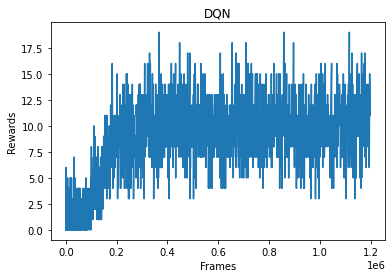

Episode:  1901
Steps:  298248  epsilon:  0.03000032390706216
Episode:  1902
Steps:  298395  epsilon:  0.030000321535072993
Episode:  1903
Steps:  298531  epsilon:  0.030000319356051564
Steps:  298731  epsilon:  0.030000316178405758
Episode:  1904
Steps:  298807  epsilon:  0.030000314979207736
Steps:  299007  epsilon:  0.030000311845112253
Episode:  1905
Steps:  299017  epsilon:  0.030000311689228672
Episode:  1906
Steps:  299183  epsilon:  0.030000309112914566
Episode:  1907
Steps:  299315  epsilon:  0.03000030707948702
Episode:  1908
Steps:  299465  epsilon:  0.03000030478500593
Episode:  1909
Steps:  299578  epsilon:  0.030000303067826247
Episode:  1910
Steps:  299714  epsilon:  0.0300003010139561


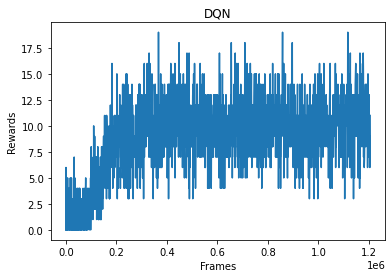

Episode:  1911
Steps:  299896  epsilon:  0.030000298287154864
Steps:  300096  epsilon:  0.030000295319148083
Episode:  1912
Steps:  300172  epsilon:  0.030000294199064824
Episode:  1913
Steps:  300252  epsilon:  0.030000293024619023
Episode:  1914
Steps:  300413  epsilon:  0.03000029067523978
Episode:  1915
Steps:  300575  epsilon:  0.030000288330280244
Steps:  300775  epsilon:  0.03000028546134602
Episode:  1916
Steps:  300969  epsilon:  0.030000282705757175
Episode:  1917
Steps:  301083  epsilon:  0.0300002810989182
Episode:  1918
Steps:  301271  epsilon:  0.030000278468968498
Episode:  1919
Steps:  301404  epsilon:  0.03000027662329353
Steps:  301604  epsilon:  0.03000027387084577
Episode:  1920
Steps:  301714  epsilon:  0.030000272368690833
Steps:  301914  epsilon:  0.030000269658577074


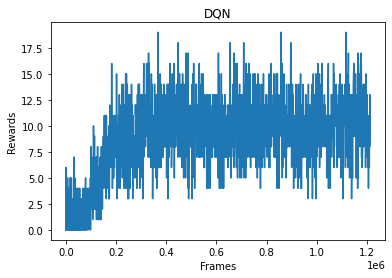

Episode:  1921
Steps:  301923  epsilon:  0.030000269537258015
Episode:  1922
Steps:  302021  epsilon:  0.030000268219755967
Episode:  1923
Steps:  302148  epsilon:  0.030000266521956732
Episode:  1924
Steps:  302281  epsilon:  0.030000264755465814
Episode:  1925
Steps:  302415  epsilon:  0.03000026298753338
Episode:  1926
Steps:  302572  epsilon:  0.030000260931163057
Episode:  1927
Steps:  302755  epsilon:  0.03000025855453258
Steps:  302955  epsilon:  0.030000255981871997
Episode:  1928
Steps:  302960  epsilon:  0.030000255917884525
Episode:  1929
Steps:  303102  epsilon:  0.03000025410730272
Episode:  1930
Steps:  303296  epsilon:  0.0300002516543778
Steps:  303496  epsilon:  0.030000249150374903


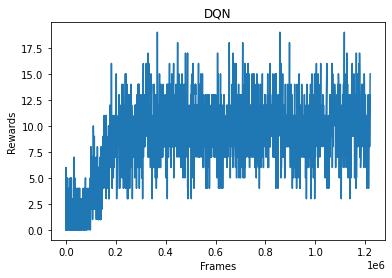

Episode:  1931
Steps:  303625  epsilon:  0.0300002475485265
Steps:  303825  epsilon:  0.030000245085377505
Episode:  1932
Steps:  303940  epsilon:  0.030000243680180397
Episode:  1933
Steps:  304087  epsilon:  0.030000241895697083
Episode:  1934
Steps:  304256  epsilon:  0.030000239860290146
Episode:  1935
Steps:  304423  epsilon:  0.03000023786579533
Episode:  1936
Steps:  304612  epsilon:  0.03000023562855119
Episode:  1937
Steps:  304760  epsilon:  0.030000233891335538
Episode:  1938
Steps:  304916  epsilon:  0.030000232074079633
Episode:  1939
Steps:  305076  epsilon:  0.030000230224893603
Episode:  1940
Steps:  305259  epsilon:  0.030000228127944


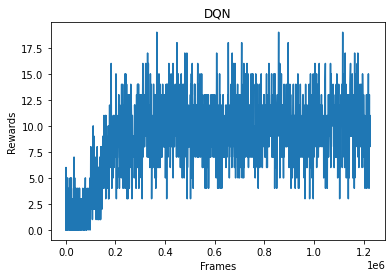

Episode:  1941
Steps:  305403  epsilon:  0.030000226491321714
Episode:  1942
Steps:  305568  epsilon:  0.03000022463045494
Steps:  305768  epsilon:  0.030000222395344566
Steps:  305968  epsilon:  0.030000220182473916
Episode:  1943
Steps:  306139  epsilon:  0.03000021830793882
Episode:  1944
Steps:  306244  epsilon:  0.03000021716482544
Episode:  1945
Steps:  306404  epsilon:  0.030000215434437618
Episode:  1946
Steps:  306536  epsilon:  0.030000214017252183
Episode:  1947
Steps:  306717  epsilon:  0.03000021208913395
Steps:  306917  epsilon:  0.030000209978811806
Episode:  1948
Steps:  306924  epsilon:  0.03000020990533208
Episode:  1949
Steps:  307099  epsilon:  0.030000208076672478
Episode:  1950
Steps:  307299  epsilon:  0.030000206006274992
Steps:  307499  epsilon:  0.03000020395647831


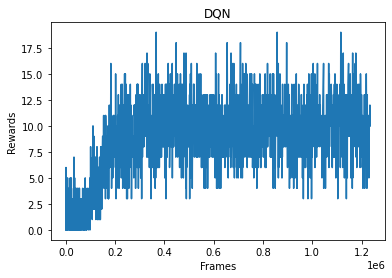

Episode:  1951
Steps:  307535  epsilon:  0.030000203589686858
Episode:  1952
Steps:  307730  epsilon:  0.03000020161433291
Episode:  1953
Steps:  307898  epsilon:  0.03000019992786559
Episode:  1954
Steps:  308009  epsilon:  0.03000019882133939
Episode:  1955
Steps:  308140  epsilon:  0.030000197523315286
Episode:  1956
Steps:  308302  epsilon:  0.030000195929838724
Episode:  1957
Steps:  308393  epsilon:  0.030000195040383006
Episode:  1958
Steps:  308571  epsilon:  0.030000193312225306
Episode:  1959
Steps:  308735  epsilon:  0.030000191733546486
Steps:  308935  epsilon:  0.030000189825765824
Episode:  1960
Steps:  308950  epsilon:  0.030000189683449873


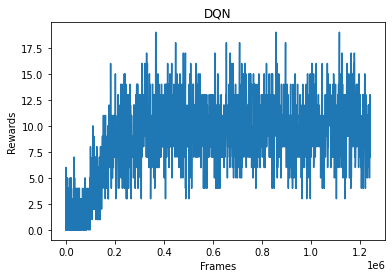

Episode:  1961
Steps:  309095  epsilon:  0.030000188313217956
Episode:  1962
Steps:  309220  epsilon:  0.030000187139930686
Episode:  1963
Steps:  309416  epsilon:  0.03000018531491654
Steps:  309616  epsilon:  0.03000018347100231
Episode:  1964
Steps:  309629  epsilon:  0.03000018335178491
Episode:  1965
Steps:  309760  epsilon:  0.03000018215475527
Episode:  1966
Steps:  309886  epsilon:  0.030000181010787594
Episode:  1967
Steps:  310042  epsilon:  0.03000017960439551
Steps:  310242  epsilon:  0.030000177817301917
Steps:  310442  epsilon:  0.0300001760479902
Episode:  1968
Steps:  310586  epsilon:  0.030000174784996902
Episode:  1969
Steps:  310728  epsilon:  0.030000173548418472
Steps:  310928  epsilon:  0.030000171821582856
Episode:  1970
Steps:  311034  epsilon:  0.030000170913337443
Steps:  311234  epsilon:  0.03000016921272132
Steps:  311434  epsilon:  0.030000167529026612


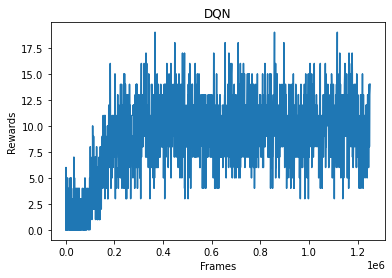

Episode:  1971
Steps:  311498  epsilon:  0.030000166993790562
Episode:  1972
Steps:  311569  epsilon:  0.03000016640201363
Episode:  1973
Steps:  311662  epsilon:  0.030000165630040494
Episode:  1974
Steps:  311847  epsilon:  0.030000164105026685
Episode:  1975
Steps:  312007  epsilon:  0.030000162797423853
Episode:  1976
Steps:  312159  epsilon:  0.030000161564853134
Steps:  312359  epsilon:  0.030000159957255985
Episode:  1977
Steps:  312381  epsilon:  0.030000159781399742
Steps:  312581  epsilon:  0.030000158191548252
Steps:  312781  epsilon:  0.03000015661751605
Steps:  312981  epsilon:  0.030000155059145724
Episode:  1978
Steps:  313149  epsilon:  0.030000153762104104
Episode:  1979
Steps:  313333  epsilon:  0.030000152353980045
Episode:  1980
Steps:  313435  epsilon:  0.03000015157895275
Steps:  313635  epsilon:  0.030000150070716967


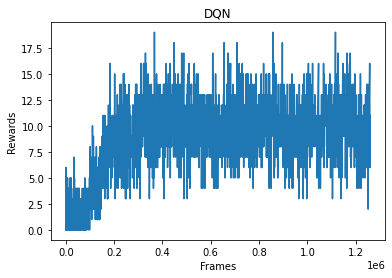

Episode:  1981
Steps:  313636  epsilon:  0.03000015006321362
Episode:  1982
Steps:  313775  epsilon:  0.03000014902389012
Steps:  313975  epsilon:  0.030000147541077635
Episode:  1983
Steps:  314014  epsilon:  0.030000147253652864
Episode:  1984
Steps:  314120  epsilon:  0.030000146475273035
Episode:  1985
Steps:  314281  epsilon:  0.030000145300880358
Episode:  1986
Steps:  314434  epsilon:  0.030000144193569486
Episode:  1987
Steps:  314603  epsilon:  0.030000142980267246
Steps:  314803  epsilon:  0.030000141557589816
Episode:  1988
Steps:  314820  epsilon:  0.03000014143731699
Episode:  1989
Steps:  314951  epsilon:  0.030000140513929956
Steps:  315151  epsilon:  0.030000139115792992
Episode:  1990
Steps:  315155  epsilon:  0.030000139087972617
Steps:  315355  epsilon:  0.030000137704024165


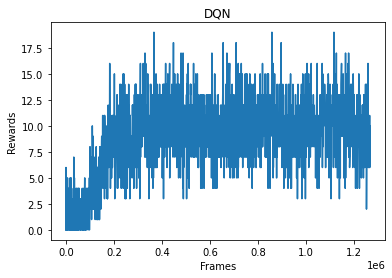

Episode:  1991
Steps:  315372  epsilon:  0.030000137587025476
Steps:  315572  epsilon:  0.0300001362180117
Episode:  1992
Steps:  315636  epsilon:  0.030000135782810754
Steps:  315836  epsilon:  0.030000134431749214
Episode:  1993
Steps:  315928  epsilon:  0.030000133814783277
Steps:  316128  epsilon:  0.030000132483303934
Steps:  316328  epsilon:  0.030000131165073034
Episode:  1994
Steps:  316466  epsilon:  0.03000013026314925
Steps:  316666  epsilon:  0.030000128967009255
Episode:  1995
Steps:  316724  epsilon:  0.030000128593546713
Steps:  316924  epsilon:  0.030000127314019544
Episode:  1996
Steps:  316935  epsilon:  0.030000127244016087
Episode:  1997
Steps:  317069  epsilon:  0.030000126394330803
Episode:  1998
Steps:  317197  epsilon:  0.030000125587990128
Episode:  1999
Steps:  317351  epsilon:  0.030000124624676123
Episode:  2000
Steps:  317434  epsilon:  0.030000124108555407


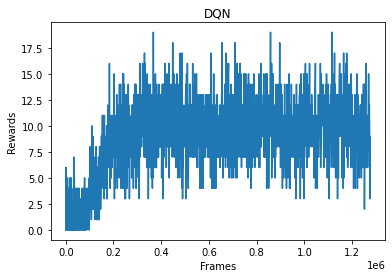

Episode:  2001
Steps:  317547  epsilon:  0.03000012340931927
Steps:  317747  epsilon:  0.030000122181376026
Steps:  317947  epsilon:  0.030000120965651023
Episode:  2002
Steps:  318138  epsilon:  0.030000119815927723
Episode:  2003
Steps:  318236  epsilon:  0.030000119230265722
Episode:  2004
Steps:  318404  epsilon:  0.030000118232926178
Episode:  2005
Steps:  318505  epsilon:  0.030000117637354985
Steps:  318705  epsilon:  0.030000116466843745
Episode:  2006
Steps:  318723  epsilon:  0.03000011636207074
Episode:  2007
Steps:  318852  epsilon:  0.030000115613950665
Episode:  2008
Steps:  319024  epsilon:  0.030000114623933864
Steps:  319224  epsilon:  0.030000113483406664
Episode:  2009
Steps:  319347  epsilon:  0.030000112787625436
Steps:  319547  epsilon:  0.03000011166536981
Episode:  2010
Steps:  319640  epsilon:  0.030000111147331213
Steps:  319840  epsilon:  0.03000011004139679


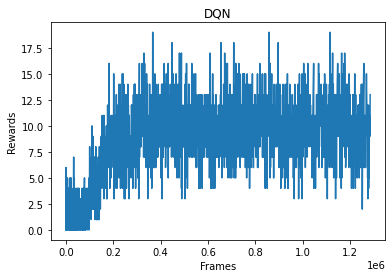

Episode:  2011
Steps:  319844  epsilon:  0.03000011001939071
Steps:  320044  epsilon:  0.030000108924679483
Episode:  2012
Steps:  320183  epsilon:  0.030000108170277543
Episode:  2013
Steps:  320308  epsilon:  0.030000107496321614
Episode:  2014
Steps:  320490  epsilon:  0.030000106522542504
Episode:  2015
Steps:  320689  epsilon:  0.03000010546789876
Steps:  320889  epsilon:  0.030000104418475632
Episode:  2016
Steps:  320901  epsilon:  0.030000104355843337
Steps:  321101  epsilon:  0.030000103317485347
Steps:  321301  epsilon:  0.030000102289459193
Episode:  2017
Steps:  321303  epsilon:  0.030000102279230757
Episode:  2018
Steps:  321470  epsilon:  0.03000010142875486
Episode:  2019
Steps:  321618  epsilon:  0.030000100680952355
Episode:  2020
Steps:  321756  epsilon:  0.03000009998864499


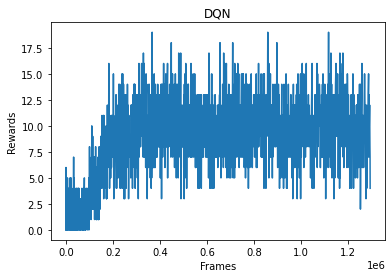

Episode:  2021
Steps:  321854  epsilon:  0.030000099499899038
Episode:  2022
Steps:  322011  epsilon:  0.03000009872188254
Steps:  322211  epsilon:  0.030000097739583394
Episode:  2023
Steps:  322360  epsilon:  0.03000009701412917
Episode:  2024
Steps:  322496  epsilon:  0.030000096356670985
Episode:  2025
Steps:  322655  epsilon:  0.030000095593672386
Episode:  2026
Steps:  322836  epsilon:  0.03000009473245255
Steps:  323036  epsilon:  0.030000093789848897
Episode:  2027
Steps:  323057  epsilon:  0.03000009369142124
Steps:  323257  epsilon:  0.030000092759176023
Steps:  323457  epsilon:  0.0300000918362068
Episode:  2028
Steps:  323649  epsilon:  0.030000090958797517
Steps:  323849  epsilon:  0.03000009005374236
Episode:  2029
Steps:  323863  epsilon:  0.0300000899907268
Steps:  324063  epsilon:  0.030000089095304106
Episode:  2030
Steps:  324072  epsilon:  0.03000008905522024
Steps:  324272  epsilon:  0.03000008816910599
Steps:  324472  epsilon:  0.030000087291808728


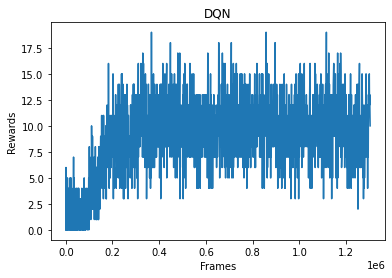

Episode:  2031
Steps:  324551  epsilon:  0.030000086947686175
Episode:  2032
Steps:  324721  epsilon:  0.030000086211762946
Steps:  324921  epsilon:  0.030000085353941573
Episode:  2033
Steps:  325021  epsilon:  0.03000008492823701
Steps:  325221  epsilon:  0.030000084083186933
Episode:  2034
Steps:  325257  epsilon:  0.030000083931973332
Episode:  2035
Steps:  325412  epsilon:  0.03000008328401462
Episode:  2036
Steps:  325593  epsilon:  0.030000082533694607
Steps:  325793  epsilon:  0.030000081712470626
Episode:  2037
Steps:  325824  epsilon:  0.0300000815859144
Steps:  326024  epsilon:  0.03000008077412099
Episode:  2038
Steps:  326030  epsilon:  0.03000008074989239
Episode:  2039
Steps:  326217  epsilon:  0.030000079998399598
Steps:  326417  epsilon:  0.030000079202402222
Episode:  2040
Steps:  326500  epsilon:  0.030000078874393342


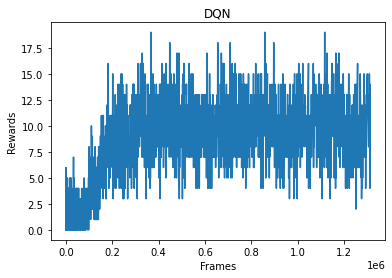

Episode:  2041
Steps:  326662  epsilon:  0.030000078238091258
Episode:  2042
Steps:  326826  epsilon:  0.0300000775991621
Episode:  2043
Steps:  327014  epsilon:  0.03000007687314759
Steps:  327214  epsilon:  0.030000076108246992
Episode:  2044
Steps:  327321  epsilon:  0.030000075702155134
Episode:  2045
Steps:  327511  epsilon:  0.03000007498638993
Steps:  327711  epsilon:  0.03000007424026288
Episode:  2046
Steps:  327729  epsilon:  0.030000074173476703
Episode:  2047
Steps:  327869  epsilon:  0.030000073656075384
Episode:  2048
Steps:  328065  epsilon:  0.030000072937771283
Episode:  2049
Steps:  328227  epsilon:  0.03000007234936161
Episode:  2050
Steps:  328352  epsilon:  0.030000071898588238


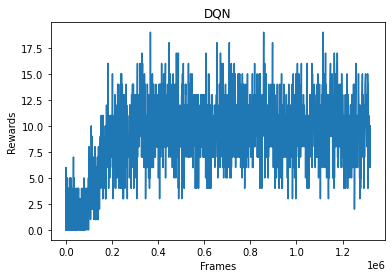

Episode:  2051
Steps:  328545  epsilon:  0.030000071208103805
Episode:  2052
Steps:  328699  epsilon:  0.030000070661906963
Steps:  328899  epsilon:  0.03000006995880924
Episode:  2053
Steps:  328922  epsilon:  0.030000069878402855
Steps:  329122  epsilon:  0.03000006918310113
Episode:  2054
Steps:  329197  epsilon:  0.030000068924150334
Episode:  2055
Steps:  329394  epsilon:  0.0300000682485801
Episode:  2056
Steps:  329506  epsilon:  0.030000067867456195
Episode:  2057
Steps:  329649  epsilon:  0.030000067383934532
Episode:  2058
Steps:  329812  epsilon:  0.0300000668369873
Episode:  2059
Steps:  329921  epsilon:  0.030000066473716534
Episode:  2060
Steps:  330060  epsilon:  0.030000066013325916


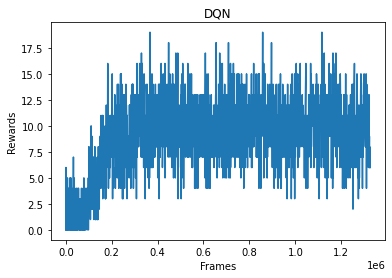

Episode:  2061
Steps:  330209  epsilon:  0.030000065523354047
Steps:  330409  epsilon:  0.030000064871385783
Episode:  2062
Steps:  330413  epsilon:  0.030000064858412803
Steps:  330613  epsilon:  0.030000064213060812
Episode:  2063
Steps:  330651  epsilon:  0.030000064091171827
Steps:  330851  epsilon:  0.030000063453454014
Episode:  2064
Steps:  331020  epsilon:  0.030000062919531327
Steps:  331220  epsilon:  0.03000006229347153
Episode:  2065
Steps:  331328  epsilon:  0.03000006195799339
Steps:  331528  epsilon:  0.030000061341501055
Steps:  331728  epsilon:  0.030000060731142923
Episode:  2066
Steps:  331744  epsilon:  0.030000060682577434
Steps:  331944  epsilon:  0.0300000600787757
Episode:  2067
Steps:  331995  epsilon:  0.030000059925769988
Steps:  332195  epsilon:  0.030000059329498615
Steps:  332395  epsilon:  0.03000005873916024
Episode:  2068
Steps:  332485  epsilon:  0.03000005847542786
Episode:  2069
Steps:  332578  epsilon:  0.030000058204148337
Episode:  2070
Steps:  33

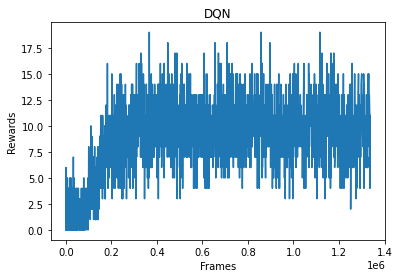

Episode:  2071
Steps:  332926  epsilon:  0.030000057200156218
Steps:  333126  epsilon:  0.03000005663100515
Episode:  2072
Steps:  333137  epsilon:  0.030000056599866664
Episode:  2073
Steps:  333327  epsilon:  0.03000005606471393
Steps:  333527  epsilon:  0.030000055506860707
Episode:  2074
Steps:  333544  epsilon:  0.03000005545969992
Episode:  2075
Steps:  333697  epsilon:  0.030000055037051908
Episode:  2076
Steps:  333883  epsilon:  0.03000005452758004
Episode:  2077
Steps:  334010  epsilon:  0.030000054182426926
Steps:  334210  epsilon:  0.03000005364330277
Episode:  2078
Steps:  334235  epsilon:  0.030000053576290535
Episode:  2079
Steps:  334403  epsilon:  0.030000053128134585
Episode:  2080
Steps:  334575  epsilon:  0.030000052673191686


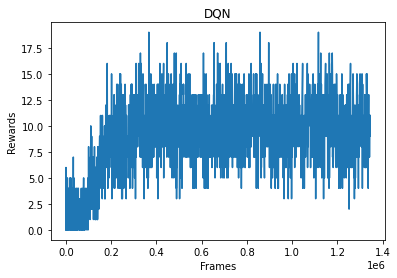

Episode:  2081
Steps:  334757  epsilon:  0.030000052196039975
Steps:  334957  epsilon:  0.030000051676680697
Episode:  2082
Steps:  334965  epsilon:  0.03000005165601416
Episode:  2083
Steps:  335143  epsilon:  0.030000051198315416
Episode:  2084
Steps:  335290  epsilon:  0.030000050823387345
Episode:  2085
Steps:  335432  epsilon:  0.03000005046381927
Steps:  335632  epsilon:  0.03000004996169588
Steps:  335832  epsilon:  0.0300000494645687
Episode:  2086
Steps:  335964  epsilon:  0.030000049139177518
Episode:  2087
Steps:  336112  epsilon:  0.030000048776889724
Episode:  2088
Steps:  336300  epsilon:  0.030000048320535187
Episode:  2089
Steps:  336469  epsilon:  0.03000004791394692
Episode:  2090
Steps:  336608  epsilon:  0.030000047582099492


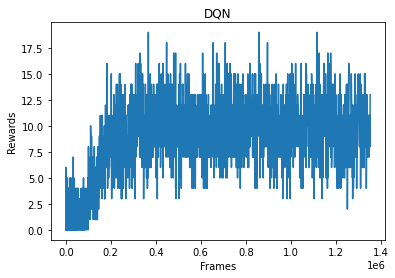

Episode:  2091
Steps:  336802  epsilon:  0.030000047122784406
Steps:  337002  epsilon:  0.03000004665390487
Episode:  2092
Steps:  337043  epsilon:  0.030000046558362328
Steps:  337243  epsilon:  0.030000046095098883
Episode:  2093
Steps:  337314  epsilon:  0.030000045931751394
Steps:  337514  epsilon:  0.030000045474722833
Episode:  2094
Steps:  337548  epsilon:  0.030000045397481478
Episode:  2095
Steps:  337685  epsilon:  0.030000045087571384
Episode:  2096
Steps:  337867  epsilon:  0.030000044679135685
Episode:  2097
Steps:  338012  epsilon:  0.030000044356383343
Episode:  2098
Steps:  338137  epsilon:  0.03000004408002048
Episode:  2099
Steps:  338291  epsilon:  0.030000043741907727
Steps:  338491  epsilon:  0.030000043306668472
Episode:  2100
Steps:  338499  epsilon:  0.030000043289349267
Steps:  338699  epsilon:  0.030000042858613046


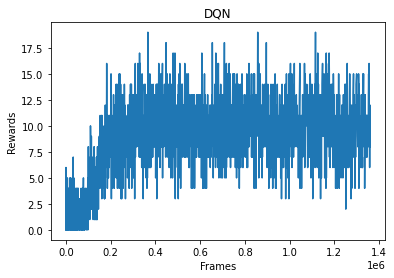

Episode:  2101
Steps:  338713  epsilon:  0.030000042828622515
Steps:  338913  epsilon:  0.0300000424024706
Episode:  2102
Steps:  338995  epsilon:  0.030000042228976377
Episode:  2103
Steps:  339144  epsilon:  0.030000041915539507
Episode:  2104
Steps:  339341  epsilon:  0.030000041504698156
Episode:  2105
Steps:  339521  epsilon:  0.030000041132831782
Steps:  339721  epsilon:  0.030000040723553268
Episode:  2106
Steps:  339742  epsilon:  0.03000004068081598
Episode:  2107
Steps:  339916  epsilon:  0.03000004032842799
Episode:  2108
Steps:  340052  epsilon:  0.030000040055124962
Steps:  340252  epsilon:  0.03000003965656981
Episode:  2109
Steps:  340379  epsilon:  0.030000039405548427
Episode:  2110
Steps:  340484  epsilon:  0.030000039199211407


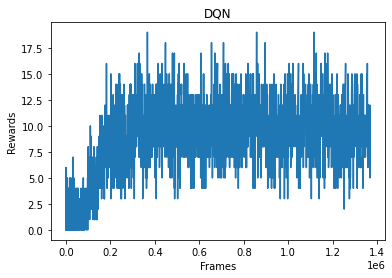

Episode:  2111
Steps:  340660  epsilon:  0.030000038855771696
Steps:  340860  epsilon:  0.03000003846915031
Episode:  2112
Steps:  340907  epsilon:  0.030000038378853948
Episode:  2113
Steps:  341072  epsilon:  0.0300000380635309
Steps:  341272  epsilon:  0.030000037684792438
Episode:  2114
Steps:  341280  epsilon:  0.030000037669721535
Episode:  2115
Steps:  341470  epsilon:  0.030000037313553655
Episode:  2116
Steps:  341606  epsilon:  0.030000037060682227
Steps:  341806  epsilon:  0.030000036691922277
Episode:  2117
Steps:  341847  epsilon:  0.030000036616780884
Episode:  2118
Steps:  342045  epsilon:  0.03000003625606325
Episode:  2119
Steps:  342218  epsilon:  0.030000035943800785
Steps:  342418  epsilon:  0.030000035586153995
Steps:  342618  epsilon:  0.030000035232065844
Episode:  2120
Steps:  342624  epsilon:  0.03000003522149781


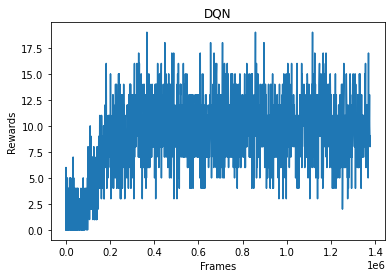

Episode:  2121
Steps:  342784  epsilon:  0.030000034940849917
Episode:  2122
Steps:  342961  epsilon:  0.030000034632987695
Steps:  343161  epsilon:  0.030000034288383708
Steps:  343361  epsilon:  0.03000003394720859
Steps:  343561  epsilon:  0.030000033609428222
Episode:  2123
Steps:  343569  epsilon:  0.030000033595987137
Episode:  2124
Steps:  343690  epsilon:  0.030000033393345026
Episode:  2125
Steps:  343864  epsilon:  0.03000003310408304
Episode:  2126
Steps:  343925  epsilon:  0.030000033003269404
Steps:  344125  epsilon:  0.030000032674881386
Steps:  344325  epsilon:  0.030000032349760886
Episode:  2127
Steps:  344358  epsilon:  0.03000003229642779
Episode:  2128
Steps:  344548  epsilon:  0.0300000319910645
Steps:  344748  epsilon:  0.03000003167274809
Episode:  2129
Steps:  344773  epsilon:  0.03000003163318189
Episode:  2130
Steps:  344937  epsilon:  0.030000031374850404


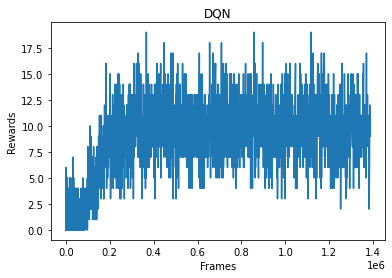

Episode:  2131
Steps:  345112  epsilon:  0.030000031101518037
Episode:  2132
Steps:  345256  epsilon:  0.030000030878391325
Episode:  2133
Steps:  345413  epsilon:  0.030000030636944872
Steps:  345613  epsilon:  0.030000030332102176
Episode:  2134
Steps:  345620  epsilon:  0.0300000303214878
Episode:  2135
Steps:  345743  epsilon:  0.030000030135582893
Episode:  2136
Steps:  345855  epsilon:  0.030000029967295273
Episode:  2137
Steps:  346017  epsilon:  0.030000029725540608
Episode:  2138
Steps:  346119  epsilon:  0.030000029574326275
Episode:  2139
Steps:  346309  epsilon:  0.0300000292947005
Episode:  2140
Steps:  346487  epsilon:  0.03000002903513445


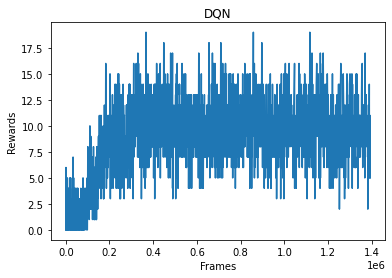

Episode:  2141
Steps:  346595  epsilon:  0.030000028878767297
Episode:  2142
Steps:  346743  epsilon:  0.03000002866585317
Steps:  346943  epsilon:  0.030000028380623166
Episode:  2143
Steps:  347040  epsilon:  0.030000028243310398
Episode:  2144
Steps:  347176  epsilon:  0.030000028051907393
Steps:  347376  epsilon:  0.03000002777278625
Episode:  2145
Steps:  347389  epsilon:  0.030000027754739807
Episode:  2146
Steps:  347586  epsilon:  0.030000027482697627
Episode:  2147
Steps:  347710  epsilon:  0.03000002731283203
Steps:  347910  epsilon:  0.03000002704106481
Episode:  2148
Steps:  347930  epsilon:  0.03000002701403726
Episode:  2149
Steps:  348128  epsilon:  0.030000026747917755
Episode:  2150
Steps:  348292  epsilon:  0.03000002652948164


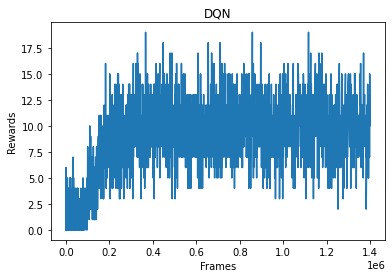

Episode:  2151
Steps:  348467  epsilon:  0.030000026298361303
Episode:  2152
Steps:  348623  epsilon:  0.030000026094032007
Episode:  2153
Steps:  348796  epsilon:  0.03000002586929203
Episode:  2154
Steps:  348990  epsilon:  0.030000025619572993
Steps:  349190  epsilon:  0.030000025364653984
Episode:  2155
Steps:  349229  epsilon:  0.0300000253152411
Steps:  349429  epsilon:  0.030000025063350245
Episode:  2156
Steps:  349441  epsilon:  0.030000025048316743
Episode:  2157
Steps:  349610  epsilon:  0.03000002483755021
Episode:  2158
Steps:  349777  epsilon:  0.03000002463102013
Episode:  2159
Steps:  349928  epsilon:  0.03000002444575618
Steps:  350128  epsilon:  0.03000002420251684
Episode:  2160
Steps:  350280  epsilon:  0.030000024019274915


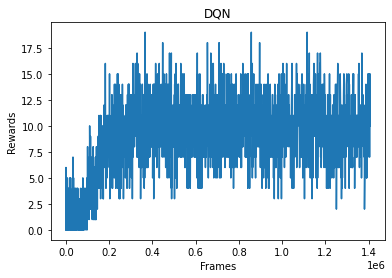

Episode:  2161
Steps:  350453  epsilon:  0.03000002381240419
Steps:  350653  epsilon:  0.03000002357546681
Episode:  2162
Steps:  350688  epsilon:  0.030000023534245822
Steps:  350888  epsilon:  0.030000023300076162
Episode:  2163
Steps:  351002  epsilon:  0.03000002316764352
Steps:  351202  epsilon:  0.030000022937121618
Episode:  2164
Steps:  351222  epsilon:  0.03000002291419596
Episode:  2165
Steps:  351378  epsilon:  0.030000022736160474
Episode:  2166
Steps:  351521  epsilon:  0.030000022574176707
Steps:  351721  epsilon:  0.030000022349559896
Episode:  2167
Steps:  351754  epsilon:  0.03000002231271353
Episode:  2168
Steps:  351902  epsilon:  0.030000022148208867
Episode:  2169
Steps:  352029  epsilon:  0.03000002200801333
Episode:  2170
Steps:  352156  epsilon:  0.03000002186870522


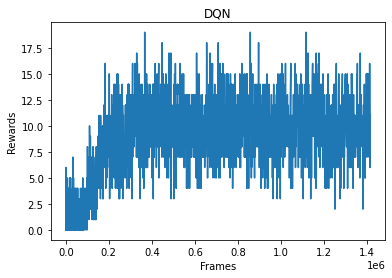

Episode:  2171
Steps:  352340  epsilon:  0.030000021668435784
Steps:  352540  epsilon:  0.030000021452831243
Episode:  2172
Steps:  352548  epsilon:  0.030000021444251828
Episode:  2173
Steps:  352651  epsilon:  0.03000002133409782
Episode:  2174
Steps:  352727  epsilon:  0.030000021253182088
Episode:  2175
Steps:  352870  epsilon:  0.0300000211017638
Episode:  2176
Steps:  353039  epsilon:  0.03000002092420514
Episode:  2177
Steps:  353192  epsilon:  0.03000002076474568
Steps:  353392  epsilon:  0.030000020558133007
Episode:  2178
Steps:  353579  epsilon:  0.03000002036681029
Steps:  353779  epsilon:  0.03000002016415714
Steps:  353979  epsilon:  0.030000019963520426
Episode:  2179
Steps:  354014  epsilon:  0.030000019928614816
Steps:  354214  epsilon:  0.030000019730321785
Episode:  2180
Steps:  354219  epsilon:  0.030000019725389824
Steps:  354419  epsilon:  0.030000019529118915


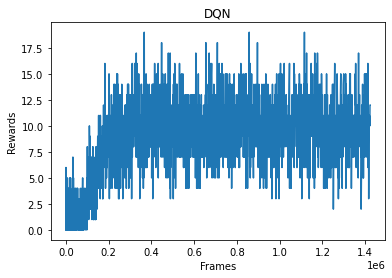

Episode:  2181
Steps:  354428  epsilon:  0.030000019520332787
Steps:  354628  epsilon:  0.03000001932610223
Episode:  2182
Steps:  354647  epsilon:  0.030000019307751154
Steps:  354847  epsilon:  0.03000001911563582
Episode:  2183
Steps:  354851  epsilon:  0.030000019111813072
Episode:  2184
Steps:  355013  epsilon:  0.03000001895763266
Episode:  2185
Steps:  355129  epsilon:  0.030000018847996645
Episode:  2186
Steps:  355313  epsilon:  0.03000001867539028
Episode:  2187
Steps:  355457  epsilon:  0.030000018541410378
Episode:  2188
Steps:  355650  epsilon:  0.030000018363346308
Steps:  355850  epsilon:  0.03000001818062796
Episode:  2189
Steps:  355956  epsilon:  0.03000001808452553
Steps:  356156  epsilon:  0.030000017904581493
Episode:  2190
Steps:  356188  epsilon:  0.030000017875957068


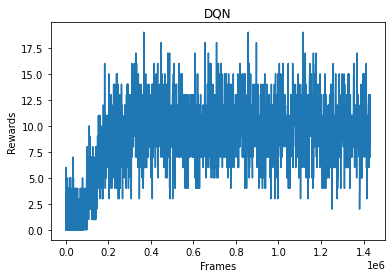

Episode:  2191
Steps:  356343  epsilon:  0.030000017737953855
Episode:  2192
Steps:  356503  epsilon:  0.030000017596616326
Episode:  2193
Steps:  356597  epsilon:  0.030000017514106282
Episode:  2194
Steps:  356794  epsilon:  0.03000001734243918
Episode:  2195
Steps:  356937  epsilon:  0.03000001721888298
Episode:  2196
Steps:  357106  epsilon:  0.030000017073996427
Episode:  2197
Steps:  357242  epsilon:  0.03000001695828711
Episode:  2198
Steps:  357393  epsilon:  0.03000001683073416
Steps:  357593  epsilon:  0.030000016663265558
Episode:  2199
Steps:  357741  epsilon:  0.03000001654041251
Steps:  357941  epsilon:  0.030000016375832654
Episode:  2200
Steps:  358009  epsilon:  0.03000001632024937
Steps:  358209  epsilon:  0.030000016157860174


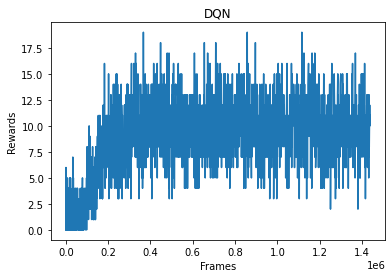

Episode:  2201
Steps:  358288  epsilon:  0.030000016094162512
Steps:  358488  epsilon:  0.03000001593402292
Episode:  2202
Steps:  358509  epsilon:  0.030000015917300976
Episode:  2203
Steps:  358709  epsilon:  0.030000015758921184
Steps:  358909  epsilon:  0.0300000156021173
Episode:  2204
Steps:  358926  epsilon:  0.030000015588861135
Episode:  2205
Steps:  359077  epsilon:  0.03000001547160842
Steps:  359277  epsilon:  0.03000001531766334
Episode:  2206
Steps:  359288  epsilon:  0.030000015309240943
Episode:  2207
Steps:  359416  epsilon:  0.03000001521157467
Episode:  2208
Steps:  359564  epsilon:  0.030000015099424484
Steps:  359764  epsilon:  0.0300000149491827
Episode:  2209
Steps:  359794  epsilon:  0.030000014926775734
Episode:  2210
Steps:  359894  epsilon:  0.03000001485232813
Steps:  360094  epsilon:  0.030000014704544997


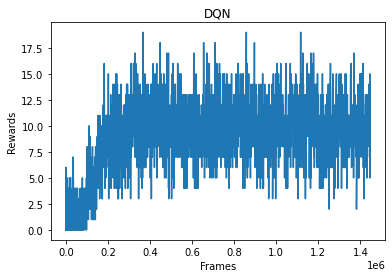

Episode:  2211
Steps:  360121  epsilon:  0.030000014684707255
Steps:  360321  epsilon:  0.030000014538591975
Episode:  2212
Steps:  360341  epsilon:  0.03000001452406065
Episode:  2213
Steps:  360518  epsilon:  0.03000001439608982
Steps:  360718  epsilon:  0.030000014252846333
Episode:  2214
Steps:  360808  epsilon:  0.030000014188852616
Episode:  2215
Steps:  360983  epsilon:  0.030000014065241744
Episode:  2216
Steps:  361118  epsilon:  0.030000013970621065
Steps:  361318  epsilon:  0.030000013831611064
Episode:  2217
Steps:  361486  epsilon:  0.030000013715912148
Episode:  2218
Steps:  361616  epsilon:  0.03000001362704784
Episode:  2219
Steps:  361744  epsilon:  0.03000001354011322
Episode:  2220
Steps:  361898  epsilon:  0.03000001343625472


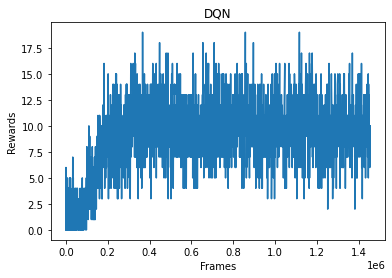

Episode:  2221
Steps:  362075  epsilon:  0.030000013317868494
Steps:  362275  epsilon:  0.03000001318535349
Episode:  2222
Steps:  362337  epsilon:  0.030000013144542183
Episode:  2223
Steps:  362476  epsilon:  0.03000001305350434
Steps:  362676  epsilon:  0.030000012923619798
Steps:  362876  epsilon:  0.030000012795027634
Episode:  2224
Steps:  362945  epsilon:  0.03000001275096085
Episode:  2225
Steps:  363097  epsilon:  0.03000001265442086
Episode:  2226
Steps:  363273  epsilon:  0.030000012543550503
Episode:  2227
Steps:  363466  epsilon:  0.030000012423087412
Episode:  2228
Steps:  363634  epsilon:  0.030000012319170537
Steps:  363834  epsilon:  0.03000001219659274
Episode:  2229
Steps:  363933  epsilon:  0.030000012136368787
Episode:  2230
Steps:  364094  epsilon:  0.030000012039063197


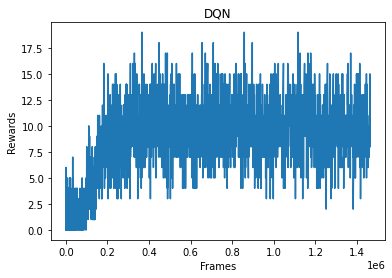

Episode:  2231
Steps:  364252  epsilon:  0.030000011944329292
Episode:  2232
Steps:  364451  epsilon:  0.030000011826072516
Episode:  2233
Steps:  364603  epsilon:  0.030000011736535038
Episode:  2234
Steps:  364760  epsilon:  0.030000011644763912
Episode:  2235
Steps:  364959  epsilon:  0.030000011529473035
Steps:  365159  epsilon:  0.03000001141475286
Episode:  2236
Steps:  365178  epsilon:  0.030000011403913996
Steps:  365378  epsilon:  0.030000011290443156
Episode:  2237
Steps:  365392  epsilon:  0.03000001128254261
Steps:  365592  epsilon:  0.030000011170279436
Episode:  2238
Steps:  365598  epsilon:  0.030000011166928853
Episode:  2239
Steps:  365779  epsilon:  0.03000001106632407
Episode:  2240
Steps:  365971  epsilon:  0.03000001096059567
Steps:  366171  epsilon:  0.03000001085153592


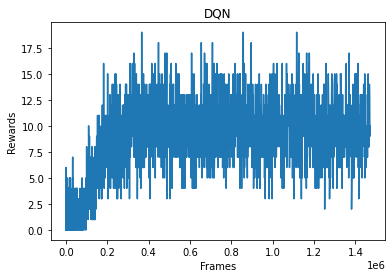

Episode:  2241
Steps:  366326  epsilon:  0.03000001076776156
Episode:  2242
Steps:  366502  epsilon:  0.030000010673420965
Steps:  366702  epsilon:  0.030000010567218655
Episode:  2243
Steps:  366717  epsilon:  0.03000001055929621
Episode:  2244
Steps:  366868  epsilon:  0.03000001047987372
Episode:  2245
Steps:  367025  epsilon:  0.030000010397928767
Episode:  2246
Steps:  367219  epsilon:  0.030000010297556452
Episode:  2247
Steps:  367399  epsilon:  0.030000010205294247
Episode:  2248
Steps:  367582  epsilon:  0.03000001011234171
Steps:  367782  epsilon:  0.030000010011722228
Episode:  2249
Steps:  367791  epsilon:  0.030000010007217966
Episode:  2250
Steps:  367956  epsilon:  0.03000000992499804


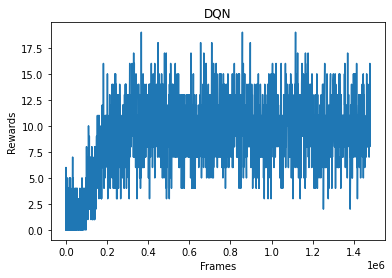

Episode:  2251
Steps:  368141  epsilon:  0.03000000983361511
Episode:  2252
Steps:  368280  epsilon:  0.03000000976550843
Steps:  368480  epsilon:  0.030000009668339996
Steps:  368680  epsilon:  0.030000009572138404
Episode:  2253
Steps:  368683  epsilon:  0.03000000957070269
Steps:  368883  epsilon:  0.03000000947547261
Episode:  2254
Steps:  369034  epsilon:  0.030000009404202176
Steps:  369234  epsilon:  0.0300000093106288
Episode:  2255
Steps:  369241  epsilon:  0.03000000930737065
Steps:  369441  epsilon:  0.030000009214760766
Episode:  2256
Steps:  369480  epsilon:  0.03000000919680949
Episode:  2257
Steps:  369640  epsilon:  0.03000000912352853
Episode:  2258
Steps:  369753  epsilon:  0.03000000907212594
Episode:  2259
Steps:  369928  epsilon:  0.03000000899309112
Episode:  2260
Steps:  370084  epsilon:  0.030000008923217872


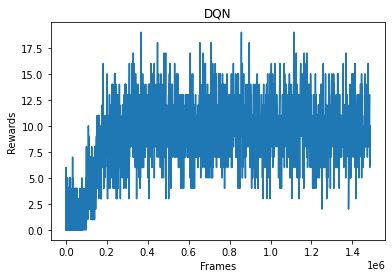

Episode:  2261
Steps:  370253  epsilon:  0.030000008848134353
Episode:  2262
Steps:  370421  epsilon:  0.030000008774121314
Steps:  370621  epsilon:  0.03000000868681735
Episode:  2263
Steps:  370625  epsilon:  0.03000000868508016
Episode:  2264
Steps:  370783  epsilon:  0.030000008616738332
Episode:  2265
Steps:  370887  epsilon:  0.030000008572047588
Episode:  2266
Steps:  371083  epsilon:  0.030000008488451812
Steps:  371283  epsilon:  0.030000008403990305
Episode:  2267
Steps:  371337  epsilon:  0.030000008381330136
Episode:  2268
Steps:  371478  epsilon:  0.030000008322449555
Episode:  2269
Steps:  371648  epsilon:  0.030000008252008534
Steps:  371848  epsilon:  0.030000008169899676
Episode:  2270
Steps:  371858  epsilon:  0.030000008165815748
Steps:  372058  epsilon:  0.030000008084564524


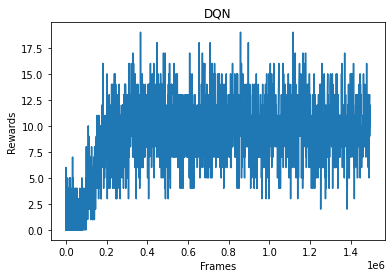

Episode:  2271
Steps:  372098  epsilon:  0.030000008068411552
Episode:  2272
Steps:  372240  epsilon:  0.030000008011328714
Steps:  372440  epsilon:  0.030000007931614663
Steps:  372640  epsilon:  0.03000000785269378
Episode:  2273
Steps:  372724  epsilon:  0.030000007819781627
Steps:  372924  epsilon:  0.030000007741973502
Steps:  373124  epsilon:  0.030000007664939578
Steps:  373324  epsilon:  0.030000007588672155
Episode:  2274
Steps:  373415  epsilon:  0.03000000755422213
Episode:  2275
Steps:  373595  epsilon:  0.03000000748653916
Steps:  373795  epsilon:  0.03000000741204685
Steps:  373995  epsilon:  0.03000000733829575
Steps:  374195  epsilon:  0.03000000726527849
Episode:  2276
Steps:  374299  epsilon:  0.030000007227597096
Episode:  2277
Steps:  374471  epsilon:  0.030000007165706274
Episode:  2278
Steps:  374629  epsilon:  0.030000007109320215
Steps:  374829  epsilon:  0.030000007038581297
Episode:  2279
Steps:  374907  epsilon:  0.03000000701118429
Episode:  2280
Steps:  375

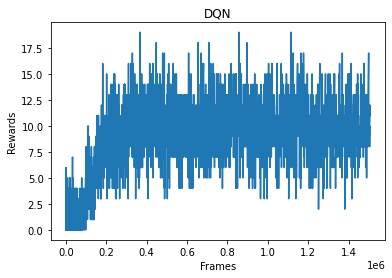

Episode:  2281
Steps:  375271  epsilon:  0.030000006884734913
Episode:  2282
Steps:  375431  epsilon:  0.03000000682987676
Episode:  2283
Steps:  375578  epsilon:  0.030000006779861196
Steps:  375778  epsilon:  0.03000000671240045
Episode:  2284
Steps:  375806  epsilon:  0.030000006703009664
Steps:  376006  epsilon:  0.030000006636313605
Episode:  2285
Steps:  376007  epsilon:  0.030000006635981798
Episode:  2286
Steps:  376135  epsilon:  0.03000000659364713
Steps:  376335  epsilon:  0.030000006528039243
Episode:  2287
Steps:  376338  epsilon:  0.03000000652706011
Episode:  2288
Steps:  376528  epsilon:  0.030000006465346642
Episode:  2289
Steps:  376677  epsilon:  0.03000000641735879
Episode:  2290
Steps:  376778  epsilon:  0.030000006385032817


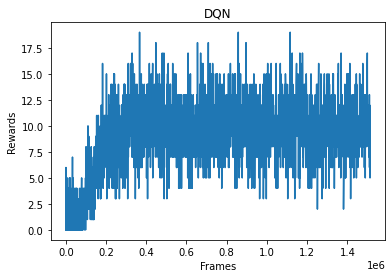

Episode:  2291
Steps:  376938  epsilon:  0.030000006334156334
Episode:  2292
Steps:  377108  epsilon:  0.030000006280544177
Episode:  2293
Steps:  377254  epsilon:  0.030000006234863145
Steps:  377454  epsilon:  0.03000000617282522
Episode:  2294
Steps:  377469  epsilon:  0.030000006168197337
Steps:  377669  epsilon:  0.030000006106822748
Steps:  377869  epsilon:  0.030000006046058847
Episode:  2295
Steps:  377876  epsilon:  0.030000006043943095
Episode:  2296
Steps:  378031  epsilon:  0.030000005997283575
Steps:  378231  epsilon:  0.030000005937609608
Episode:  2297
Steps:  378377  epsilon:  0.03000000589442288
Episode:  2298
Steps:  378566  epsilon:  0.03000000583898295
Episode:  2299
Steps:  378701  epsilon:  0.030000005799702537
Episode:  2300
Steps:  378852  epsilon:  0.030000005756079664


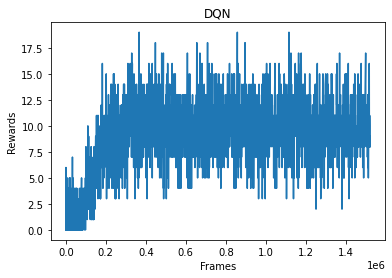

Episode:  2301
Steps:  379010  epsilon:  0.03000000571078578
Steps:  379210  epsilon:  0.030000005653962512
Episode:  2302
Steps:  379289  epsilon:  0.03000000563167341
Episode:  2303
Steps:  379427  epsilon:  0.03000000559294862
Steps:  379627  epsilon:  0.030000005537297852
Steps:  379827  epsilon:  0.030000005482200817
Episode:  2304
Steps:  379887  epsilon:  0.03000000546577886
Episode:  2305
Steps:  380040  epsilon:  0.03000000542412518
Episode:  2306
Steps:  380197  epsilon:  0.030000005381712484
Episode:  2307
Steps:  380367  epsilon:  0.030000005336161793
Episode:  2308
Steps:  380510  epsilon:  0.03000000529814431
Episode:  2309
Steps:  380599  epsilon:  0.030000005274619948
Episode:  2310
Steps:  380766  epsilon:  0.03000000523076024


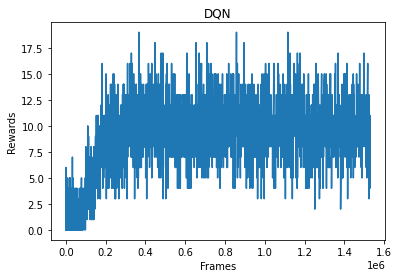

Episode:  2311
Steps:  380940  epsilon:  0.030000005185450013
Episode:  2312
Steps:  381098  epsilon:  0.030000005144646343
Episode:  2313
Steps:  381228  epsilon:  0.03000000511131459
Episode:  2314
Steps:  381417  epsilon:  0.030000005063240177
Steps:  381617  epsilon:  0.030000005012860095
Episode:  2315
Steps:  381621  epsilon:  0.030000005011857622
Steps:  381821  epsilon:  0.030000004961988805
Episode:  2316
Steps:  381880  epsilon:  0.030000004947372507
Episode:  2317
Steps:  382023  epsilon:  0.030000004912124956
Steps:  382223  epsilon:  0.030000004863248494
Episode:  2318
Steps:  382280  epsilon:  0.030000004849407968
Episode:  2319
Steps:  382436  epsilon:  0.030000004811729722
Episode:  2320
Steps:  382585  epsilon:  0.030000004776015537
Steps:  382785  epsilon:  0.030000004728493387


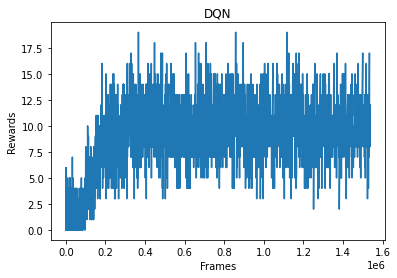

Episode:  2321
Steps:  382794  epsilon:  0.030000004726366044
Episode:  2322
Steps:  382942  epsilon:  0.030000004691520026
Episode:  2323
Steps:  383077  epsilon:  0.030000004659958904
Steps:  383277  epsilon:  0.03000000461359154
Episode:  2324
Steps:  383330  epsilon:  0.030000004601381705
Steps:  383530  epsilon:  0.030000004555597194
Episode:  2325
Steps:  383725  epsilon:  0.03000000451139595
Episode:  2326
Steps:  383842  epsilon:  0.03000000448508133
Steps:  384042  epsilon:  0.030000004440454024
Episode:  2327
Steps:  384108  epsilon:  0.030000004425824678
Steps:  384308  epsilon:  0.030000004381786988
Episode:  2328
Steps:  384344  epsilon:  0.030000004373906864
Episode:  2329
Steps:  384497  epsilon:  0.03000000434057414
Steps:  384697  epsilon:  0.030000004297384704
Episode:  2330
Steps:  384761  epsilon:  0.03000000428365505
Steps:  384961  epsilon:  0.030000004241031972


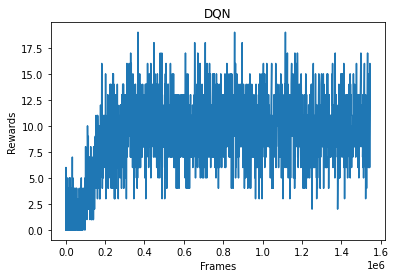

Episode:  2331
Steps:  385130  epsilon:  0.030000004205346237
Steps:  385330  epsilon:  0.03000000416350234
Episode:  2332
Steps:  385345  epsilon:  0.030000004160380886
Episode:  2333
Steps:  385470  epsilon:  0.030000004134459593
Steps:  385670  epsilon:  0.030000004093321035
Episode:  2334
Steps:  385685  epsilon:  0.030000004090252195
Episode:  2335
Steps:  385825  epsilon:  0.030000004061720407
Steps:  386025  epsilon:  0.030000004021305614
Episode:  2336
Steps:  386086  epsilon:  0.030000004009059316
Steps:  386286  epsilon:  0.03000000396916851
Episode:  2337
Steps:  386393  epsilon:  0.03000000394799016
Steps:  386593  epsilon:  0.030000003908707003
Episode:  2338
Steps:  386670  epsilon:  0.03000000389368741
Episode:  2339
Steps:  386831  epsilon:  0.03000000386246905
Episode:  2340
Steps:  386952  epsilon:  0.030000003839171657


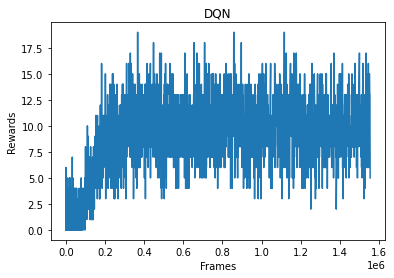

Episode:  2341
Steps:  387070  epsilon:  0.030000003816587236
Steps:  387270  epsilon:  0.030000003778611558
Episode:  2342
Steps:  387369  epsilon:  0.030000003759953646
Steps:  387569  epsilon:  0.030000003722541482
Episode:  2343
Steps:  387622  epsilon:  0.030000003712689807
Episode:  2344
Steps:  387741  epsilon:  0.03000000369066489
Steps:  387941  epsilon:  0.03000000365394216
Episode:  2345
Steps:  388006  epsilon:  0.030000003642086128
Steps:  388206  epsilon:  0.030000003605846762
Episode:  2346
Steps:  388226  epsilon:  0.03000000360224272
Steps:  388426  epsilon:  0.030000003566399806
Episode:  2347
Steps:  388463  epsilon:  0.030000003559808065
Steps:  388663  epsilon:  0.03000000352438738
Episode:  2348
Steps:  388675  epsilon:  0.030000003522273385
Episode:  2349
Steps:  388856  epsilon:  0.03000000349054062
Episode:  2350
Steps:  388991  epsilon:  0.03000000346705881


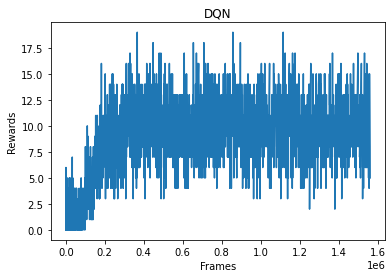

Episode:  2351
Steps:  389094  epsilon:  0.030000003449249354
Episode:  2352
Steps:  389232  epsilon:  0.030000003425531455
Episode:  2353
Steps:  389399  epsilon:  0.030000003397047354
Steps:  389599  epsilon:  0.03000000336324617
Episode:  2354
Steps:  389601  epsilon:  0.03000000336290986
Episode:  2355
Steps:  389768  epsilon:  0.030000003334946474
Steps:  389968  epsilon:  0.030000003301763202
Episode:  2356
Steps:  389974  epsilon:  0.03000000330077282
Steps:  390174  epsilon:  0.030000003267929582
Episode:  2357
Steps:  390234  epsilon:  0.030000003258140485
Episode:  2358
Steps:  390405  epsilon:  0.030000003230402132
Episode:  2359
Steps:  390530  epsilon:  0.030000003210275083
Episode:  2360
Steps:  390693  epsilon:  0.03000000318421767


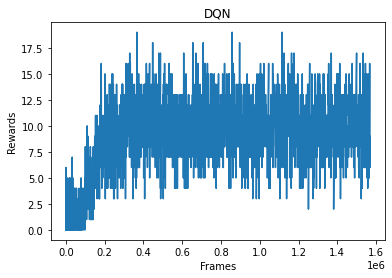

Episode:  2361
Steps:  390860  epsilon:  0.030000003157740148
Steps:  391060  epsilon:  0.03000000312632011
Steps:  391260  epsilon:  0.030000003095212707
Steps:  391460  epsilon:  0.030000003064414825
Steps:  391660  epsilon:  0.030000003033923386
Episode:  2362
Steps:  391713  epsilon:  0.030000003025894135
Steps:  391913  epsilon:  0.030000002995785983
Episode:  2363
Steps:  391930  epsilon:  0.030000002993240647
Steps:  392130  epsilon:  0.030000002963457405
Episode:  2364
Steps:  392176  epsilon:  0.030000002956649285
Episode:  2365
Steps:  392347  epsilon:  0.030000002931477695
Episode:  2366
Steps:  392489  epsilon:  0.030000002910737917
Episode:  2367
Steps:  392682  epsilon:  0.03000000288278439
Steps:  392882  epsilon:  0.030000002854100205
Episode:  2368
Steps:  393006  epsilon:  0.030000002836459528
Episode:  2369
Steps:  393189  epsilon:  0.030000002810624298
Steps:  393389  epsilon:  0.03000000278265812
Episode:  2370
Steps:  393411  epsilon:  0.03000000277959888


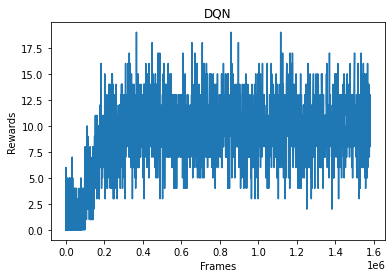

Episode:  2371
Steps:  393590  epsilon:  0.030000002754832465
Steps:  393790  epsilon:  0.030000002727421423
Episode:  2372
Steps:  393862  epsilon:  0.030000002717620357
Episode:  2373
Steps:  394053  epsilon:  0.030000002691790616
Episode:  2374
Steps:  394252  epsilon:  0.030000002665140107
Episode:  2375
Steps:  394436  epsilon:  0.030000002640733263
Episode:  2376
Steps:  394565  epsilon:  0.030000002623755344
Episode:  2377
Steps:  394707  epsilon:  0.030000002605192658
Episode:  2378
Steps:  394851  epsilon:  0.030000002586502636
Episode:  2379
Steps:  395038  epsilon:  0.030000002562431544
Episode:  2380
Steps:  395196  epsilon:  0.030000002542268082
Steps:  395396  epsilon:  0.030000002516972095
Steps:  395596  epsilon:  0.030000002491927802
Steps:  395796  epsilon:  0.03000000246713271


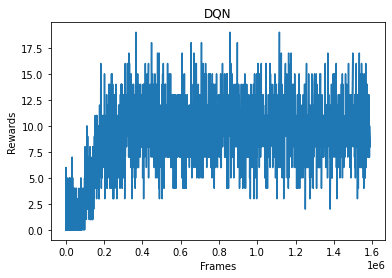

Episode:  2381
Steps:  395991  epsilon:  0.030000002443195048
Episode:  2382
Steps:  396170  epsilon:  0.030000002421426013
Steps:  396370  epsilon:  0.030000002397332425
Episode:  2383
Steps:  396541  epsilon:  0.03000000237692261
Episode:  2384
Steps:  396647  epsilon:  0.030000002364358243
Episode:  2385
Steps:  396749  epsilon:  0.03000000235233071
Steps:  396949  epsilon:  0.030000002328924632
Episode:  2386
Steps:  397089  epsilon:  0.030000002312679085
Episode:  2387
Steps:  397214  epsilon:  0.030000002298269914
Episode:  2388
Steps:  397329  epsilon:  0.030000002285092784
Episode:  2389
Steps:  397444  epsilon:  0.0300000022719912
Episode:  2390
Steps:  397562  epsilon:  0.03000000225862592


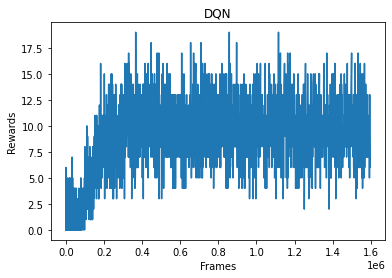

Episode:  2391
Steps:  397679  epsilon:  0.030000002245451532
Steps:  397879  epsilon:  0.030000002223108915
Episode:  2392
Steps:  397952  epsilon:  0.03000000221500936
Episode:  2393
Steps:  398119  epsilon:  0.030000002196591036
Episode:  2394
Steps:  398304  epsilon:  0.030000002176366253
Steps:  398504  epsilon:  0.030000002154711044
Steps:  398704  epsilon:  0.030000002133271312
Episode:  2395
Steps:  398734  epsilon:  0.030000002130073804
Steps:  398934  epsilon:  0.030000002108879216
Episode:  2396
Steps:  398970  epsilon:  0.03000000210508665
Episode:  2397
Steps:  399125  epsilon:  0.03000000208883528
Episode:  2398
Steps:  399297  epsilon:  0.03000000207094832
Steps:  399497  epsilon:  0.03000000205034204
Episode:  2399
Steps:  399536  epsilon:  0.03000000204634777
Episode:  2400
Steps:  399729  epsilon:  0.03000000202669549


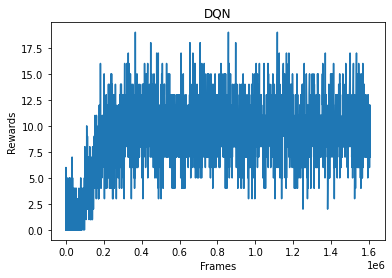

Episode:  2401
Steps:  399857  epsilon:  0.030000002013766056
Episode:  2402
Steps:  399980  epsilon:  0.0300000020014194
Episode:  2403
Steps:  400161  epsilon:  0.03000000198338827
Episode:  2404
Steps:  400309  epsilon:  0.03000000196876537
Episode:  2405
Steps:  400442  epsilon:  0.03000000195571651
Episode:  2406
Steps:  400547  epsilon:  0.030000001945475908
Episode:  2407
Steps:  400693  epsilon:  0.030000001931325643
Episode:  2408
Steps:  400859  epsilon:  0.030000001915361982
Episode:  2409
Steps:  401004  epsilon:  0.030000001901525825
Episode:  2410
Steps:  401171  epsilon:  0.030000001885714188


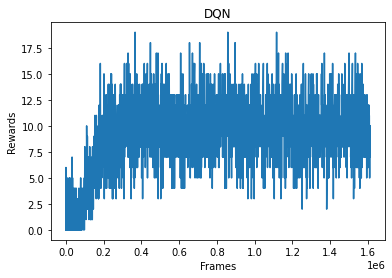

Episode:  2411
Steps:  401289  epsilon:  0.03000000187462123
Episode:  2412
Steps:  401474  epsilon:  0.030000001857360938
Episode:  2413
Steps:  401540  epsilon:  0.03000000185124175
Episode:  2414
Steps:  401662  epsilon:  0.030000001839983546
Episode:  2415
Steps:  401802  epsilon:  0.030000001827148636
Steps:  402002  epsilon:  0.030000001808968203
Episode:  2416
Steps:  402021  epsilon:  0.030000001807250497
Episode:  2417
Steps:  402203  epsilon:  0.03000000179087912
Steps:  402403  epsilon:  0.030000001773059577
Episode:  2418
Steps:  402467  epsilon:  0.030000001767394854
Episode:  2419
Steps:  402606  epsilon:  0.030000001755154045
Steps:  402806  epsilon:  0.030000001737689973
Episode:  2420
Steps:  402849  epsilon:  0.030000001733957952
Steps:  403049  epsilon:  0.03000000171670478


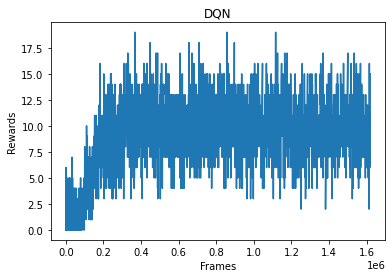

Episode:  2421
Steps:  403080  epsilon:  0.03000000171404595
Episode:  2422
Steps:  403256  epsilon:  0.03000000169902852
Episode:  2423
Steps:  403361  epsilon:  0.030000001690131995
Episode:  2424
Steps:  403526  epsilon:  0.030000001676245766
Episode:  2425
Steps:  403709  epsilon:  0.030000001660978073
Steps:  403909  epsilon:  0.030000001644451064
Episode:  2426
Steps:  404028  epsilon:  0.03000000163469563
Episode:  2427
Steps:  404188  epsilon:  0.030000001621670238
Episode:  2428
Steps:  404350  epsilon:  0.030000001608587765
Episode:  2429
Steps:  404518  epsilon:  0.03000000159513222
Episode:  2430
Steps:  404649  epsilon:  0.030000001584718244
Steps:  404849  epsilon:  0.030000001568950035


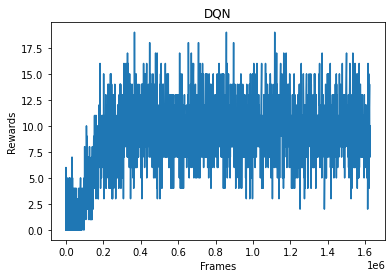

Episode:  2431
Steps:  404858  epsilon:  0.03000000156824417
Steps:  405058  epsilon:  0.030000001552639877
Steps:  405258  epsilon:  0.030000001537190853
Steps:  405458  epsilon:  0.030000001521895546
Episode:  2432
Steps:  405472  epsilon:  0.030000001520830592
Episode:  2433
Steps:  405564  epsilon:  0.03000000151385084
Steps:  405764  epsilon:  0.03000000149878777
Episode:  2434
Steps:  405771  epsilon:  0.030000001498263287
Episode:  2435
Steps:  405841  epsilon:  0.030000001493028533
Steps:  406041  epsilon:  0.03000000147817265
Episode:  2436
Steps:  406150  epsilon:  0.03000000147013852
Steps:  406350  epsilon:  0.0300000014555104
Episode:  2437
Steps:  406386  epsilon:  0.030000001452892836
Episode:  2438
Steps:  406551  epsilon:  0.030000001440955777
Episode:  2439
Steps:  406692  epsilon:  0.030000001430832767
Episode:  2440
Steps:  406822  epsilon:  0.030000001421562512
Steps:  407022  epsilon:  0.03000000140741773
Steps:  407222  epsilon:  0.03000000139341369
Steps:  40742

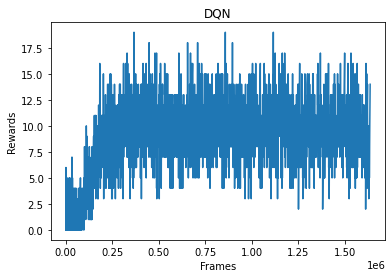

Episode:  2441
Steps:  407598  epsilon:  0.030000001367462222
Steps:  407798  epsilon:  0.030000001353855745
Steps:  407998  epsilon:  0.030000001340384656
Steps:  408198  epsilon:  0.030000001327047606
Steps:  408398  epsilon:  0.03000000131384326
Steps:  408598  epsilon:  0.030000001300770303
Steps:  408798  epsilon:  0.03000000128782742
Episode:  2442
Steps:  408930  epsilon:  0.03000000127935575
Steps:  409130  epsilon:  0.030000001266625945
Episode:  2443
Steps:  409164  epsilon:  0.03000000126447451
Steps:  409364  epsilon:  0.03000000125189278
Episode:  2444
Steps:  409366  epsilon:  0.030000001251767595
Episode:  2445
Steps:  409494  epsilon:  0.030000001243781865
Steps:  409694  epsilon:  0.030000001231406028
Episode:  2446
Steps:  409712  epsilon:  0.03000000123029826
Steps:  409912  epsilon:  0.03000000121805659
Episode:  2447
Steps:  409913  epsilon:  0.030000001217995686
Episode:  2448
Steps:  410064  epsilon:  0.030000001208834448
Steps:  410264  epsilon:  0.0300000011968

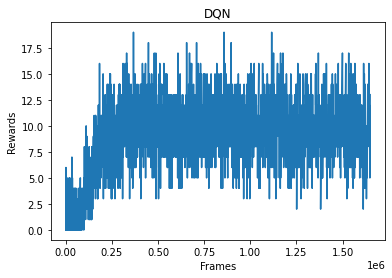

Episode:  2451
Steps:  410849  epsilon:  0.030000001162306774
Episode:  2452
Steps:  411035  epsilon:  0.03000000115154743
Episode:  2453
Steps:  411199  epsilon:  0.03000000114214335
Episode:  2454
Steps:  411355  epsilon:  0.030000001133269286
Episode:  2455
Steps:  411503  epsilon:  0.030000001124914046
Episode:  2456
Steps:  411649  epsilon:  0.030000001116732074
Episode:  2457
Steps:  411803  epsilon:  0.030000001108166256
Episode:  2458
Steps:  411966  epsilon:  0.030000001099171406
Steps:  412166  epsilon:  0.030000001088234467
Episode:  2459
Steps:  412236  epsilon:  0.030000001084432303
Episode:  2460
Steps:  412287  epsilon:  0.030000001081670526


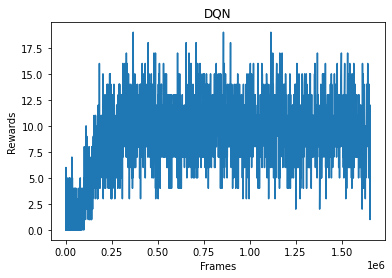

Episode:  2461
Steps:  412422  epsilon:  0.030000001074393837
Episode:  2462
Steps:  412611  epsilon:  0.030000001064288635
Steps:  412811  epsilon:  0.030000001053698787
Episode:  2463
Steps:  412878  epsilon:  0.030000001050174804
Steps:  413078  epsilon:  0.030000001039725388
Episode:  2464
Steps:  413098  epsilon:  0.03000000103868618
Episode:  2465
Steps:  413287  epsilon:  0.030000001028916833
Episode:  2466
Steps:  413413  epsilon:  0.03000000102245503
Steps:  413613  epsilon:  0.030000001012281435
Episode:  2467
Steps:  413618  epsilon:  0.030000001012028394
Steps:  413818  epsilon:  0.030000001001958543
Steps:  414018  epsilon:  0.03000000099198889
Episode:  2468
Steps:  414127  epsilon:  0.030000000986597254
Episode:  2469
Steps:  414224  epsilon:  0.030000000981823843
Episode:  2470
Steps:  414357  epsilon:  0.030000000975316375
Steps:  414557  epsilon:  0.030000000965611815


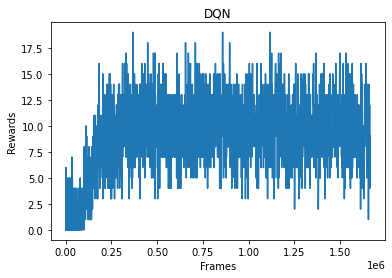

Episode:  2471
Steps:  414620  epsilon:  0.030000000962574925
Episode:  2472
Steps:  414809  epsilon:  0.030000000953521438
Steps:  415009  epsilon:  0.03000000094403374
Episode:  2473
Steps:  415017  epsilon:  0.0300000009436562
Steps:  415217  epsilon:  0.030000000934266666
Episode:  2474
Steps:  415369  epsilon:  0.030000000927193154
Episode:  2475
Steps:  415491  epsilon:  0.03000000092155449
Episode:  2476
Steps:  415649  epsilon:  0.030000000914302893
Episode:  2477
Steps:  415792  epsilon:  0.03000000090778894
Steps:  415992  epsilon:  0.03000000089875629
Episode:  2478
Steps:  416066  epsilon:  0.030000000895437036
Episode:  2479
Steps:  416233  epsilon:  0.030000000887991266
Episode:  2480
Steps:  416358  epsilon:  0.03000000088245863


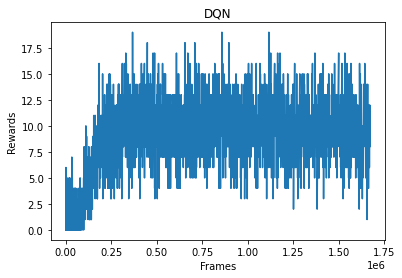

Episode:  2481
Steps:  416530  epsilon:  0.030000000874902025
Episode:  2482
Steps:  416625  epsilon:  0.030000000870756095
Episode:  2483
Steps:  416721  epsilon:  0.03000000086658648
Episode:  2484
Steps:  416905  epsilon:  0.030000000858650445
Steps:  417105  epsilon:  0.03000000085010673
Episode:  2485
Steps:  417108  epsilon:  0.030000000849979225
Episode:  2486
Steps:  417299  epsilon:  0.03000000084190056
Steps:  417499  epsilon:  0.03000000083352351
Episode:  2487
Steps:  417590  epsilon:  0.030000000829739592
Episode:  2488
Steps:  417714  epsilon:  0.03000000082461112
Episode:  2489
Steps:  417824  epsilon:  0.030000000820088208
Steps:  418024  epsilon:  0.030000000811928197
Episode:  2490
Steps:  418180  epsilon:  0.030000000805619792


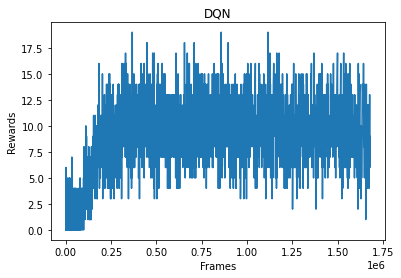

Episode:  2491
Steps:  418310  epsilon:  0.030000000800400245
Steps:  418510  epsilon:  0.03000000079243613
Episode:  2492
Steps:  418601  epsilon:  0.030000000788838733
Episode:  2493
Steps:  418771  epsilon:  0.03000000078216202
Episode:  2494
Steps:  418918  epsilon:  0.030000000776434204
Episode:  2495
Steps:  419023  epsilon:  0.03000000077236861
Episode:  2496
Steps:  419169  epsilon:  0.030000000766750846
Steps:  419369  epsilon:  0.03000000075912155
Steps:  419569  epsilon:  0.03000000075156816
Episode:  2497
Steps:  419589  epsilon:  0.03000000075081697
Episode:  2498
Steps:  419730  epsilon:  0.030000000745542325
Episode:  2499
Steps:  419862  epsilon:  0.03000000074063795
Episode:  2500
Steps:  420011  epsilon:  0.030000000735140697


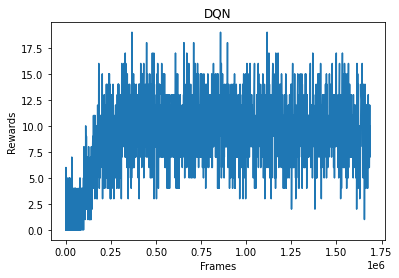

Episode:  2501
Steps:  420195  epsilon:  0.03000000072840842
Episode:  2502
Steps:  420282  epsilon:  0.030000000725246726
Episode:  2503
Steps:  420428  epsilon:  0.0300000007199717
Steps:  420628  epsilon:  0.030000000712807864
Episode:  2504
Steps:  420662  epsilon:  0.03000000071159712
Steps:  420862  epsilon:  0.03000000070451661
Episode:  2505
Steps:  420966  epsilon:  0.03000000070086263
Episode:  2506
Steps:  421118  epsilon:  0.030000000695556264
Episode:  2507
Steps:  421257  epsilon:  0.03000000069073891
Episode:  2508
Steps:  421404  epsilon:  0.03000000068568059
Episode:  2509
Steps:  421565  epsilon:  0.03000000068018302
Episode:  2510
Steps:  421720  epsilon:  0.030000000674931974


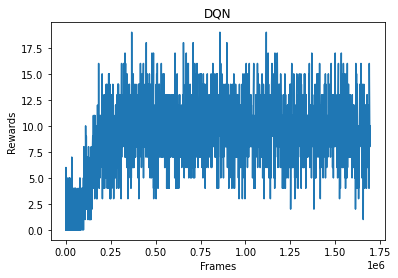

Episode:  2511
Steps:  421878  epsilon:  0.030000000669621017
Steps:  422078  epsilon:  0.030000000662958177
Episode:  2512
Steps:  422239  epsilon:  0.030000000657642786
Steps:  422439  epsilon:  0.030000000651099132
Episode:  2513
Steps:  422457  epsilon:  0.030000000650513406
Episode:  2514
Steps:  422516  epsilon:  0.03000000064859722
Steps:  422716  epsilon:  0.03000000064214357
Steps:  422916  epsilon:  0.030000000635754132
Episode:  2515
Steps:  422956  epsilon:  0.030000000634483895
Steps:  423156  epsilon:  0.030000000628170678
Episode:  2516
Steps:  423220  epsilon:  0.03000000062616374
Steps:  423420  epsilon:  0.03000000061993331
Episode:  2517
Steps:  423432  epsilon:  0.03000000061956146
Episode:  2518
Steps:  423553  epsilon:  0.03000000061582443
Steps:  423753  epsilon:  0.030000000609696875
Episode:  2519
Steps:  423791  epsilon:  0.03000000060853955
Episode:  2520
Steps:  423926  epsilon:  0.03000000060444574


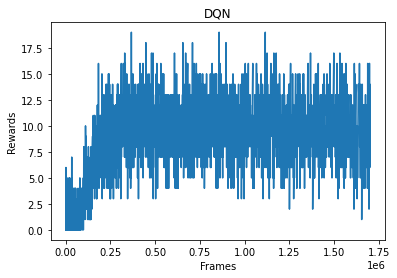

Episode:  2521
Steps:  424076  epsilon:  0.030000000599929355
Steps:  424276  epsilon:  0.030000000593959956
Episode:  2522
Steps:  424300  epsilon:  0.030000000593247634
Episode:  2523
Steps:  424439  epsilon:  0.030000000589138858
Episode:  2524
Steps:  424618  epsilon:  0.03000000058388959
Episode:  2525
Steps:  424739  epsilon:  0.03000000058036772
Episode:  2526
Steps:  424929  epsilon:  0.030000000574880337
Episode:  2527
Steps:  425083  epsilon:  0.030000000570470756
Steps:  425283  epsilon:  0.030000000564794477
Steps:  425483  epsilon:  0.030000000559174678
Steps:  425683  epsilon:  0.030000000553610795
Steps:  425883  epsilon:  0.030000000548102278
Episode:  2528
Steps:  425901  epsilon:  0.030000000547609207
Episode:  2529
Steps:  426044  epsilon:  0.030000000543707765
Steps:  426244  epsilon:  0.030000000538297784
Episode:  2530
Steps:  426259  epsilon:  0.03000000053789421


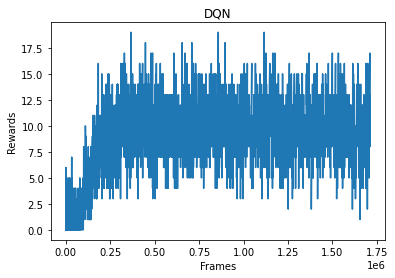

Episode:  2531
Steps:  426411  epsilon:  0.03000000053382171
Episode:  2532
Steps:  426568  epsilon:  0.030000000529647613
Episode:  2533
Steps:  426737  epsilon:  0.03000000052519095
Episode:  2534
Steps:  426930  epsilon:  0.03000000052014723
Episode:  2535
Steps:  427109  epsilon:  0.030000000515512684
Episode:  2536
Steps:  427241  epsilon:  0.030000000512121504
Steps:  427441  epsilon:  0.03000000050702581
Episode:  2537
Steps:  427478  epsilon:  0.030000000506088677
Episode:  2538
Steps:  427589  epsilon:  0.030000000503287664
Steps:  427789  epsilon:  0.03000000049827987
Episode:  2539
Steps:  427818  epsilon:  0.030000000497557886
Episode:  2540
Steps:  427983  epsilon:  0.03000000049346992


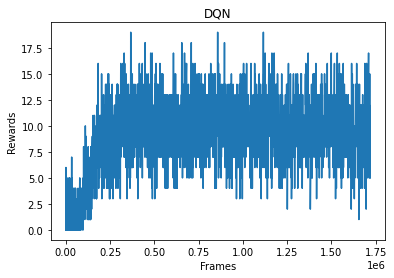

Episode:  2541
Steps:  428133  epsilon:  0.03000000048978274
Episode:  2542
Steps:  428327  epsilon:  0.030000000485054815
Episode:  2543
Steps:  428511  epsilon:  0.030000000480612774
Episode:  2544
Steps:  428640  epsilon:  0.030000000477522798
Episode:  2545
Steps:  428784  epsilon:  0.030000000474096983
Episode:  2546
Steps:  428931  epsilon:  0.030000000470625145
Steps:  429131  epsilon:  0.030000000465942346
Episode:  2547
Steps:  429193  epsilon:  0.030000000464500163
Steps:  429393  epsilon:  0.030000000459878308
Episode:  2548
Steps:  429404  epsilon:  0.030000000459625444


In [0]:
EPSILON = 1
MIN_EPSILON = 0.03
DECAY = 20000
env = gym.make("Breakout-v0")
n_actions = env.action_space.n
agent = Agent(num_frames, n_actions)
durations = []
Rewards=[]
frames=[]
frame_cnt=0
steps_done=0

def TrainAgent(episodes):
    global frame_cnt
    global R
    global steps_done
    for episode in range(episodes):
        print("Episode: ", episode)
        env.reset()
        states = [i for i in range(num_frames)]
        actions = [i for i in range(num_frames-1)]
        done = [False for i in range(num_frames-1)]
        for i in range(num_frames-1):
            states[i] = get_preprocessed_state()
            actions[i] = get_variable(torch.tensor([[random.randrange(n_actions)]]))
            _, _, done[i], _ = env.step(actions[i].item())
            
        states[num_frames-1] = get_preprocessed_state()
        state = get_variable( Variable(torch.cat([states[i].squeeze(0) for i in range(num_frames)]).unsqueeze(0)))
        Reward = 0.0
        frame_cnt += num_frames
        
        if(sum(done) != 0):
            Rewards.append(Reward)
            frames.append(frame_cnt)
        else:
            for steps in count():
                epsilon = decay_epsilon(steps_done)
                steps_done +=1
                if random.random() > epsilon:
                    with torch.no_grad():
                        action = get_variable(agent.model(state).max(1)[1].view(1, 1))
                else:
                    action = get_variable(torch.tensor([[random.randrange(n_actions)]], dtype=torch.long))
                re = 0.0
                s = [i for i in range(num_frames)]
                ended = [False for i in range(num_frames)]
                for i in range(num_frames):
                    _, r, ended[i], _ = env.step(action.item())
                    r = np.sign(r)
                    frame_cnt += 1
                    re += r
                    s[i] = get_preprocessed_state()
                    if ended[i]:
                        break
                reward = get_variable(torch.tensor([re]))
                
                #print output for every 200 steps
                if steps % 200 == 0:
                    print("Steps: ", steps_done, " epsilon: ", epsilon)
                
                if sum(ended) == 0:
                    next_state = get_variable(torch.cat([s[i].squeeze(0) for i in range(num_frames)]).unsqueeze(0))
                    
                else:
                    next_state = None
                # Add each transition into the replay memory
                agent.memory.add(state, action, next_state, reward)
                
                state = Variable(next_state)
                Reward += re
                
                
                agent.train()
                if(sum(ended) != 0):
                    Rewards.append(Reward)
                    frames.append(frame_cnt)
                    break
                    
                if frame_cnt % TARGET_UPDATE_FREQUENCY == 0:
                    agent.target_model.load_state_dict(agent.model.state_dict())
                    
            if episode % 10 == 0:
                plt.plot(frames, Rewards)
                plt.xlabel('Frames')
                plt.ylabel('Rewards')
                plt.title("DQN")
                plt.show()
        
    torch.save(agent.model.state_dict(), path)

TrainAgent(episodes)

## References

1. https://github.com/adamtiger/DQN/tree/f4aa6e9fb31ac72568f20509097c9981c77b73e4
2. https://pytorch.org/tutorials/beginner/saving_loading_models.html
3. https://pytorch.org/docs/stable/nn.html
4. https://pytorch.org/cppdocs/api/classtorch_1_1nn_1_1_conv2d.html
5. https://discuss.pytorch.org/t/how-to-convert-array-to-tensor/28809
6. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
7. https://github.com/chaitanya100100/RL-Algorithms-Pytorch/tree/master/DQN_DDQN
8. https://www.neuralnet.ai/coding-a-deep-q-network-in-pytorch/